This notebook is used for looking at what differences there might be between vcf records where sample distances were different, when they're expected to be the same.

Some sample pair information:

## `mada_1-25` x `mada_2-25`

- COMPASS (Illumina) distance = 0  
- bcftools (ONT) distance = 0
- pandora map distance = 36
- **pandora compare distance = 105**

Coverage:
- `mada_1-25` = 53.89
- `mada_2-25` = 99.01

## `mada_109` x `mada_120`

- COMPASS (Illumina) distance = 7  
- bcftools (ONT) distance = 7
- pandora map distance = 27
- **pandora compare distance = 334**

Coverage:
- `mada_109` = 150
- `mada_120` = 150

## `mada_1-46` x `mada_2-46`

- COMPASS (Illumina) distance = 0  
- bcftools (ONT) distance = 0
- pandora map distance = 40
- **pandora compare distance = 104**

Coverage:
- `mada_1-46` = 39.06
- `mada_2-46` = 108.35

In [99]:
from cyvcf2 import VCF, Variant
from pathlib import Path
from collections import Counter
from dataclasses import dataclass
from typing import NamedTuple, Optional, List, Tuple
import matplotlib.pyplot as plt
import pysam
import seaborn as sns
import numpy as np
import pandas as pd
plt.style.use("ggplot")

## Genes

Is there enrichment for certain genes?

In [2]:
def get_chroms(fpath):
    return [v.CHROM for v in VCF(fpath)]

In [3]:
fpaths = list(Path().glob("*.vcf"))

In [95]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    chroms = Counter(get_chroms(p))
    ch, count = chroms.most_common(1)[0]
    total = sum(chroms.values())
    print(f"{pair} {cat}: {ch} = {count} ({count/total:.2%})")
    data.extend([(pair, cat, c) for c in chroms.values()])

mada_1-46xmada_2-46 diff: IGR:4237929-4237931+aftA+embC = 2 (1.92%)
mada_109xmada_120 diff: IGR:1818517-1818574+Rv1619+cydC+cydD = 4 (1.20%)
mada_109xmada_120 same: IGR:2656115-2656214+Rv2377c+mbtG+mbtF+mbtE = 148 (0.31%)
mada_1-25xmada_2-25 same: IGR:2656115-2656214+Rv2377c+mbtG+mbtF+mbtE = 125 (0.30%)
mada_1-25xmada_2-25 diff: IGR:3862390-3862623+esxT+IGR:3862926-3862946+esxU+IGR:3863264-3863316+Rv3446c+eccC4 = 2 (1.90%)
mada_1-46xmada_2-46 same: IGR:2656115-2656214+Rv2377c+mbtG+mbtF+mbtE = 136 (0.30%)


In [96]:
df = pd.DataFrame(data, columns=["pair", "category", "counts"])

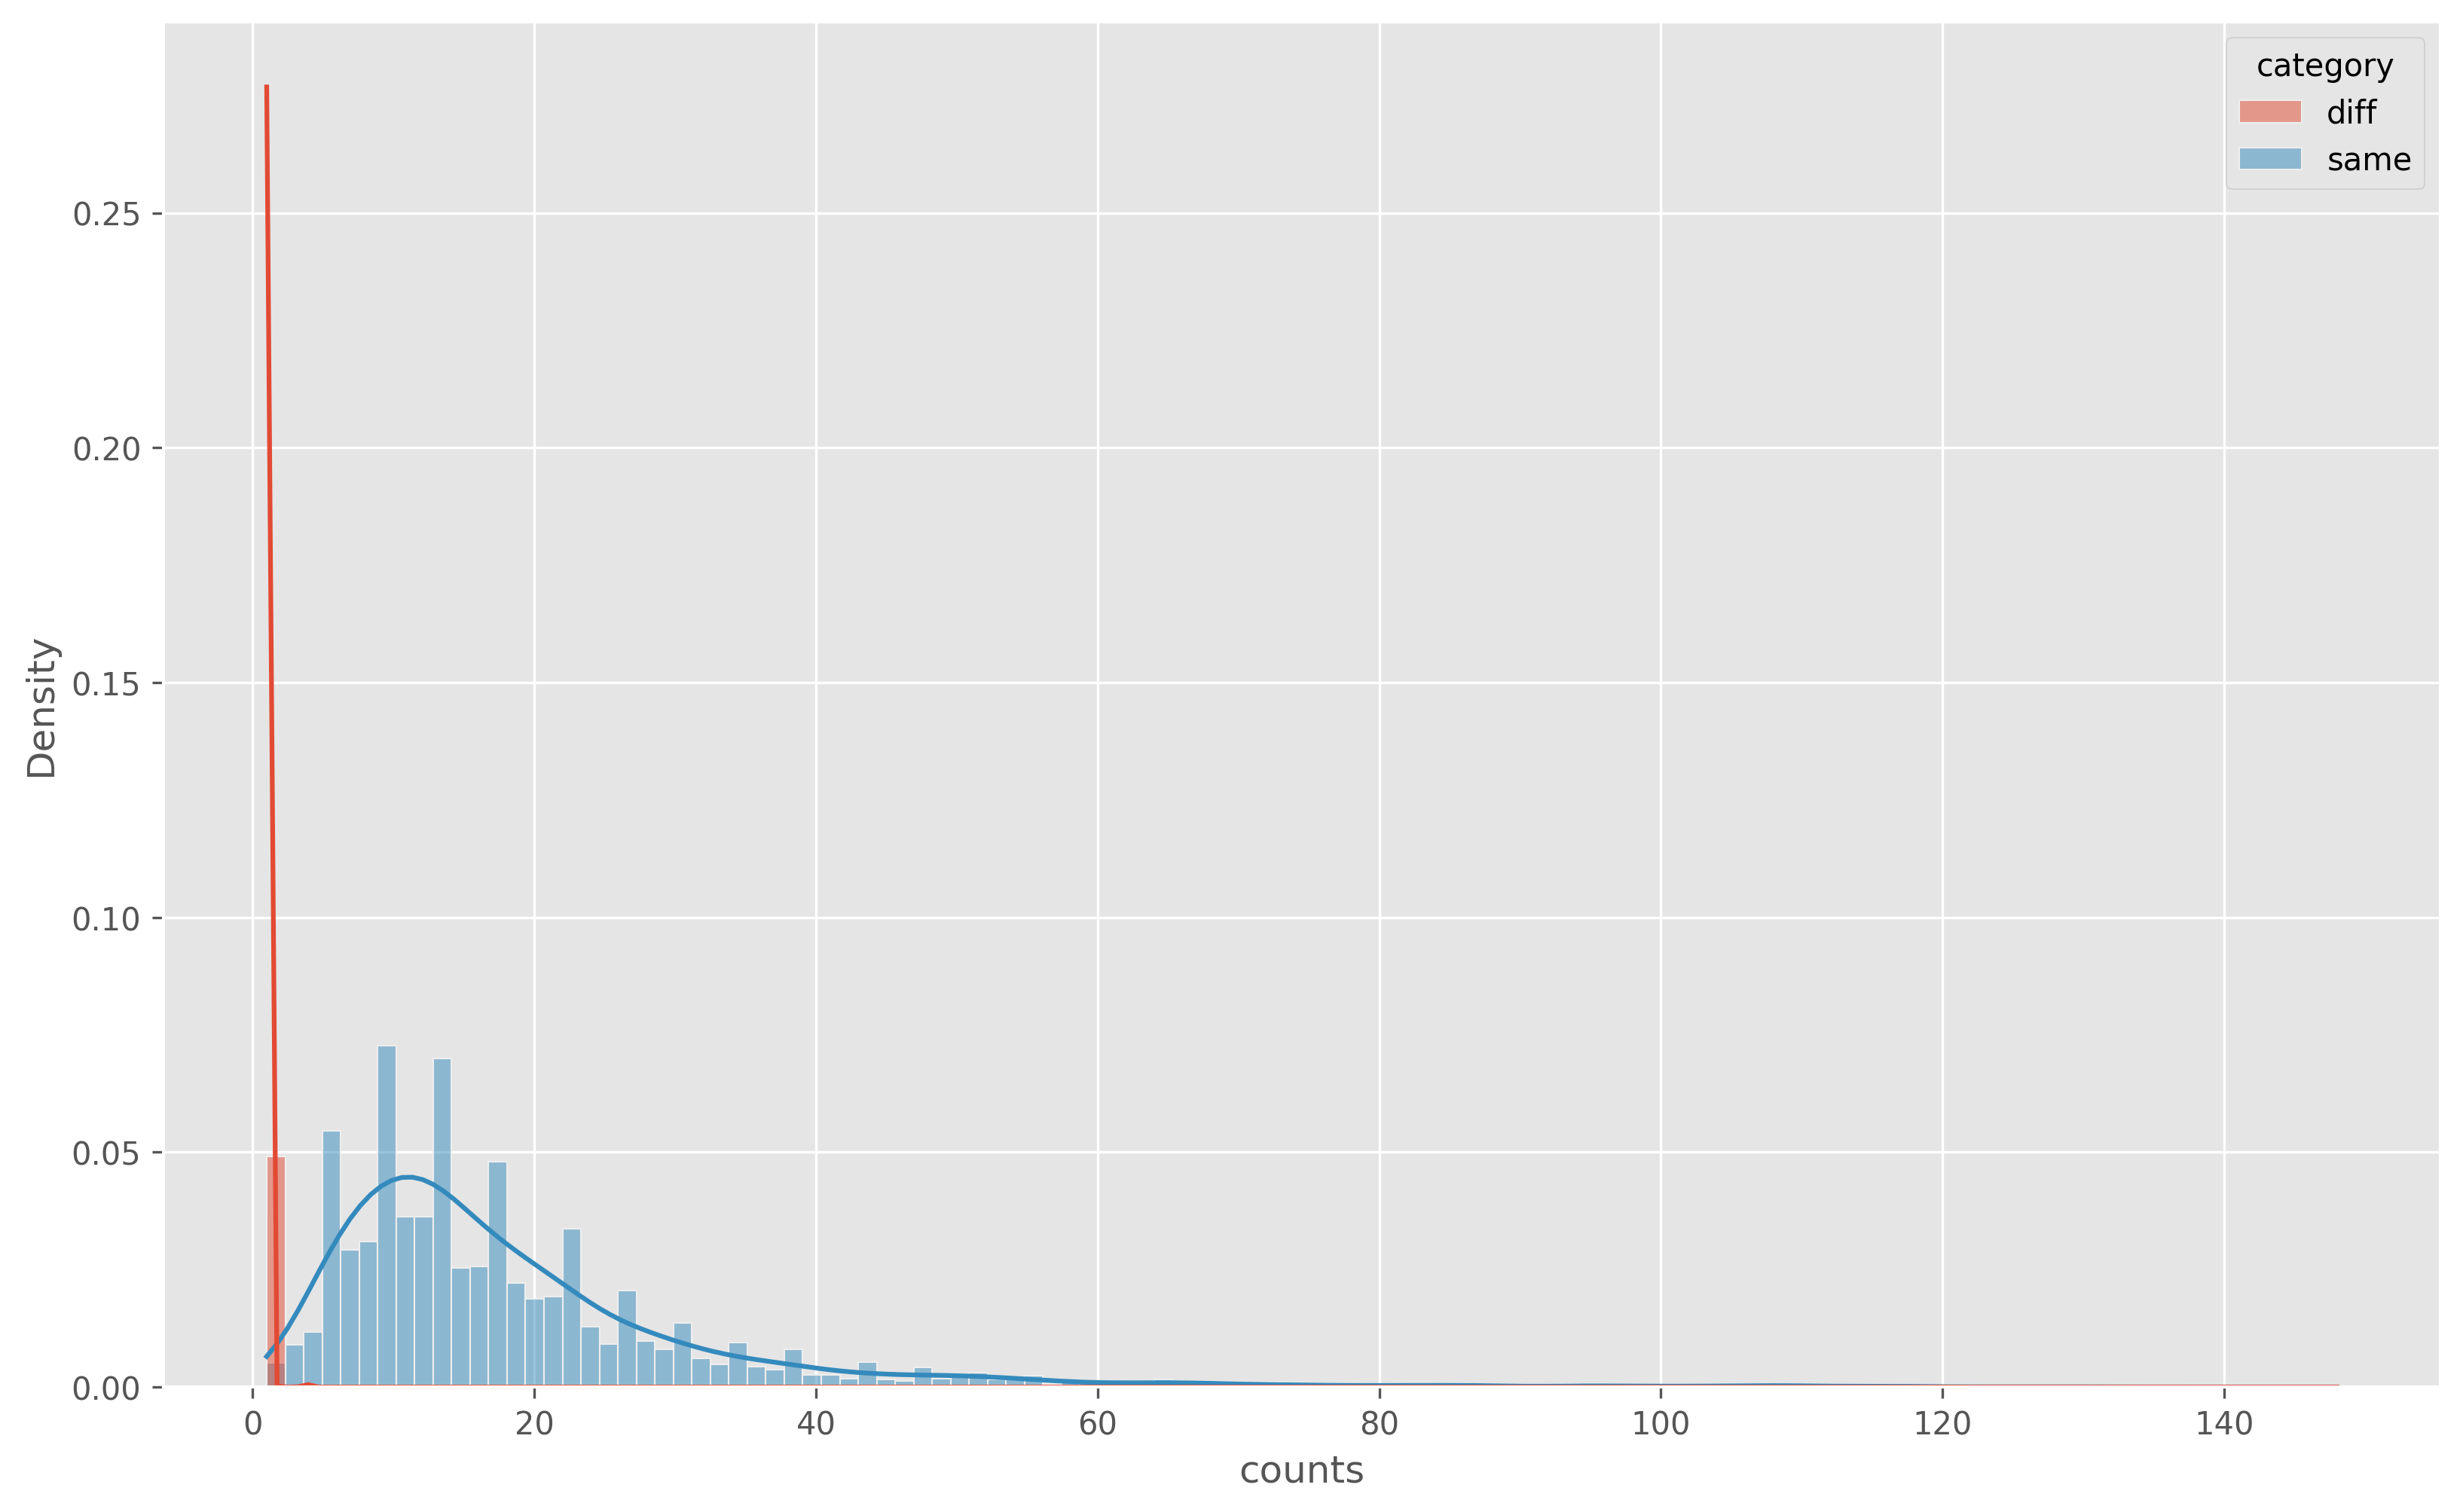

In [97]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(df, x="counts", hue="category", ax=ax, 
             stat="density", kde=True)

## Conclusion

There doesn't appear to be any "culprit" genes that could explain the differences.

## Position within gene

Is there enrichment for incorrect calls near the starts and ends of genes?

In [98]:
vcf_ref = pysam.FastaFile("pandora_multisample.vcf_ref.fa")

In [4]:
def get_rel_pos(variant: Variant) -> float:
    pos = variant.POS - 1
    gene_len = vcf_ref.get_reference_length(variant.CHROM) - 1
    return pos / gene_len

In [100]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        data.append((pair, cat, get_rel_pos(v)))

In [101]:
df = pd.DataFrame(data, columns=["pair", "category", "rel_pos"])

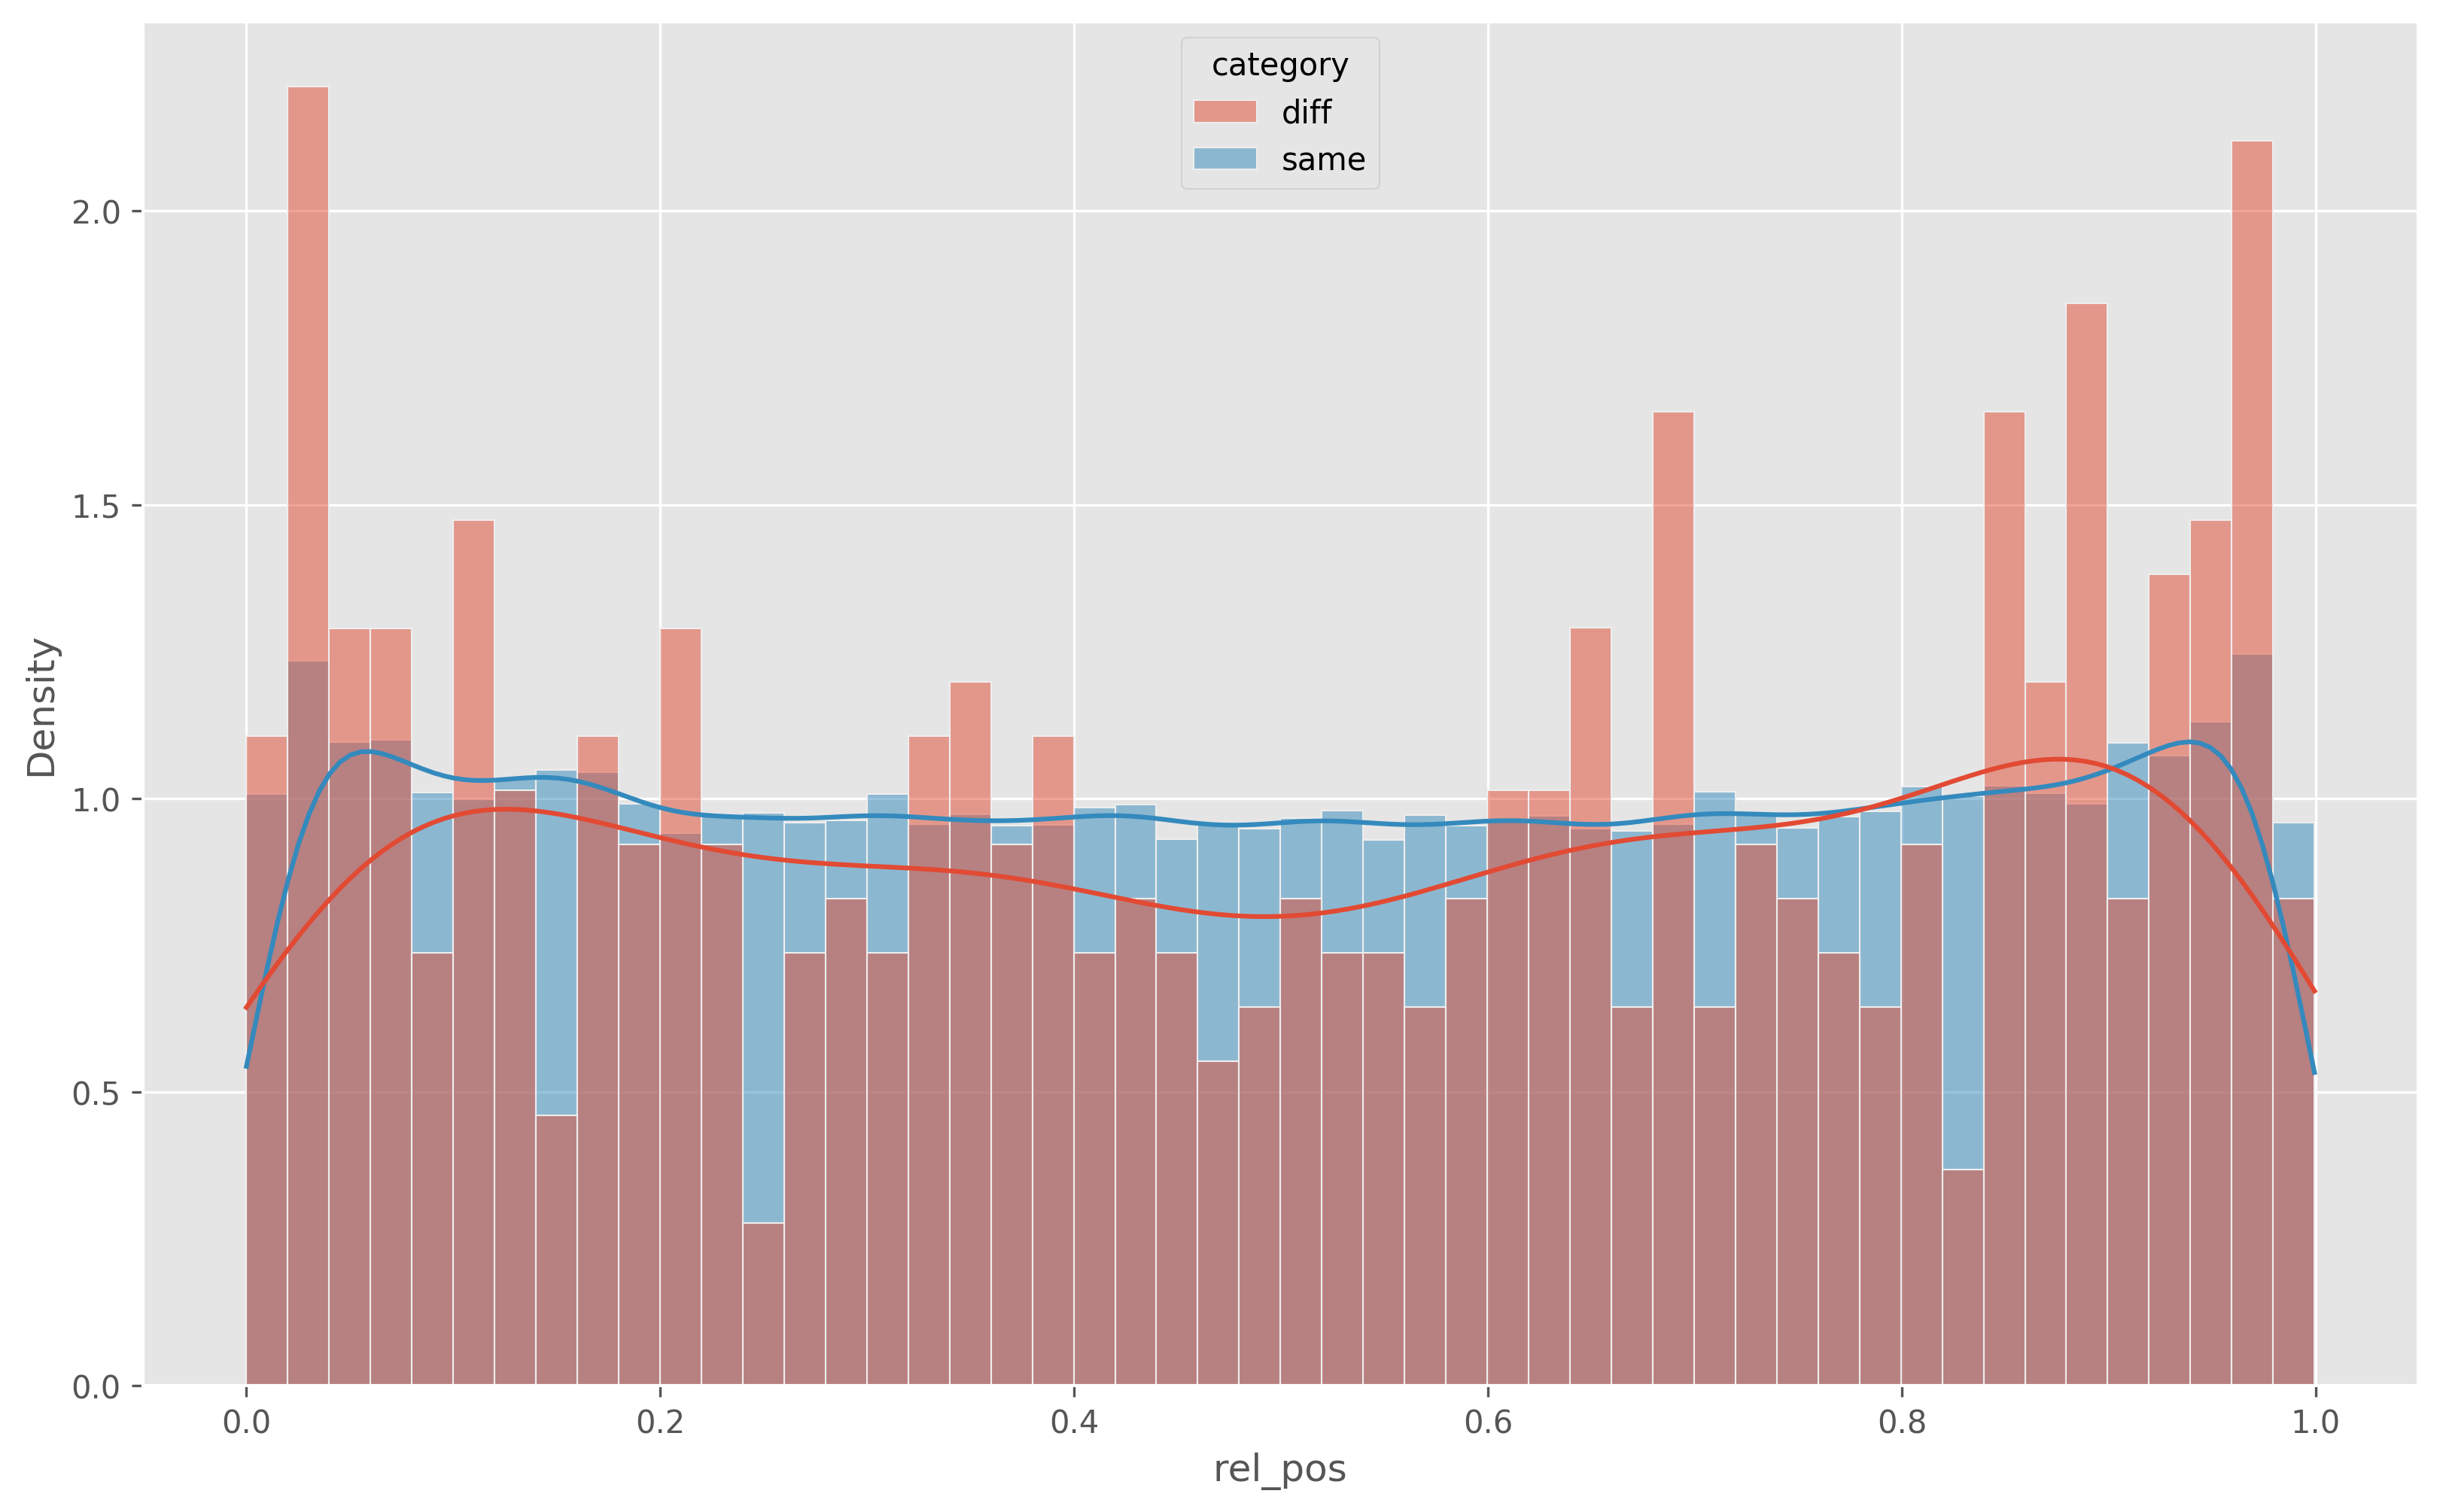

In [102]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(df, x="rel_pos", hue="category", ax=ax, kde=True, stat="density", common_norm=False, bins=50)

### Conclusion

There *may* be a slight over-enrichment at the start/end of genes for the incorrect variants. Although, the kernel density estimate (line) would suggest the relationship is not that different to the ones where we get it correct...

## Variant type

Is there an enrichment for certain variant types (i.e. SNPs/indels)?

In [5]:
def variant_type(variant: Variant) -> str:
    if not variant.ALT:
        return "no-alt"
    if len(variant.REF) == 1 and all(len(al) == 1 for al in variant.ALT):
        return "snp"
    return "non-snp"

In [104]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        var_type = variant_type(v)
        if var_type == "no-alt":
            continue
        data.append((pair, cat, var_type))

In [105]:
df = pd.DataFrame(data, columns=["pair", "category", "var_type"])

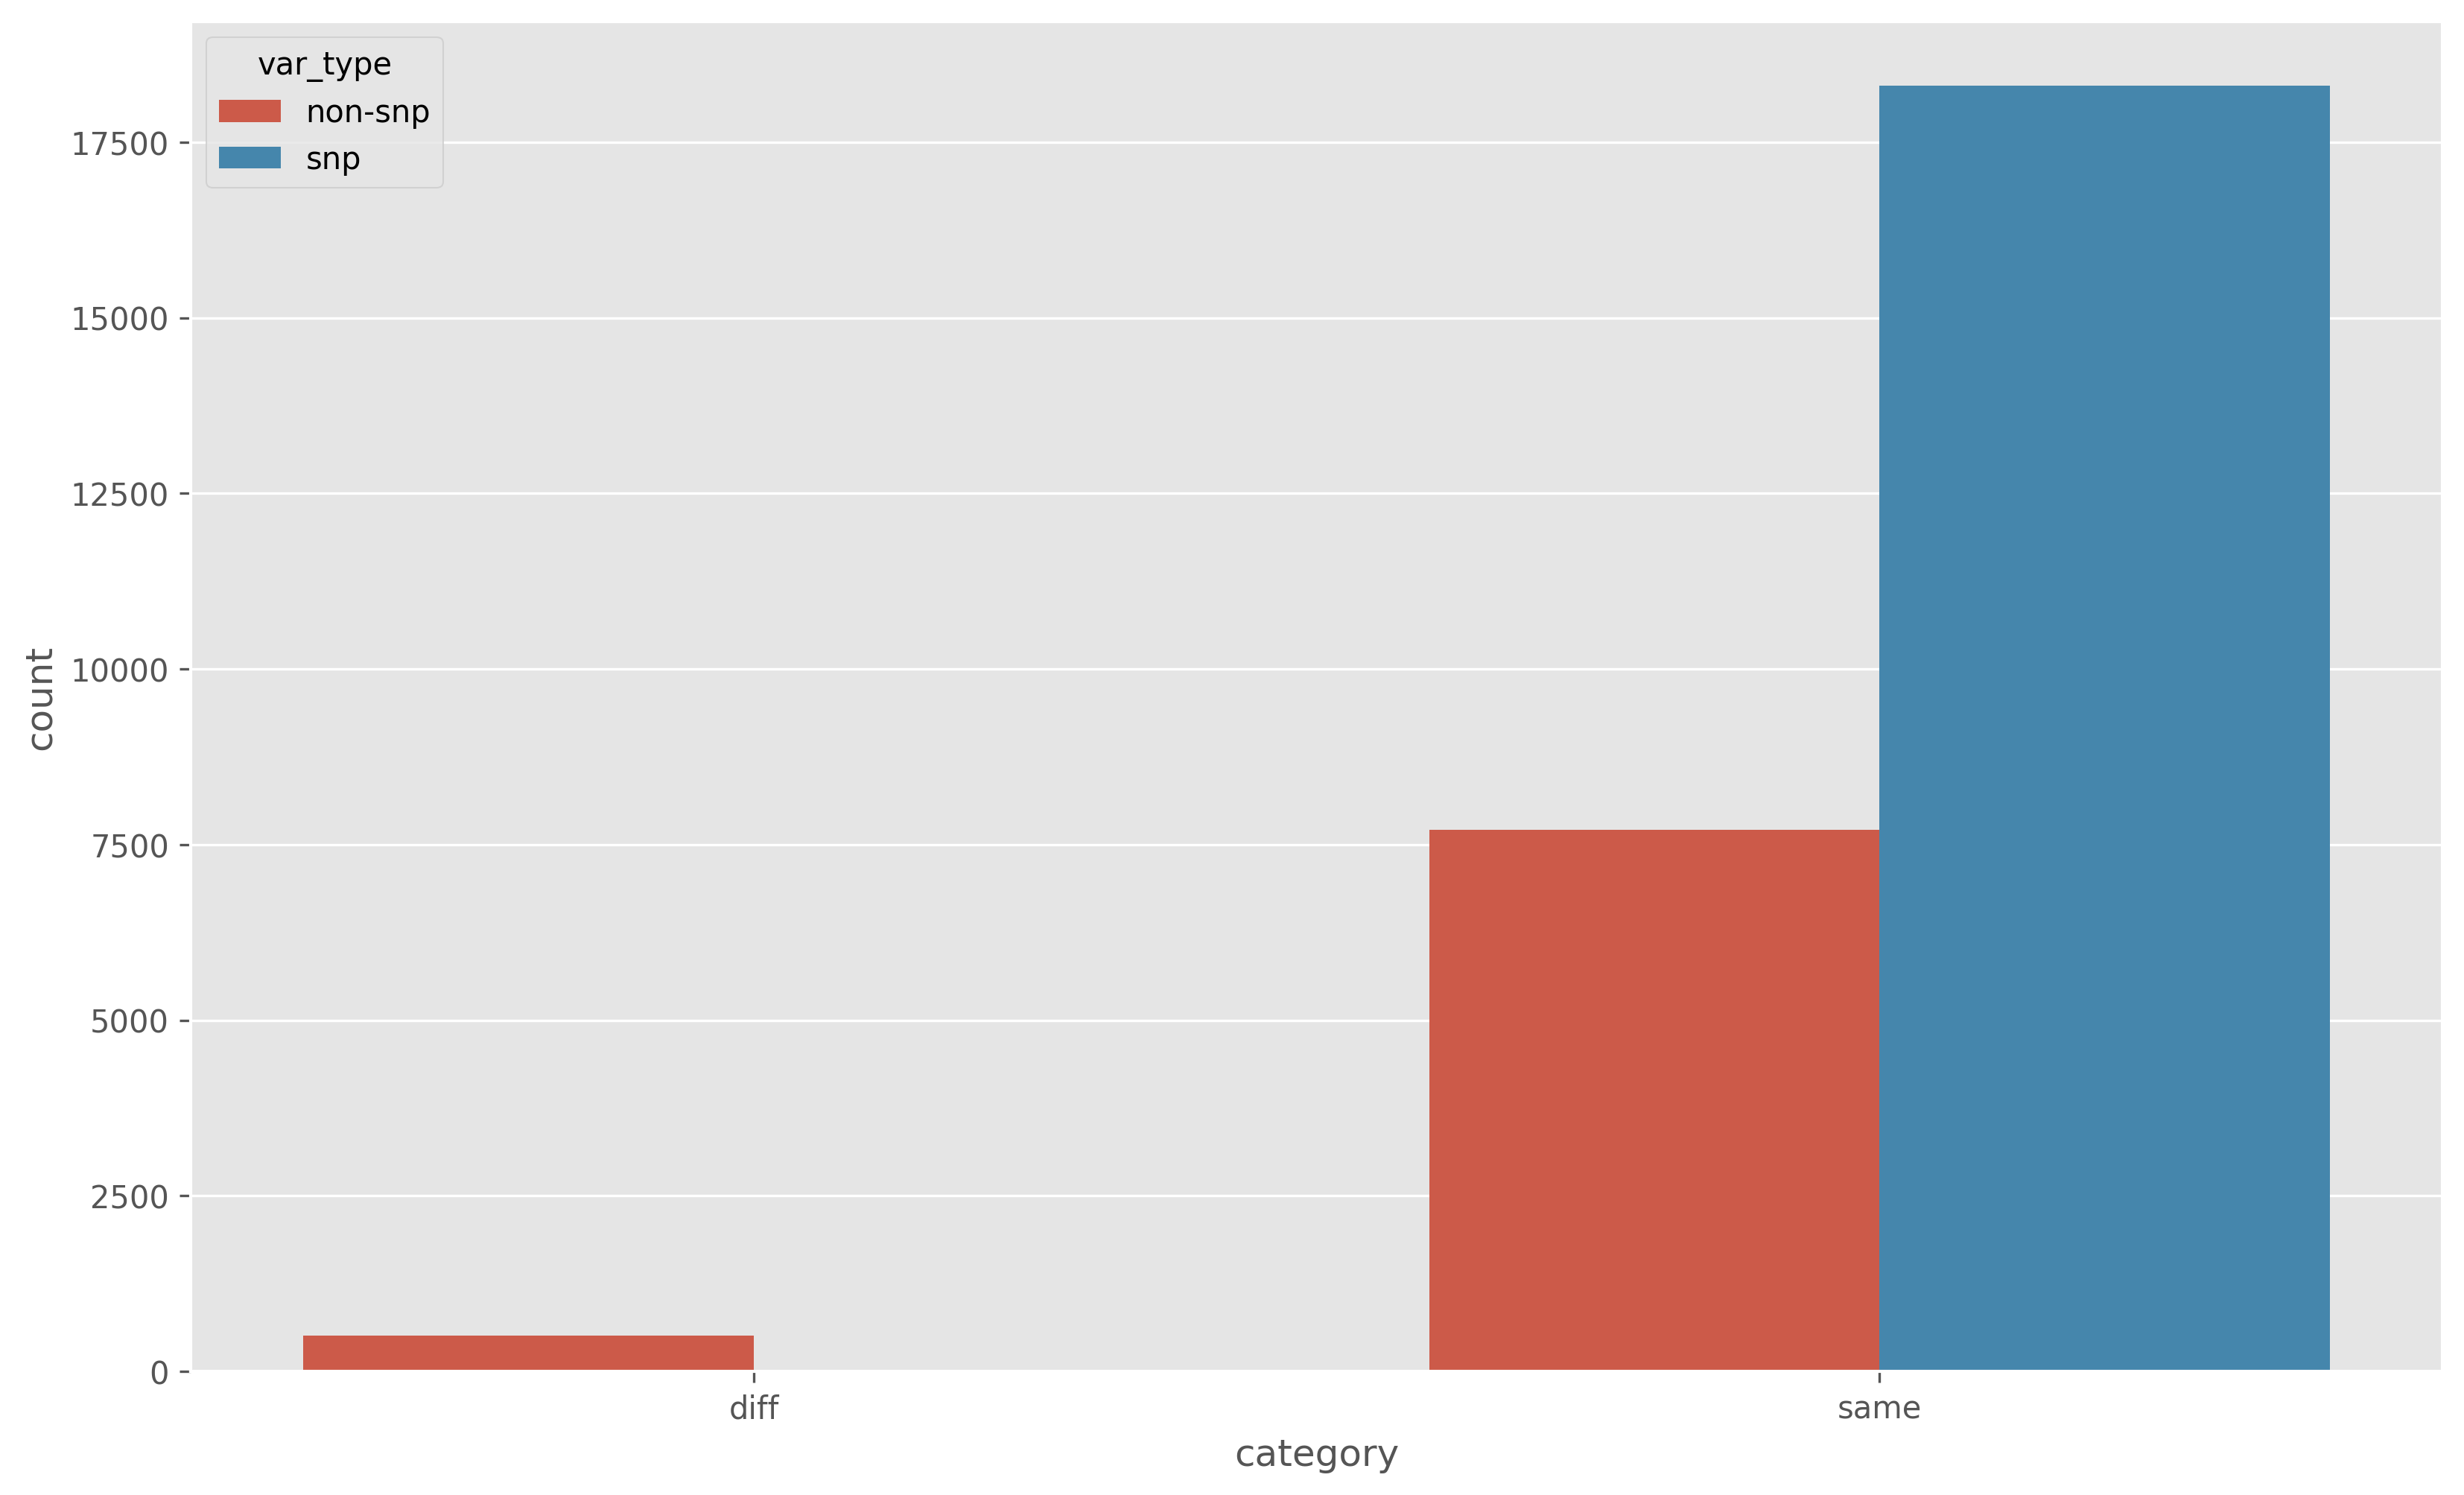

In [106]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.countplot(data=df, hue="var_type", x="category", ax=ax)

In [110]:
df.groupby(["category", "var_type"]).count()

pair
category var_type       
diff     non-snp     516
         snp          27
same     non-snp    7715
         snp       18300

### Conclusion

This shows, fairly strikingly, that the bulk (516/543 or 95%) of the "incorrect" calls are non-snps.

## GT Conf
Is there a distinct pattern in genotype confidence values between the correct and incorrect calls?

In [6]:
def get_gt_conf(variant: Variant) -> list:
    return variant.format("GT_CONF")

In [157]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        gt_confs = get_gt_conf(v)
        for conf in gt_confs:
            data.append((pair, cat, conf[0]))

In [158]:
df = pd.DataFrame(data, columns=["pair", "category", "gt_conf"])

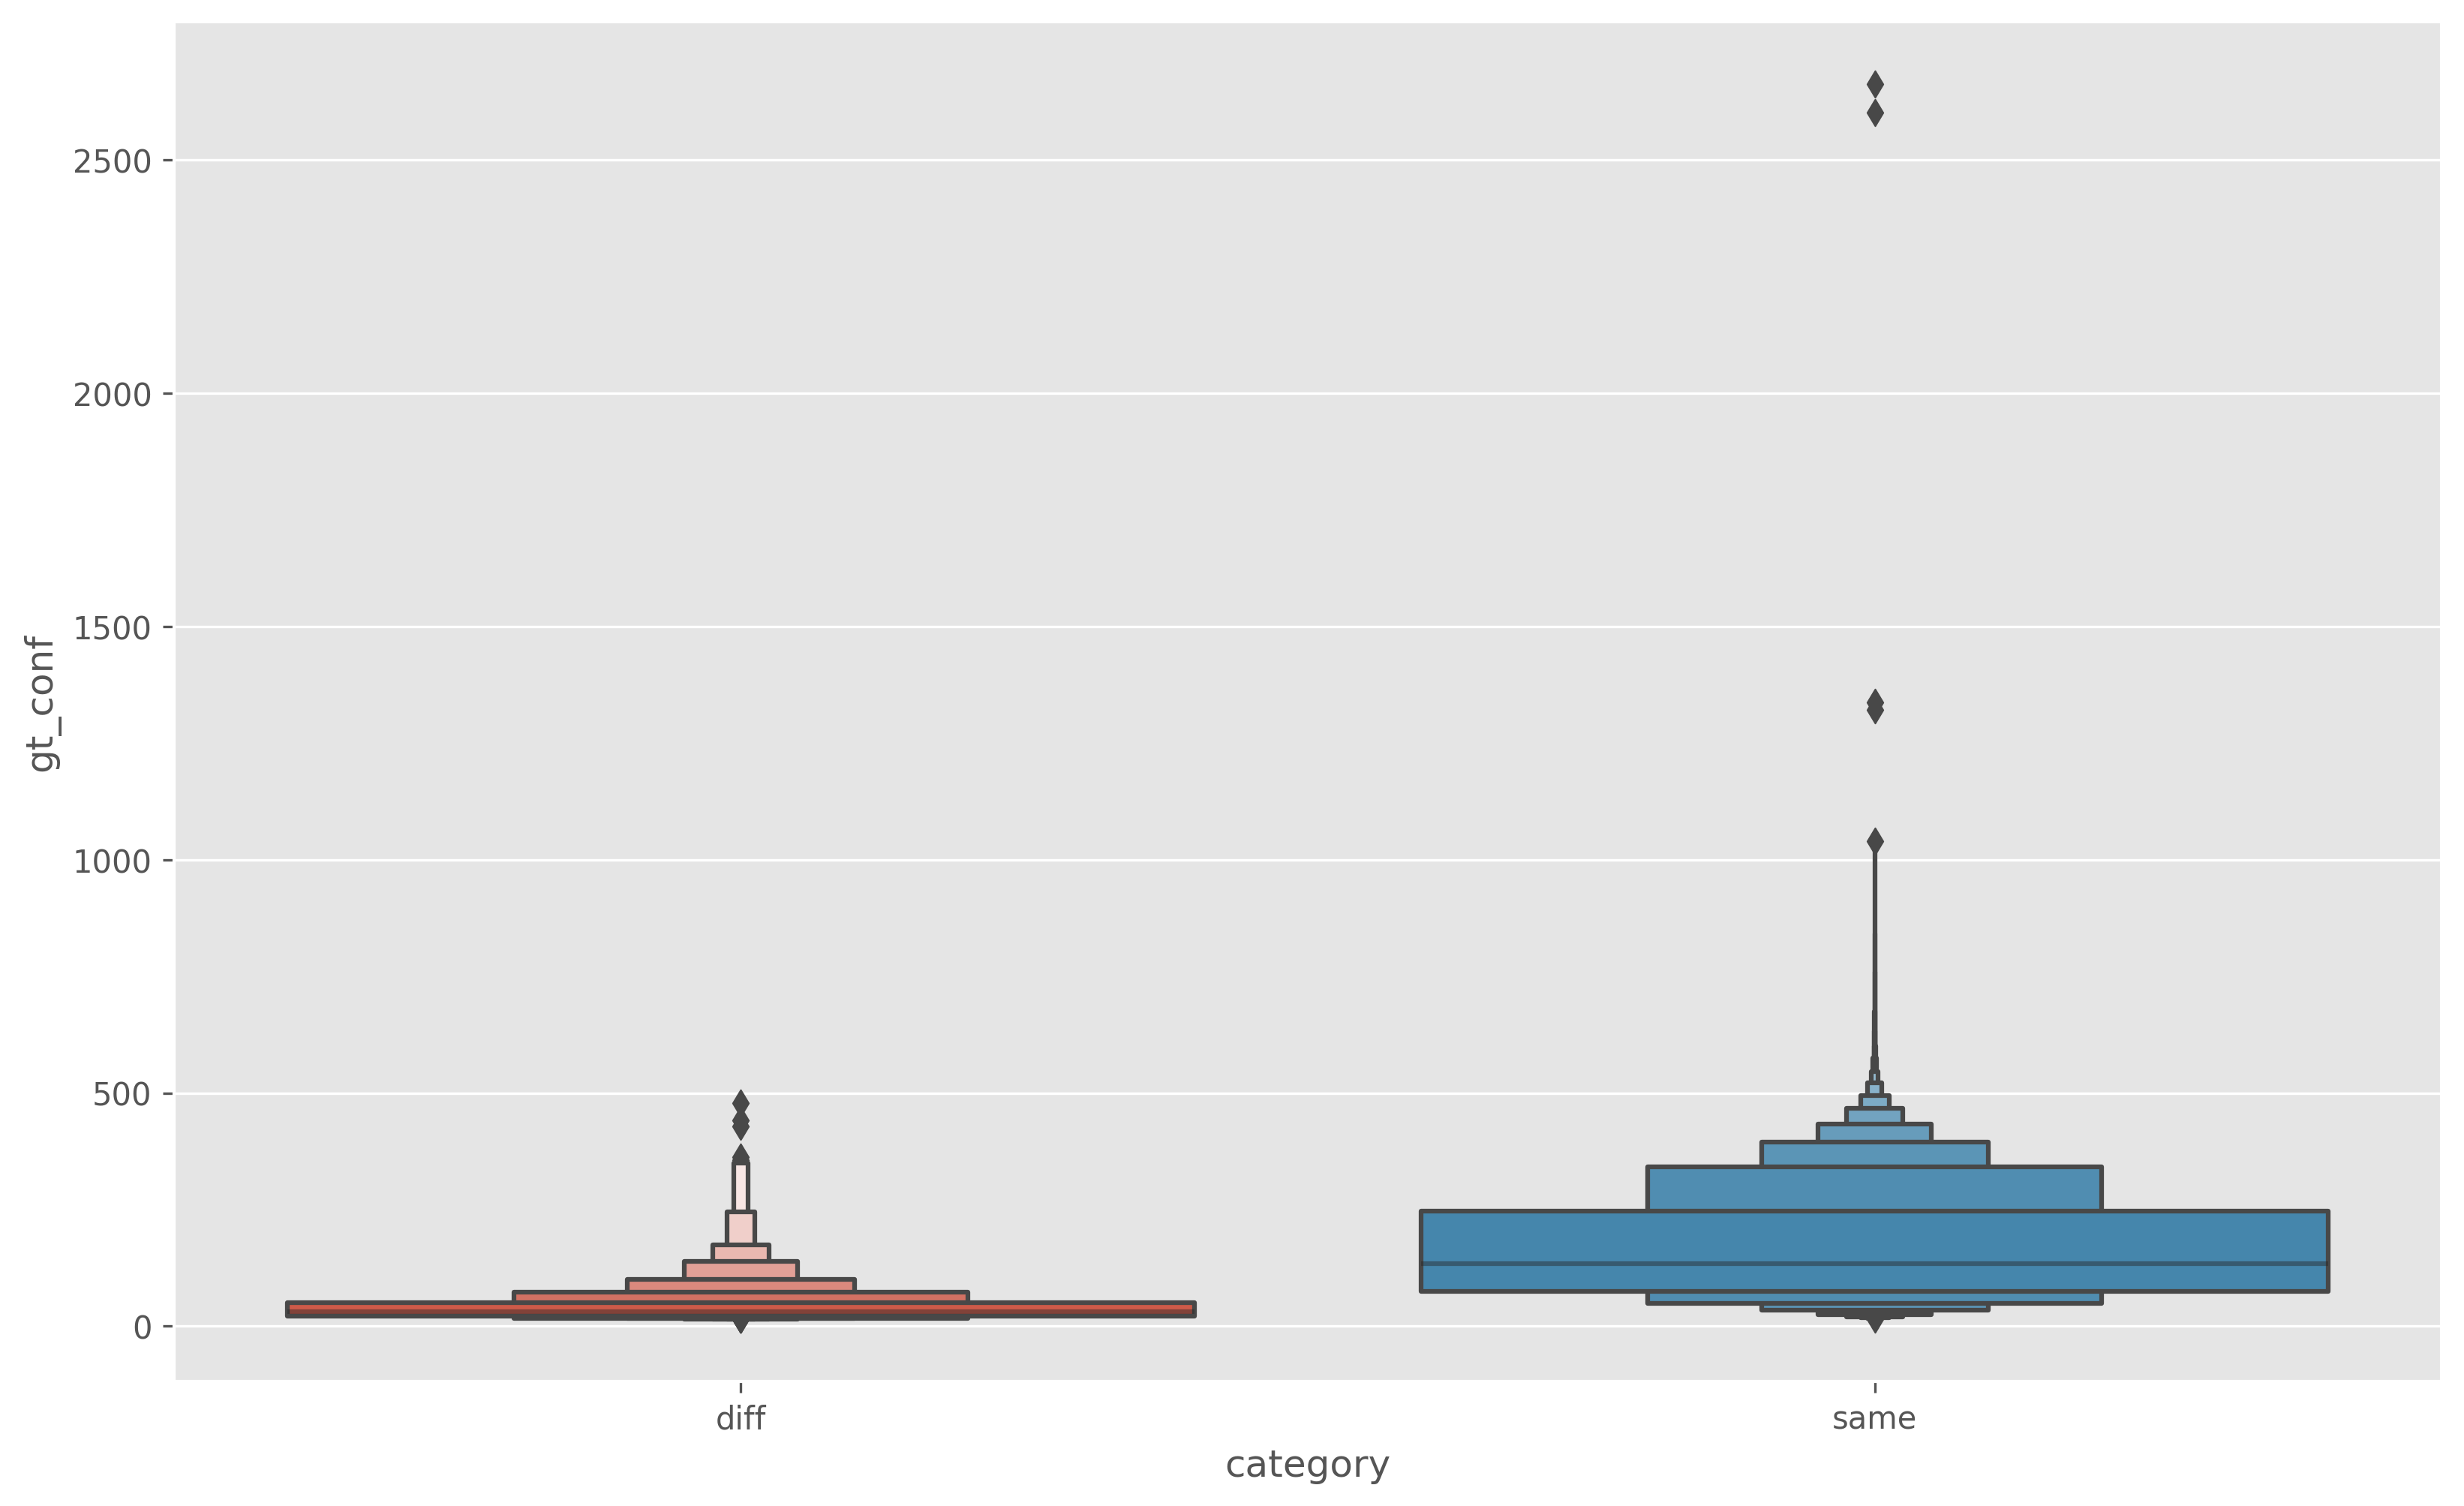

In [159]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="gt_conf", x="category", ax=ax)

(0, 600)

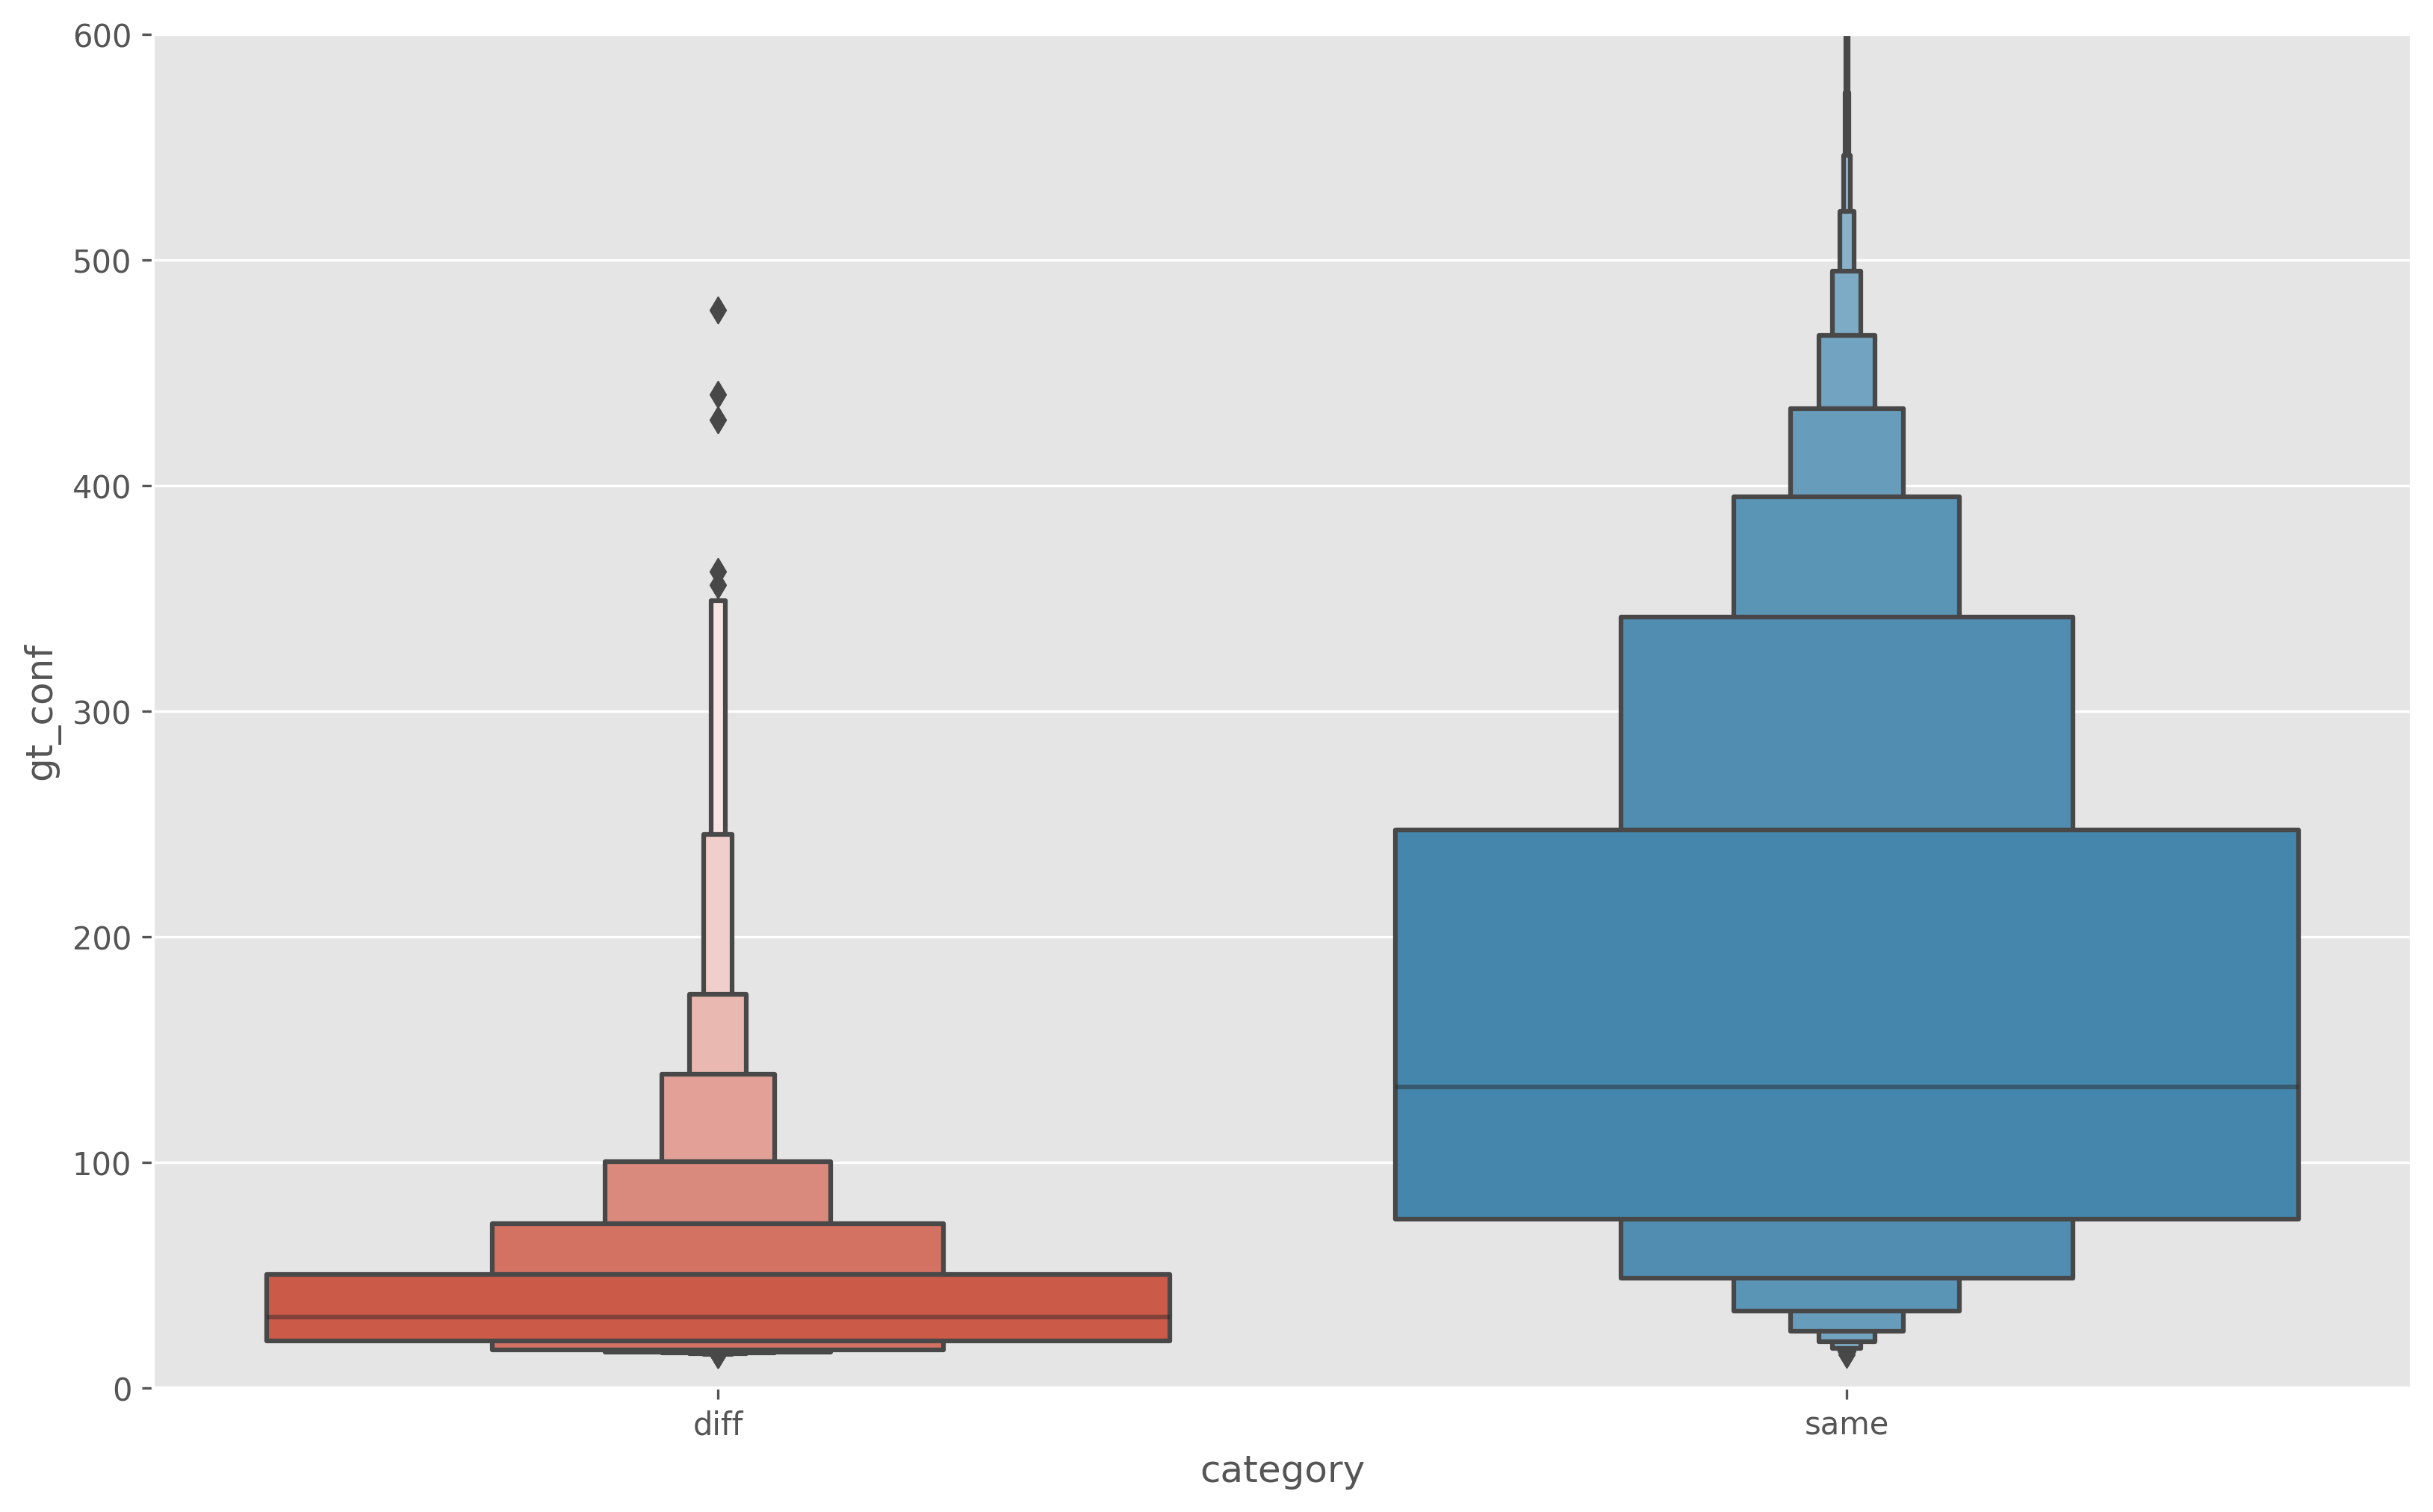

In [160]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="gt_conf", x="category", ax=ax)
ax.set_ylim((0, 600))

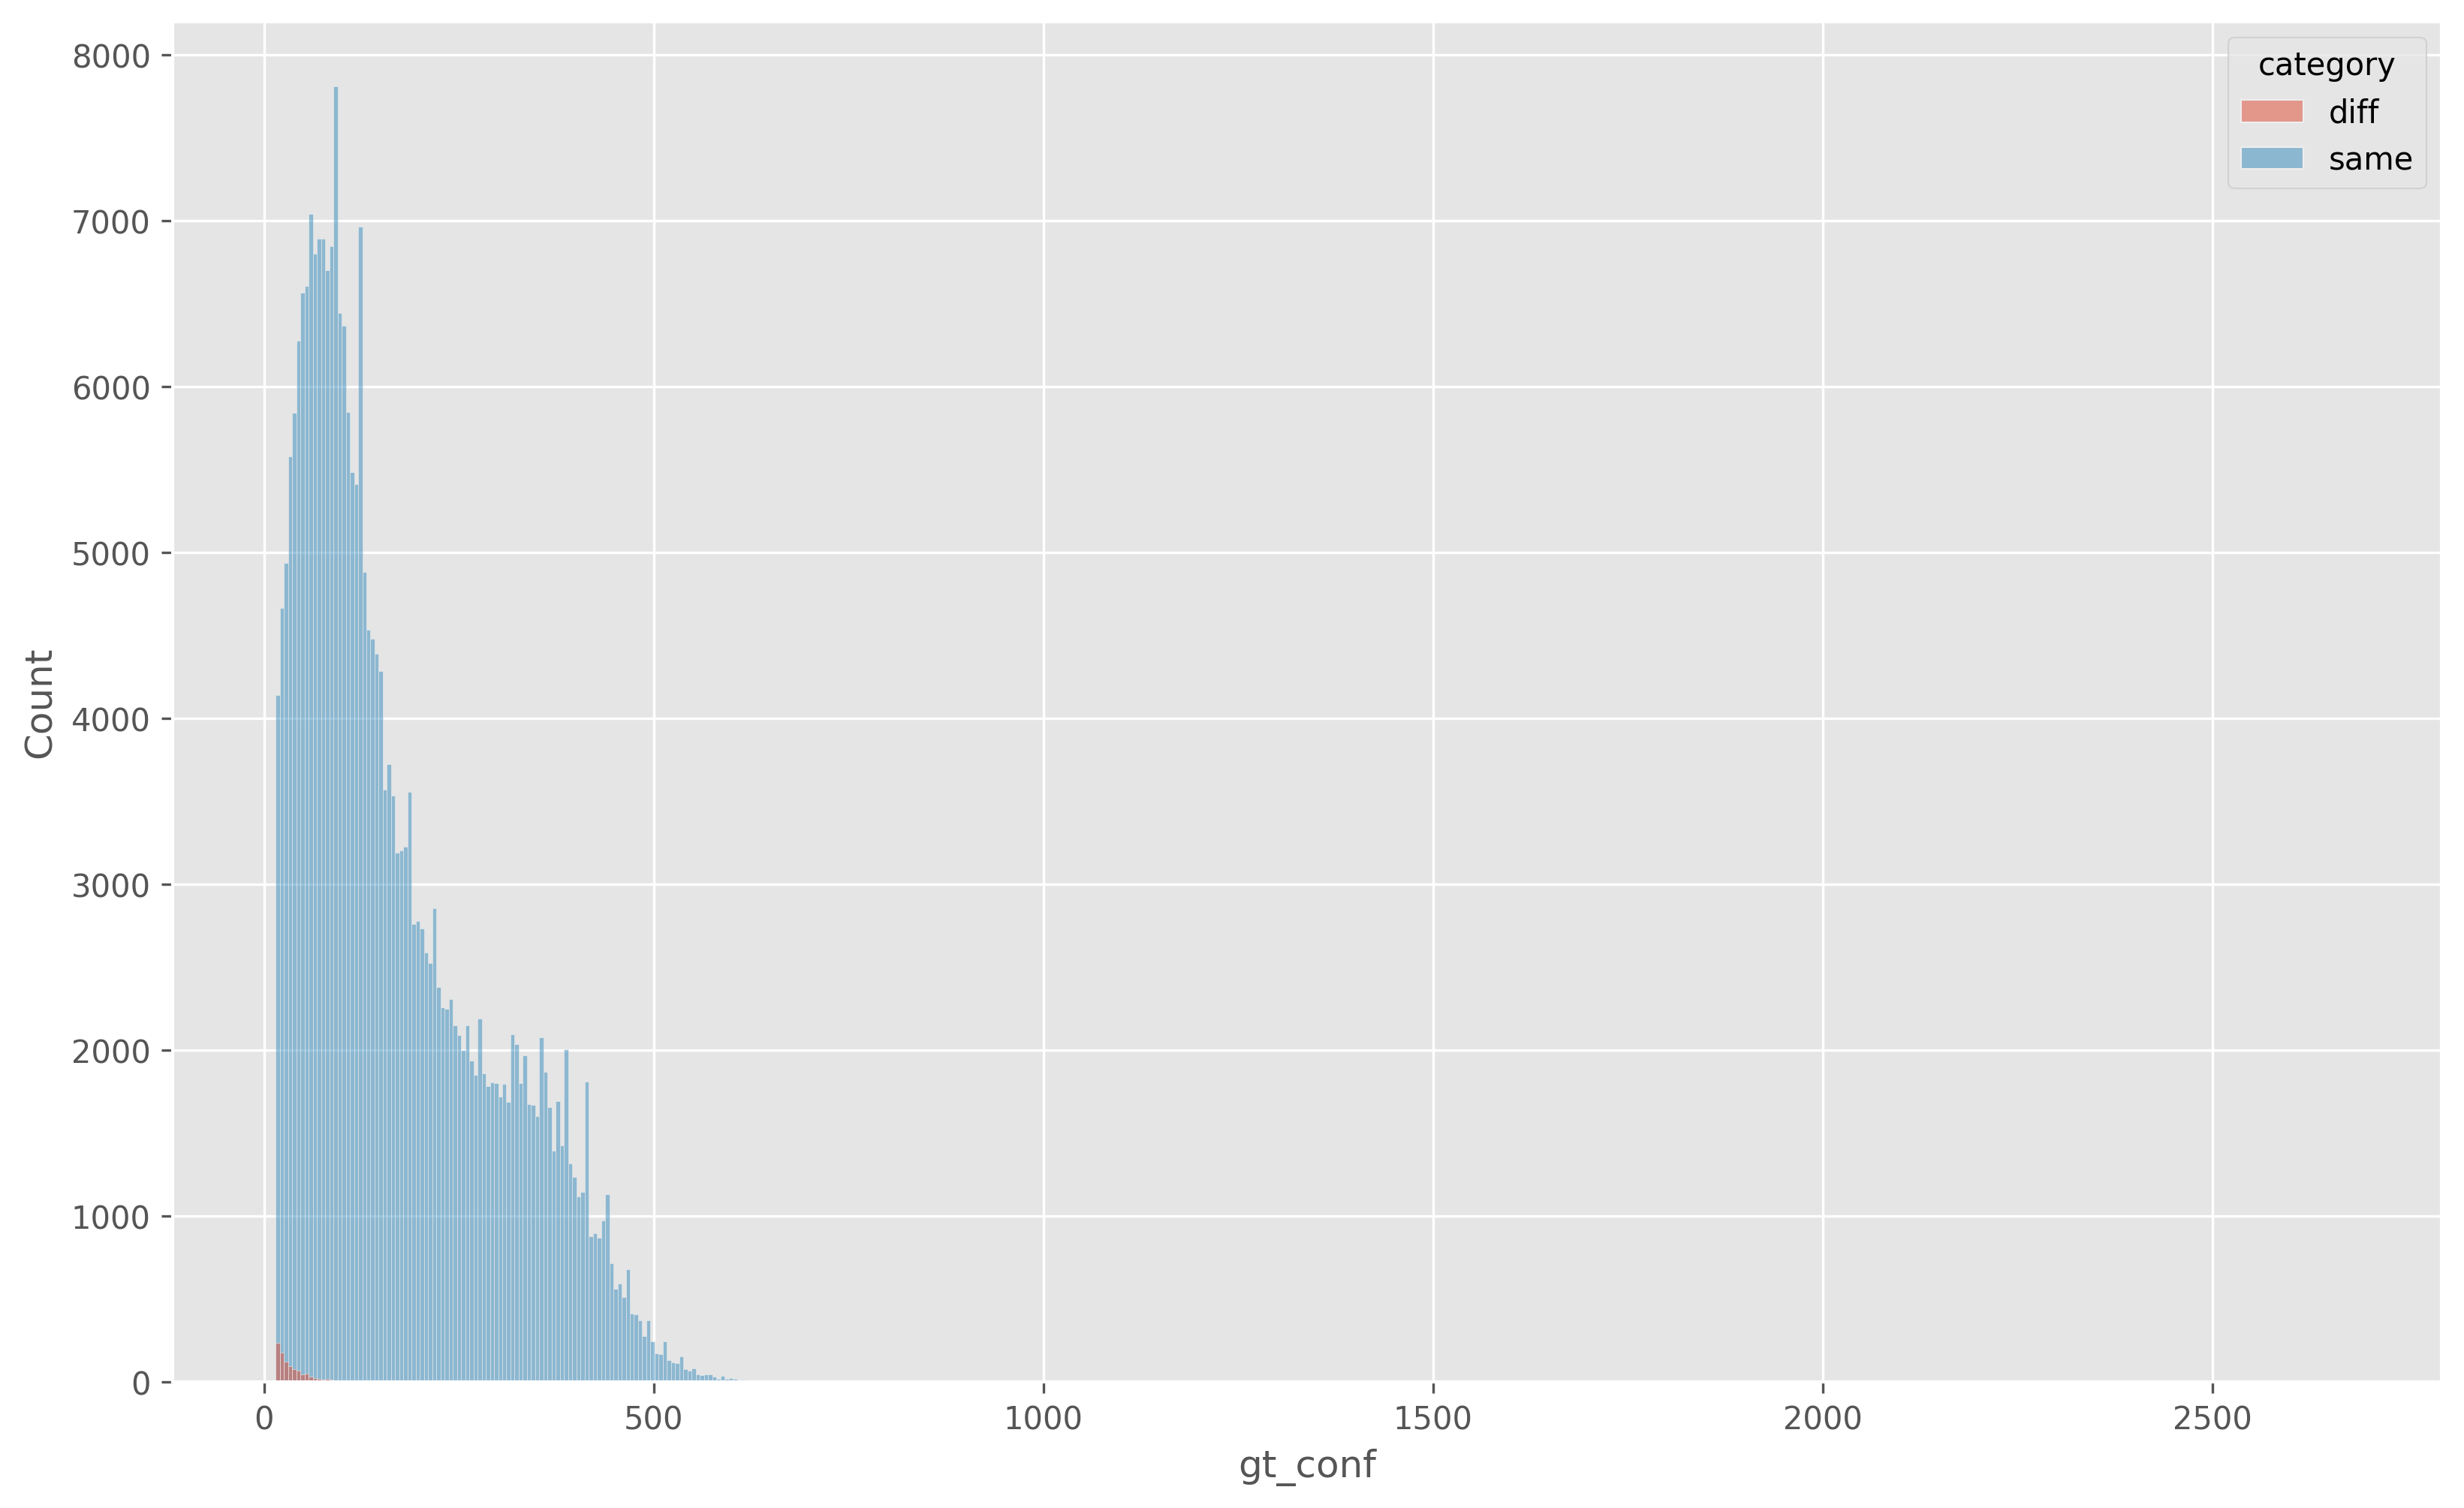

In [161]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="gt_conf", hue="category", ax=ax)

If we restrict to just non-SNPs in both categories, do we see a marked difference in GT conf?

In [151]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        var_type = variant_type(v)
        if var_type != "non-snp":
            continue
        gt_confs = get_gt_conf(v)
        for conf in gt_confs:
            data.append((pair, cat, conf[0]))

In [152]:
df = pd.DataFrame(data, columns=["pair", "category", "gt_conf"])

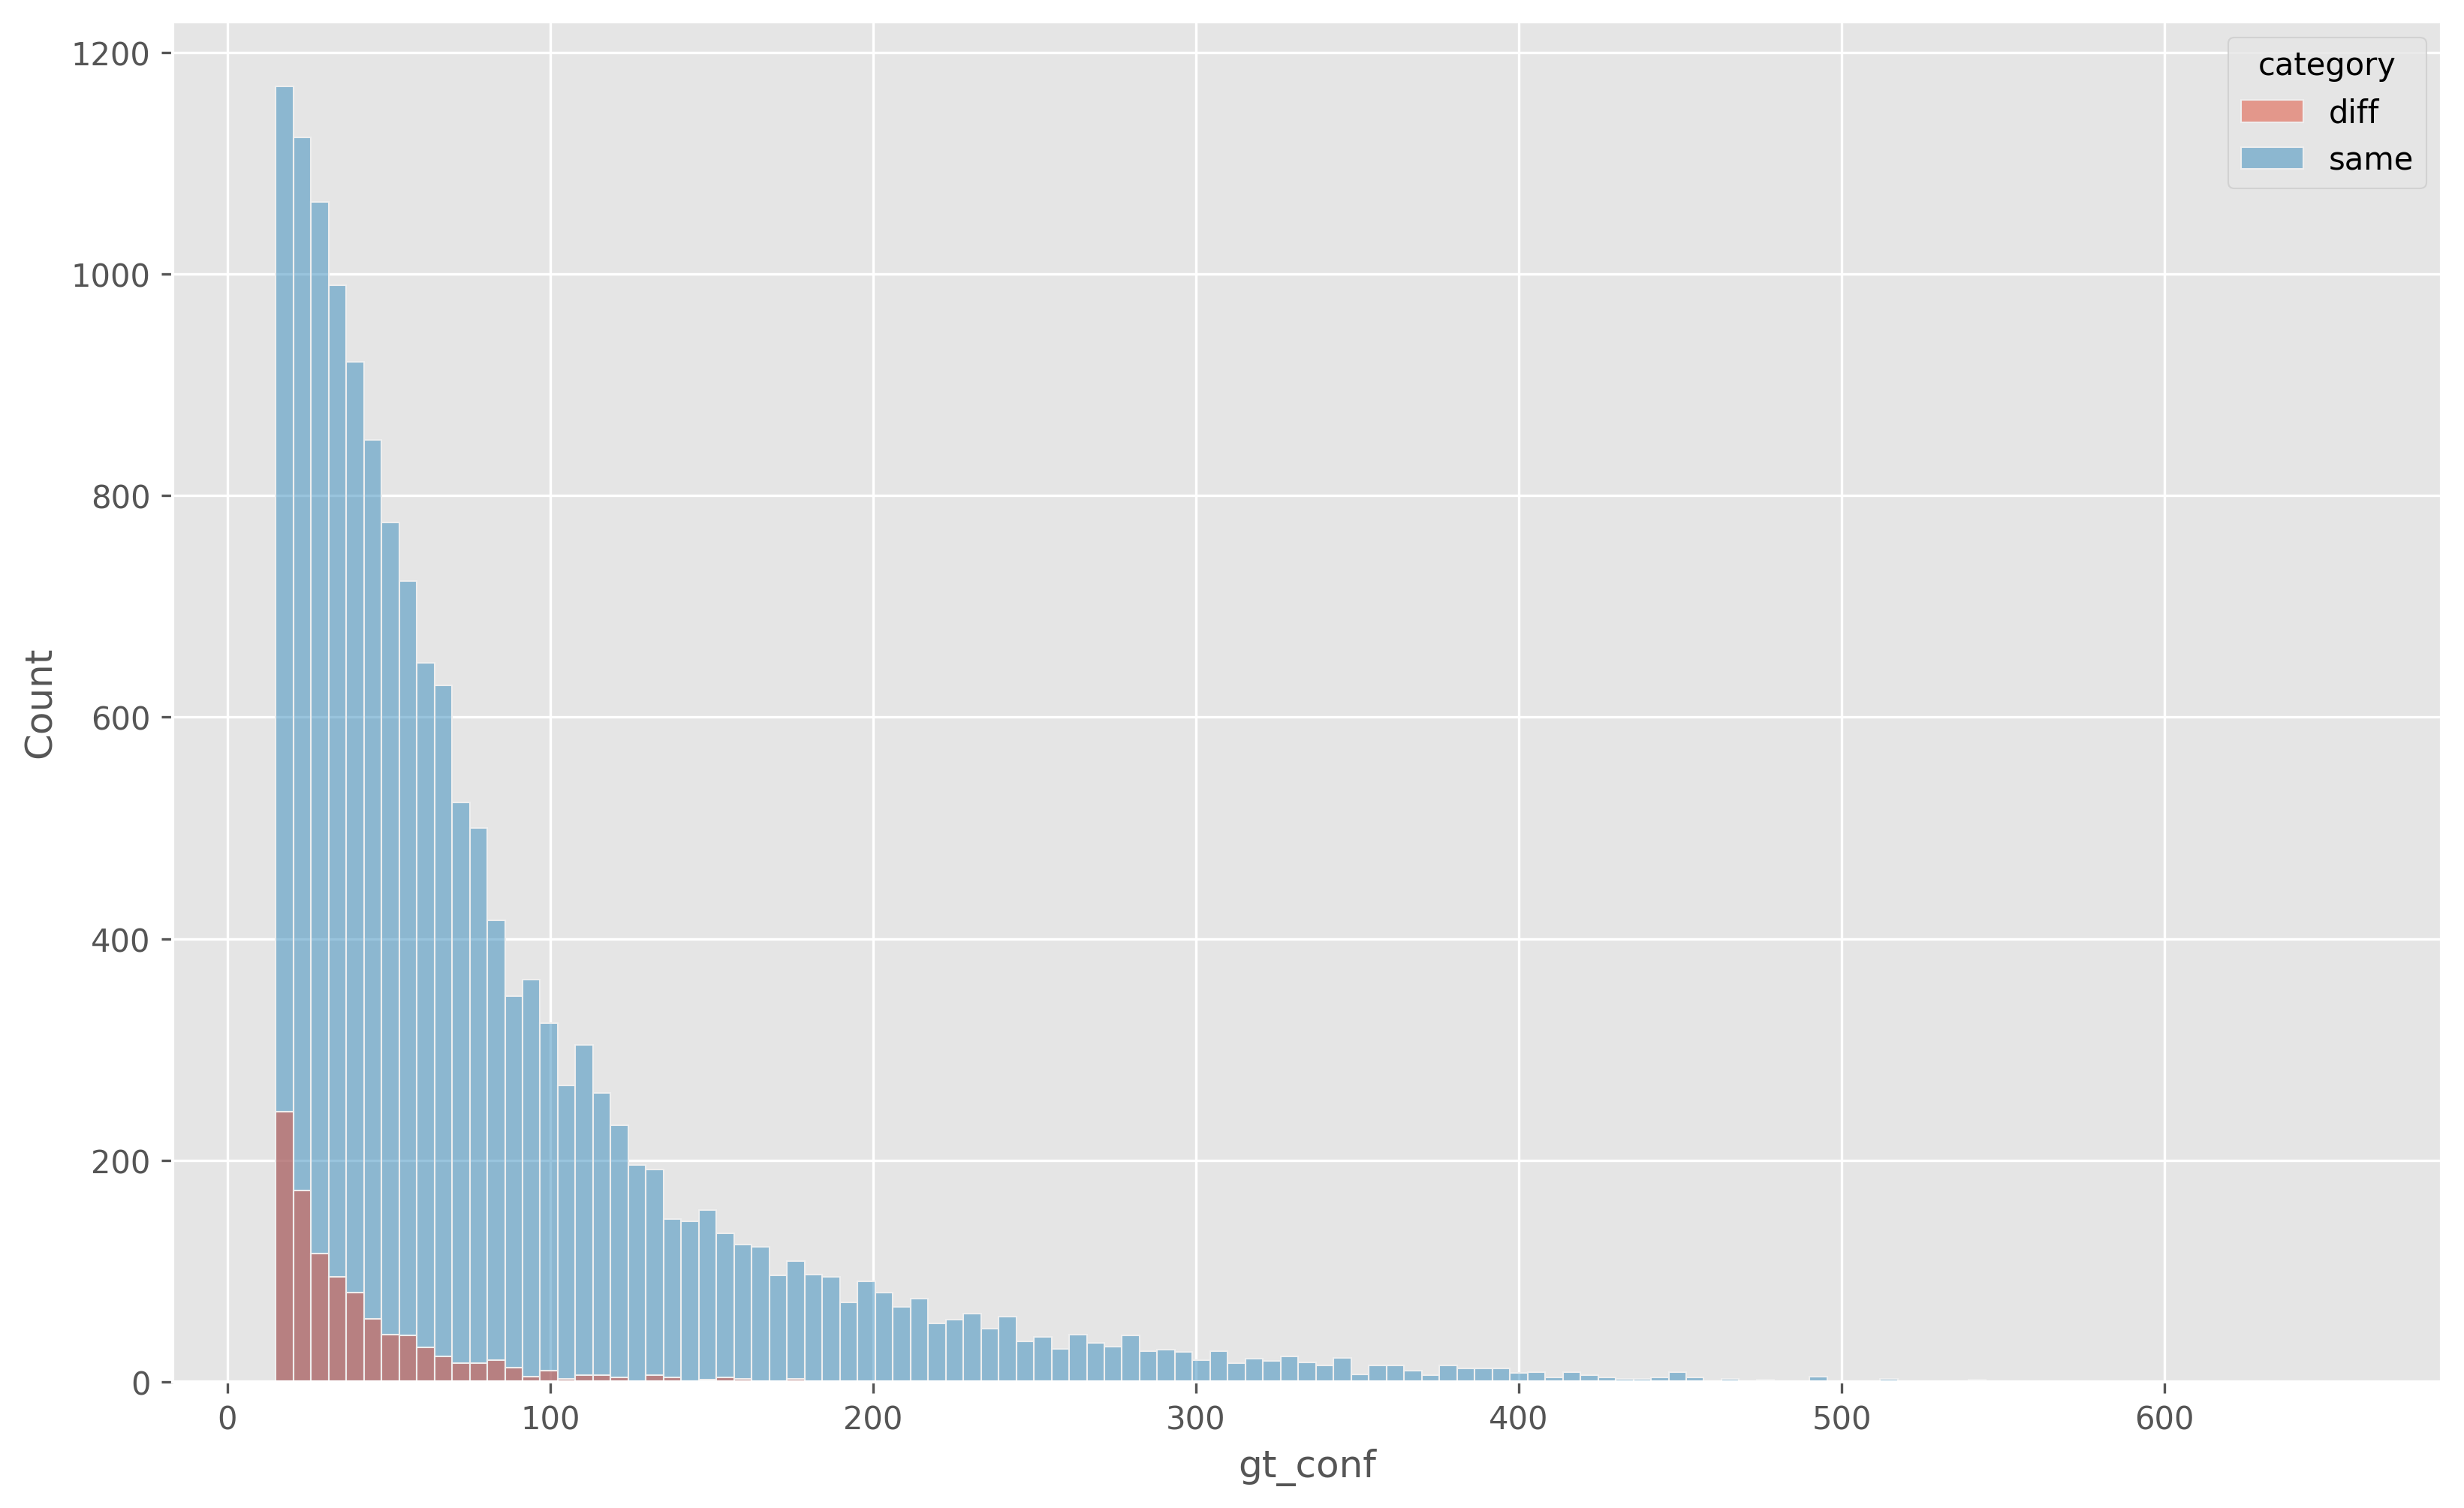

In [153]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="gt_conf", hue="category", ax=ax)

(0, 100)

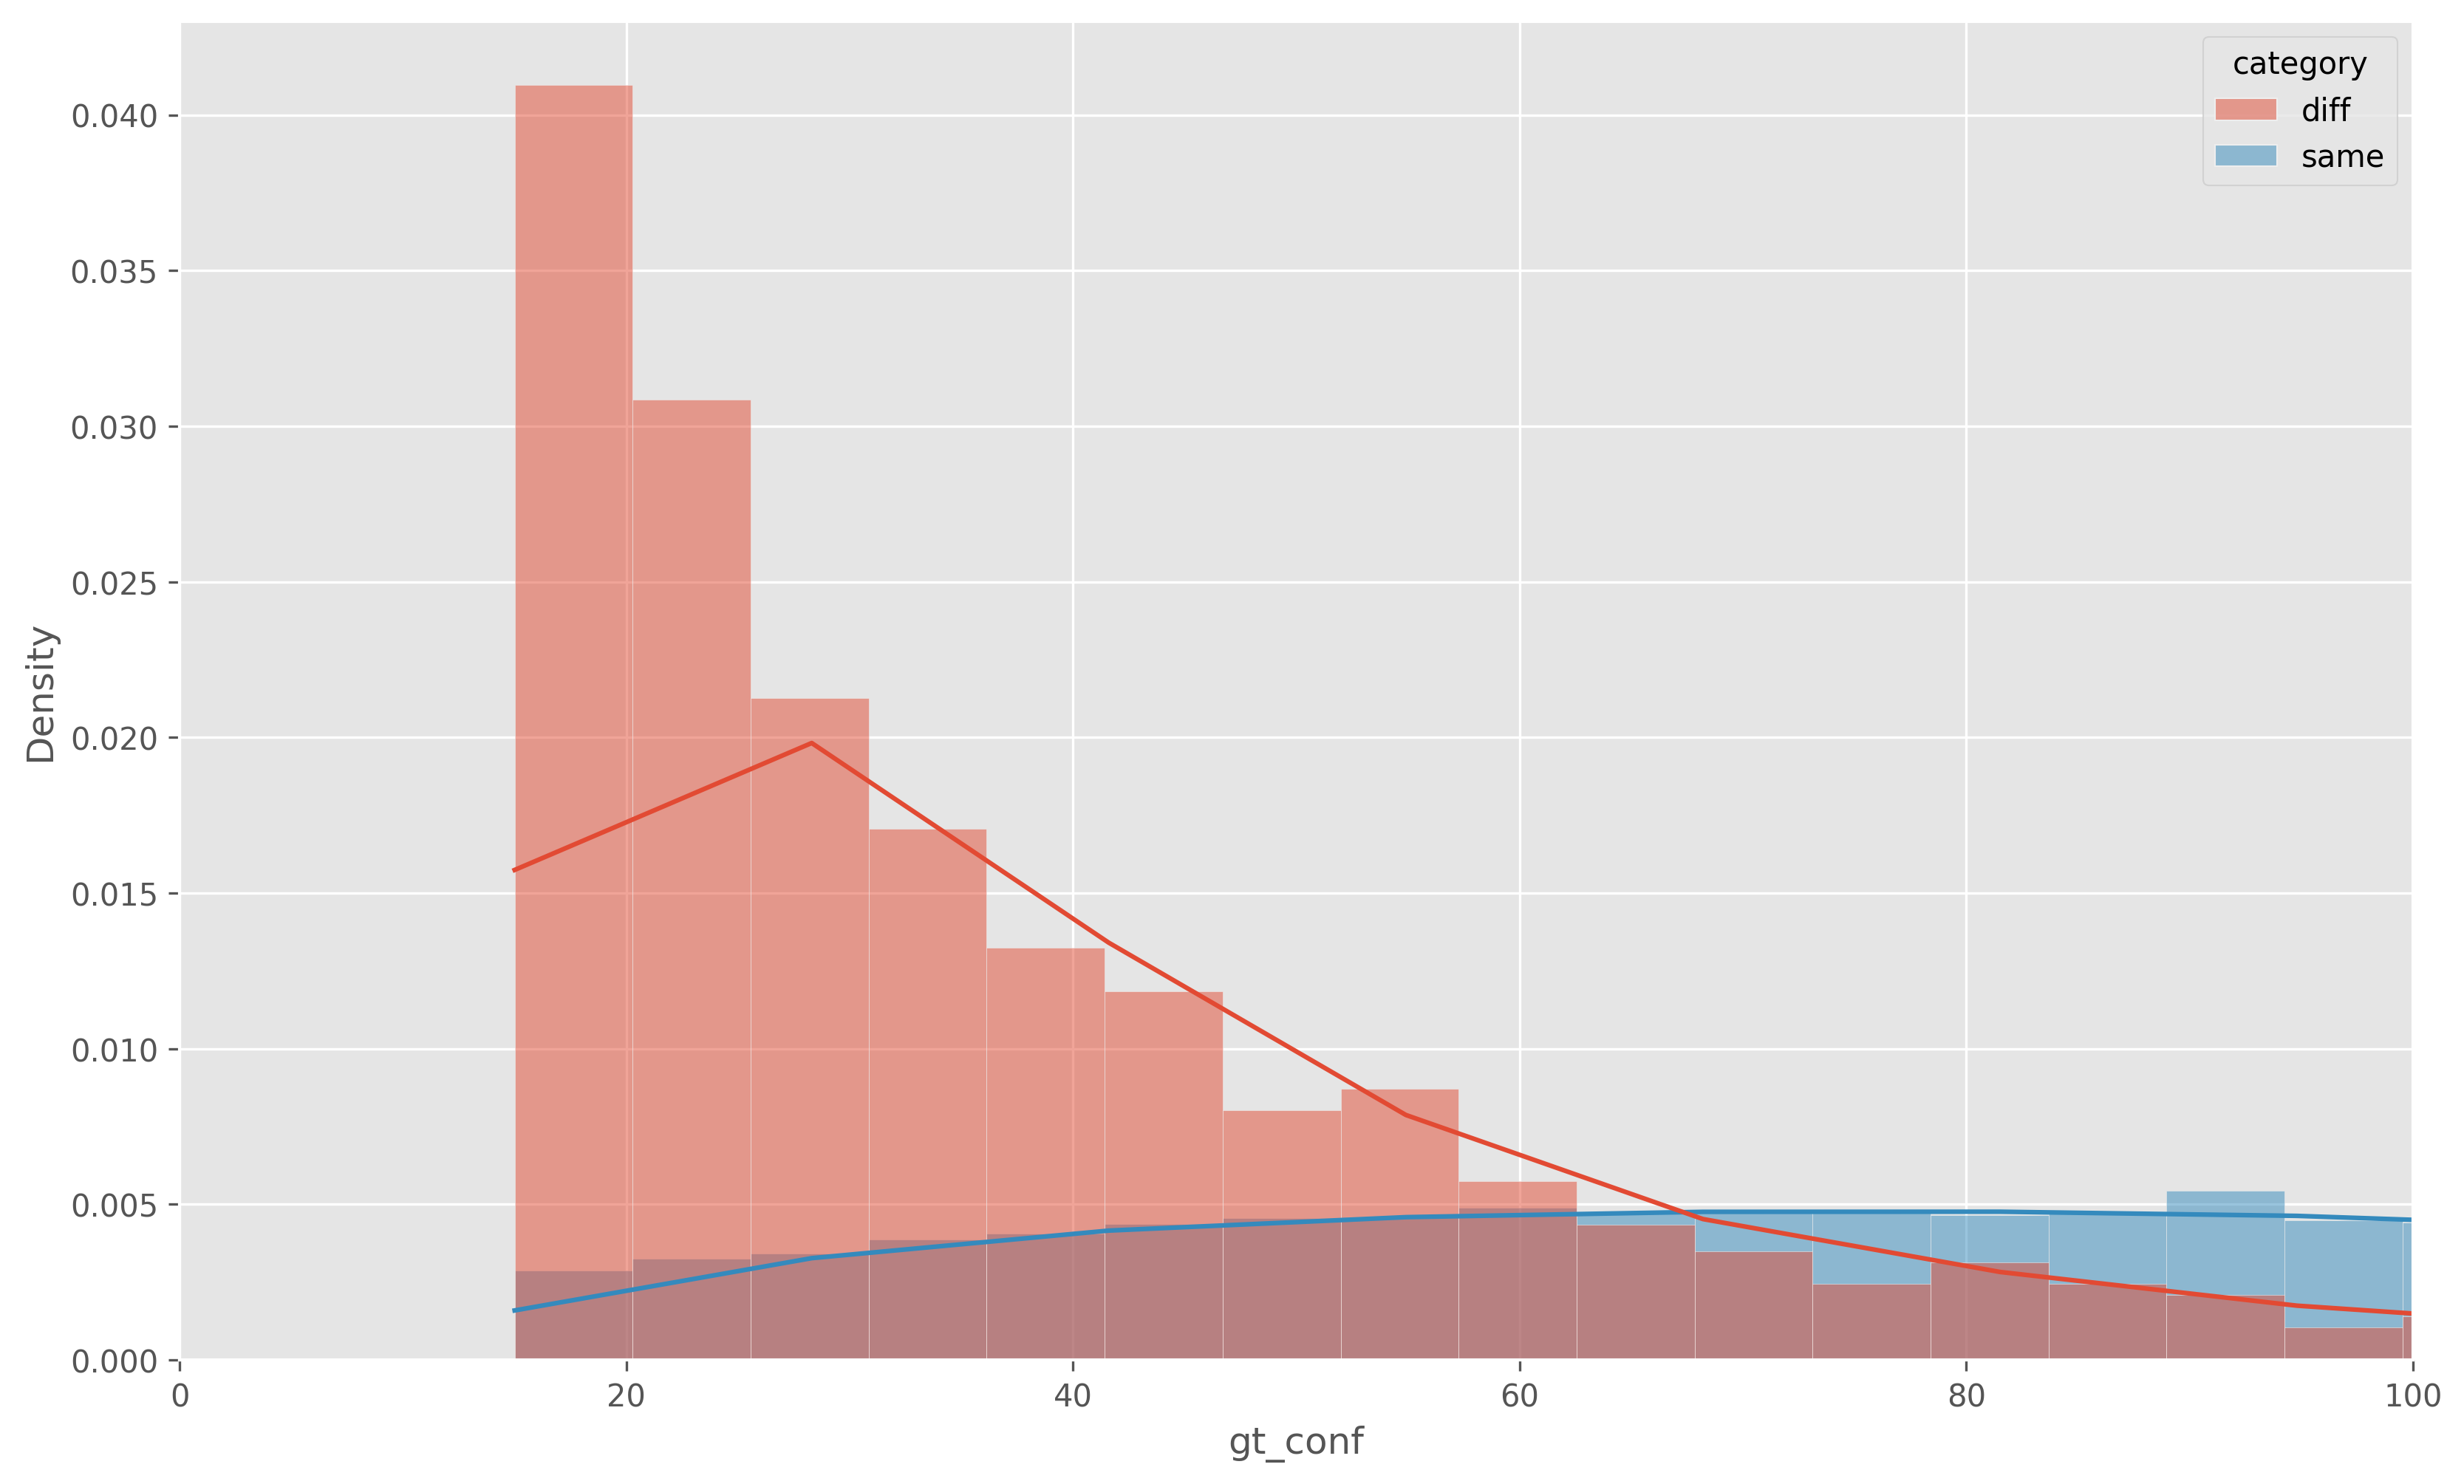

In [162]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="gt_conf", hue="category", ax=ax, common_norm=False, stat="density", kde=True)
ax.set_xlim((0, 100))

### Conclusion

We could indeed remove a large amount of the incorrect calls if we raised the GT_CONF cutoff to ~35 (it is currently set to 15) - but we would lose a many more correct calls. So it depends on how many we are willing to throw away for greater confidence. But I suspect this is the eternal struggle for calling indels with **any** variant caller.

## Coverage (non-SNPs only)

Is there an enrichment for low coverage in the incorrect calls?

In [7]:
class Genotype(NamedTuple):
    allele1: int
    allele2: int

    def is_null(self) -> bool:
        """Is the genotype null. i.e. ./."""
        return self.allele1 == -1 and self.allele2 == -1

    def is_hom(self) -> bool:
        """Is the genotype homozygous"""
        if self.is_null():
            return False
        if self.allele1 == -1 or self.allele2 == -1:
            return True
        return self.allele1 == self.allele2

    def is_het(self) -> bool:
        """Is the genotype heterozyhous"""
        return not self.is_null() and not self.is_hom()

    def is_hom_ref(self) -> bool:
        """Is genotype homozygous reference?"""
        return self.is_hom() and (self.allele1 == 0 or self.allele2 == 0)

    def is_hom_alt(self) -> bool:
        """Is genotype homozygous alternate?"""
        return self.is_hom() and (self.allele1 > 0 or self.allele2 > 0)

    def alt_index(self) -> Optional[int]:
        """If the genotype is homozygous alternate, returns the 0-based index of the
        alt allele in the alternate allele array.
        """
        if not self.is_hom_alt():
            return None
        return max(self.allele1, self.allele2) - 1

    def allele_index(self) -> Optional[int]:
        """The index of the called allele"""
        if self.is_hom_ref() or self.is_null():
            return 0
        elif self.is_hom_alt():
            return self.alt_index() + 1
        else:
            raise NotImplementedError(f"Het Genotype is unexpected: {self}")

    @staticmethod
    def from_arr(arr: List[int]) -> "Genotype":
        alleles = [a for a in arr if type(a) is int]
        if len(alleles) < 2:
            alleles.append(-1)
        return Genotype(*alleles)

@dataclass
class Strand:
    forward_covg: int = 0
    reverse_covg: int = 0

    @property
    def ratio(self) -> float:
        try:
            return min(self.covgs) / sum(self.covgs)
        except ZeroDivisionError:
            return 1.0

    @property
    def covgs(self) -> Tuple[int, int]:
        return self.forward_covg, self.reverse_covg

    @staticmethod
    def from_variant(variant: Variant, sample_idx: int = 0) -> "Strand":
        gt_idx = Genotype.from_arr(variant.genotypes[sample_idx]).allele_index()
        fwd_covg = variant.format("MEAN_FWD_COVG")[sample_idx][gt_idx]
        rev_covg = variant.format("MEAN_REV_COVG")[sample_idx][gt_idx]

        return Strand(fwd_covg, rev_covg)
    
def get_covg(variant: Variant, sample_idx: int = 0) -> int:
    strand = Strand.from_variant(variant, sample_idx=sample_idx)
    return sum(strand.covgs)

COVG = {
    "mada_1-25": 53.89,
    "mada_2-25": 99.01,
    "mada_109": 150,
    "mada_120": 150,
    "mada_1-46": 39.06,
    "mada_2-46": 108.35
}

SAMPLE_IDX = {
    "mada_1-25": 0,
    "mada_2-25": 1,
    "mada_109": 0,
    "mada_120": 1,
    "mada_1-46": 0,
    "mada_2-46": 1
}

In [196]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        var_type = variant_type(v)
        if var_type != "non-snp":
            continue
        for sample in pair.split("x"):
            covg = get_covg(v, SAMPLE_IDX[sample])
            exp_cov = COVG[sample] 
            data.append((pair, cat, covg, covg/exp_cov))

In [197]:
df = pd.DataFrame(data, columns=["pair", "category", "covg", "exp_covg"])

(0, 150)

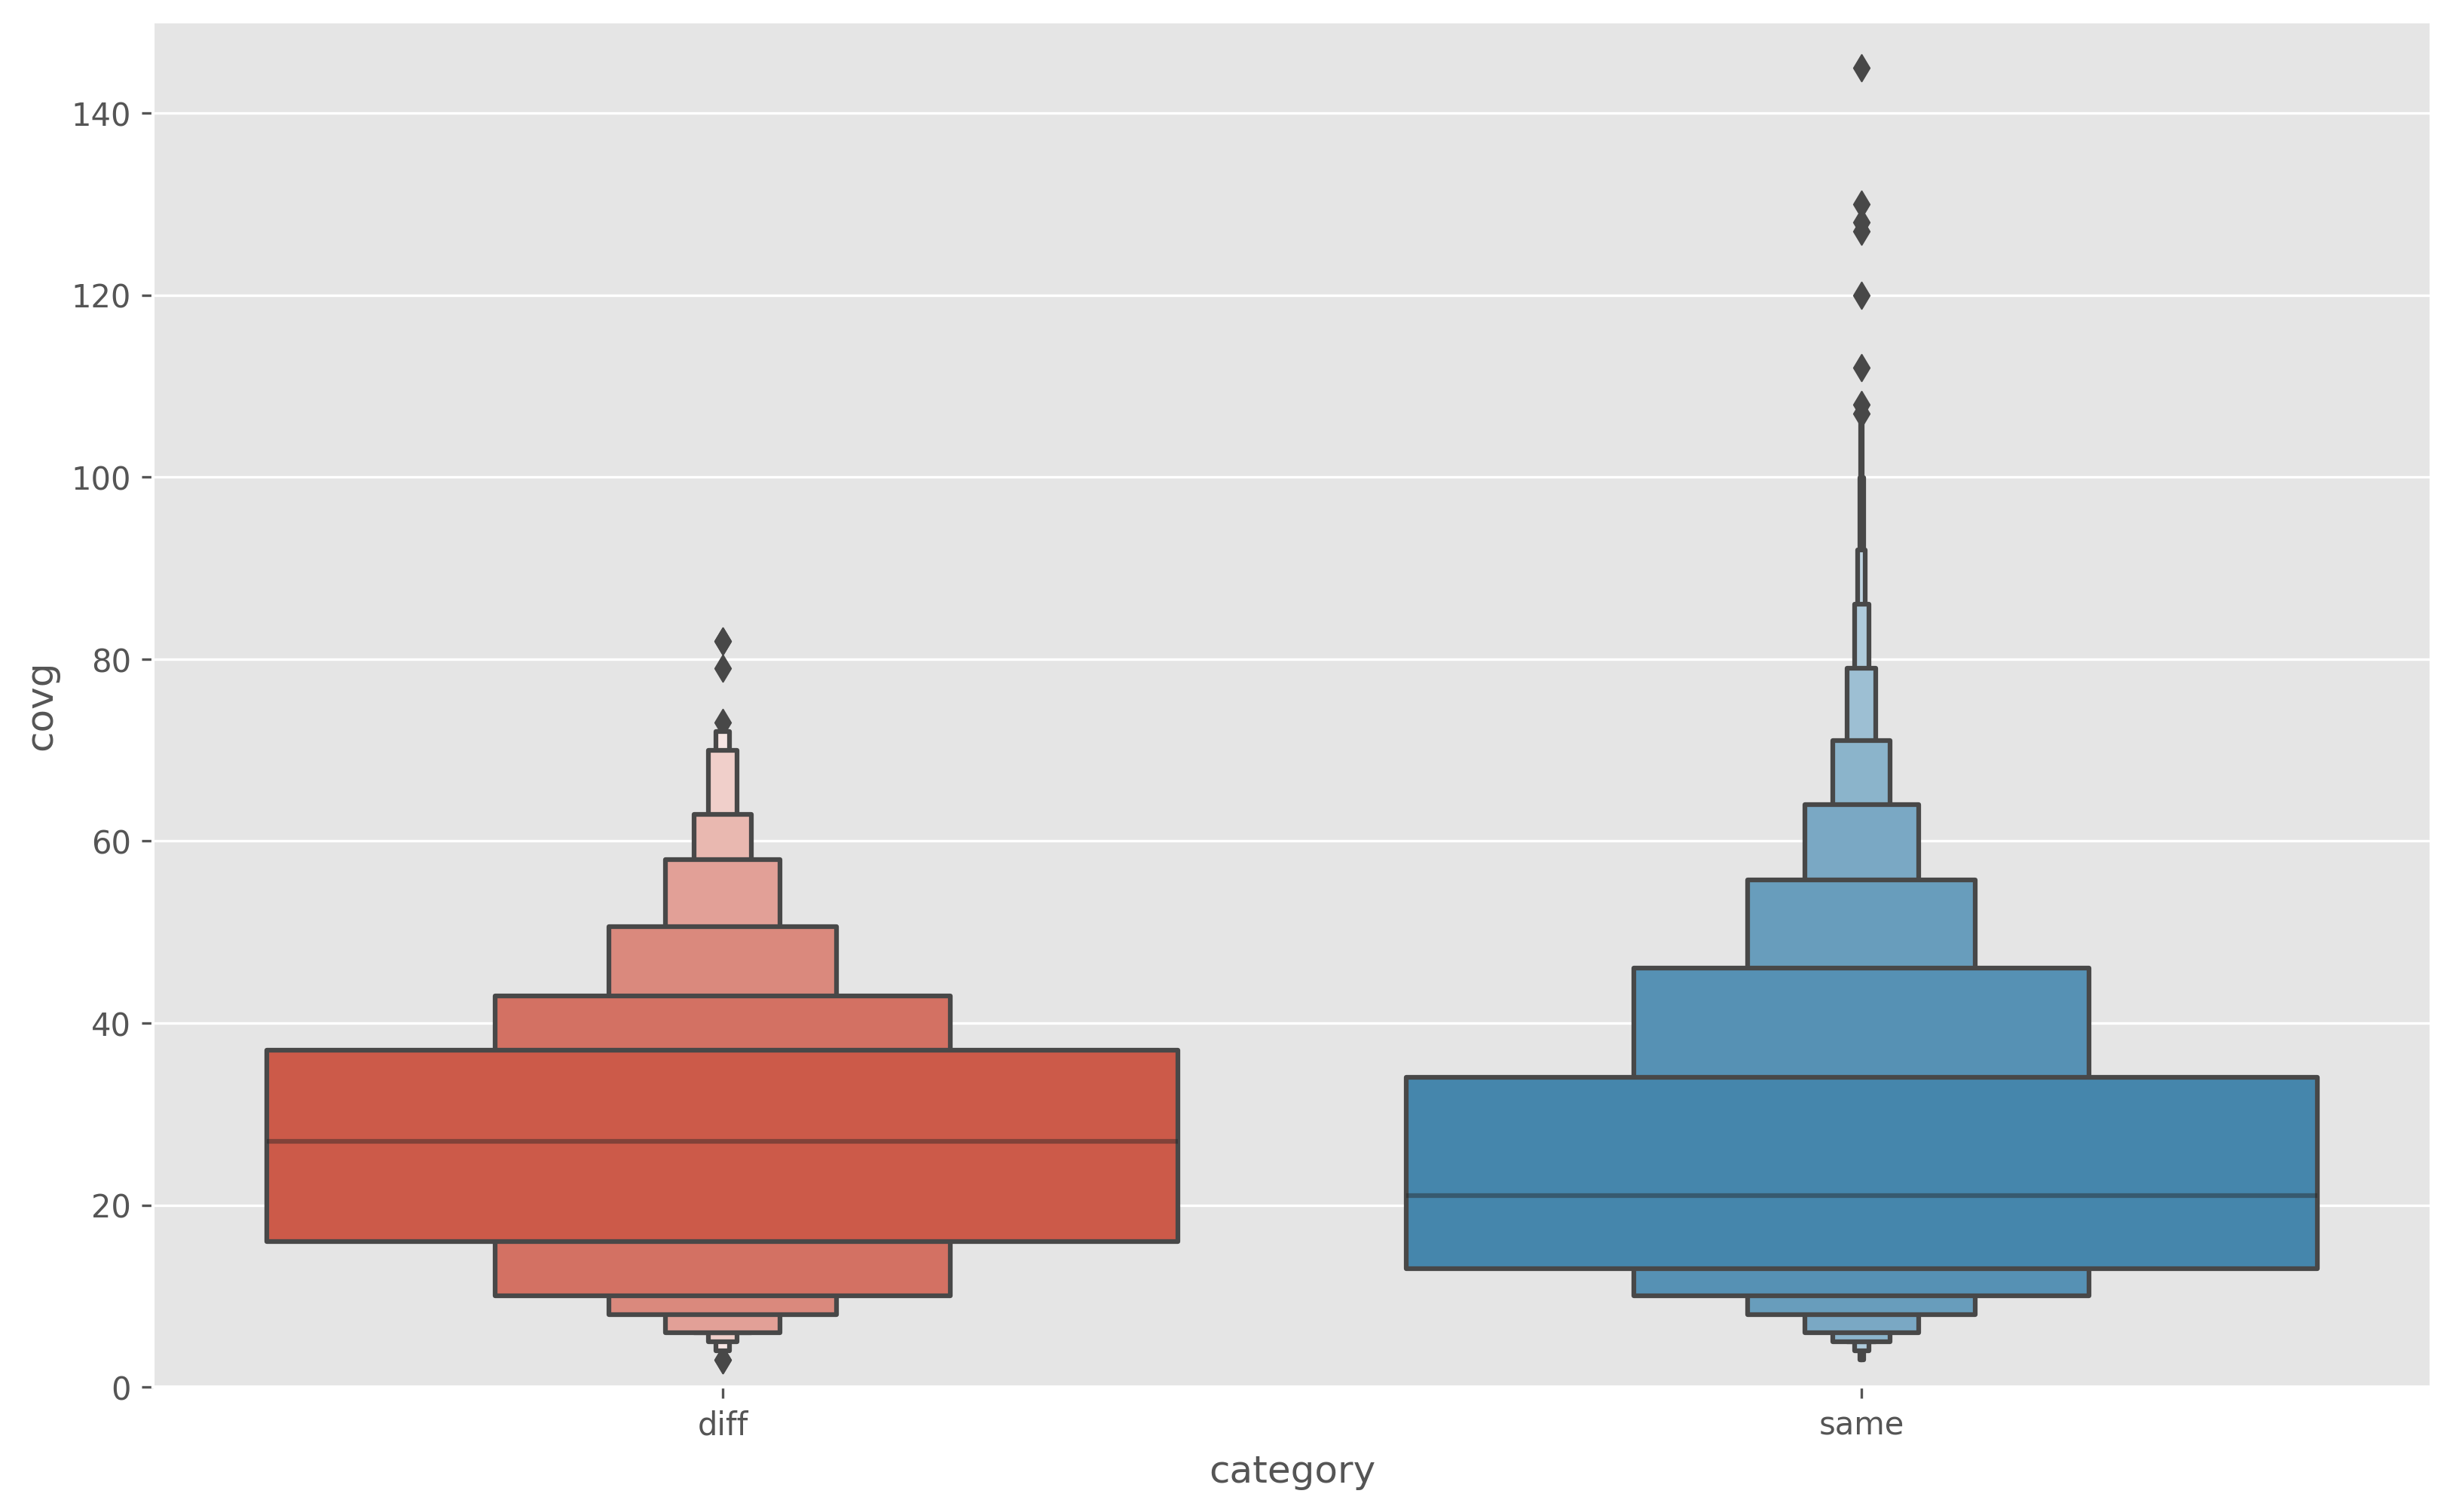

In [198]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="covg", x="category", ax=ax)
ax.set_ylim((0, 150))

What about if we make the coverage a percentage of the expected coverage for the sample?

(0, 1)

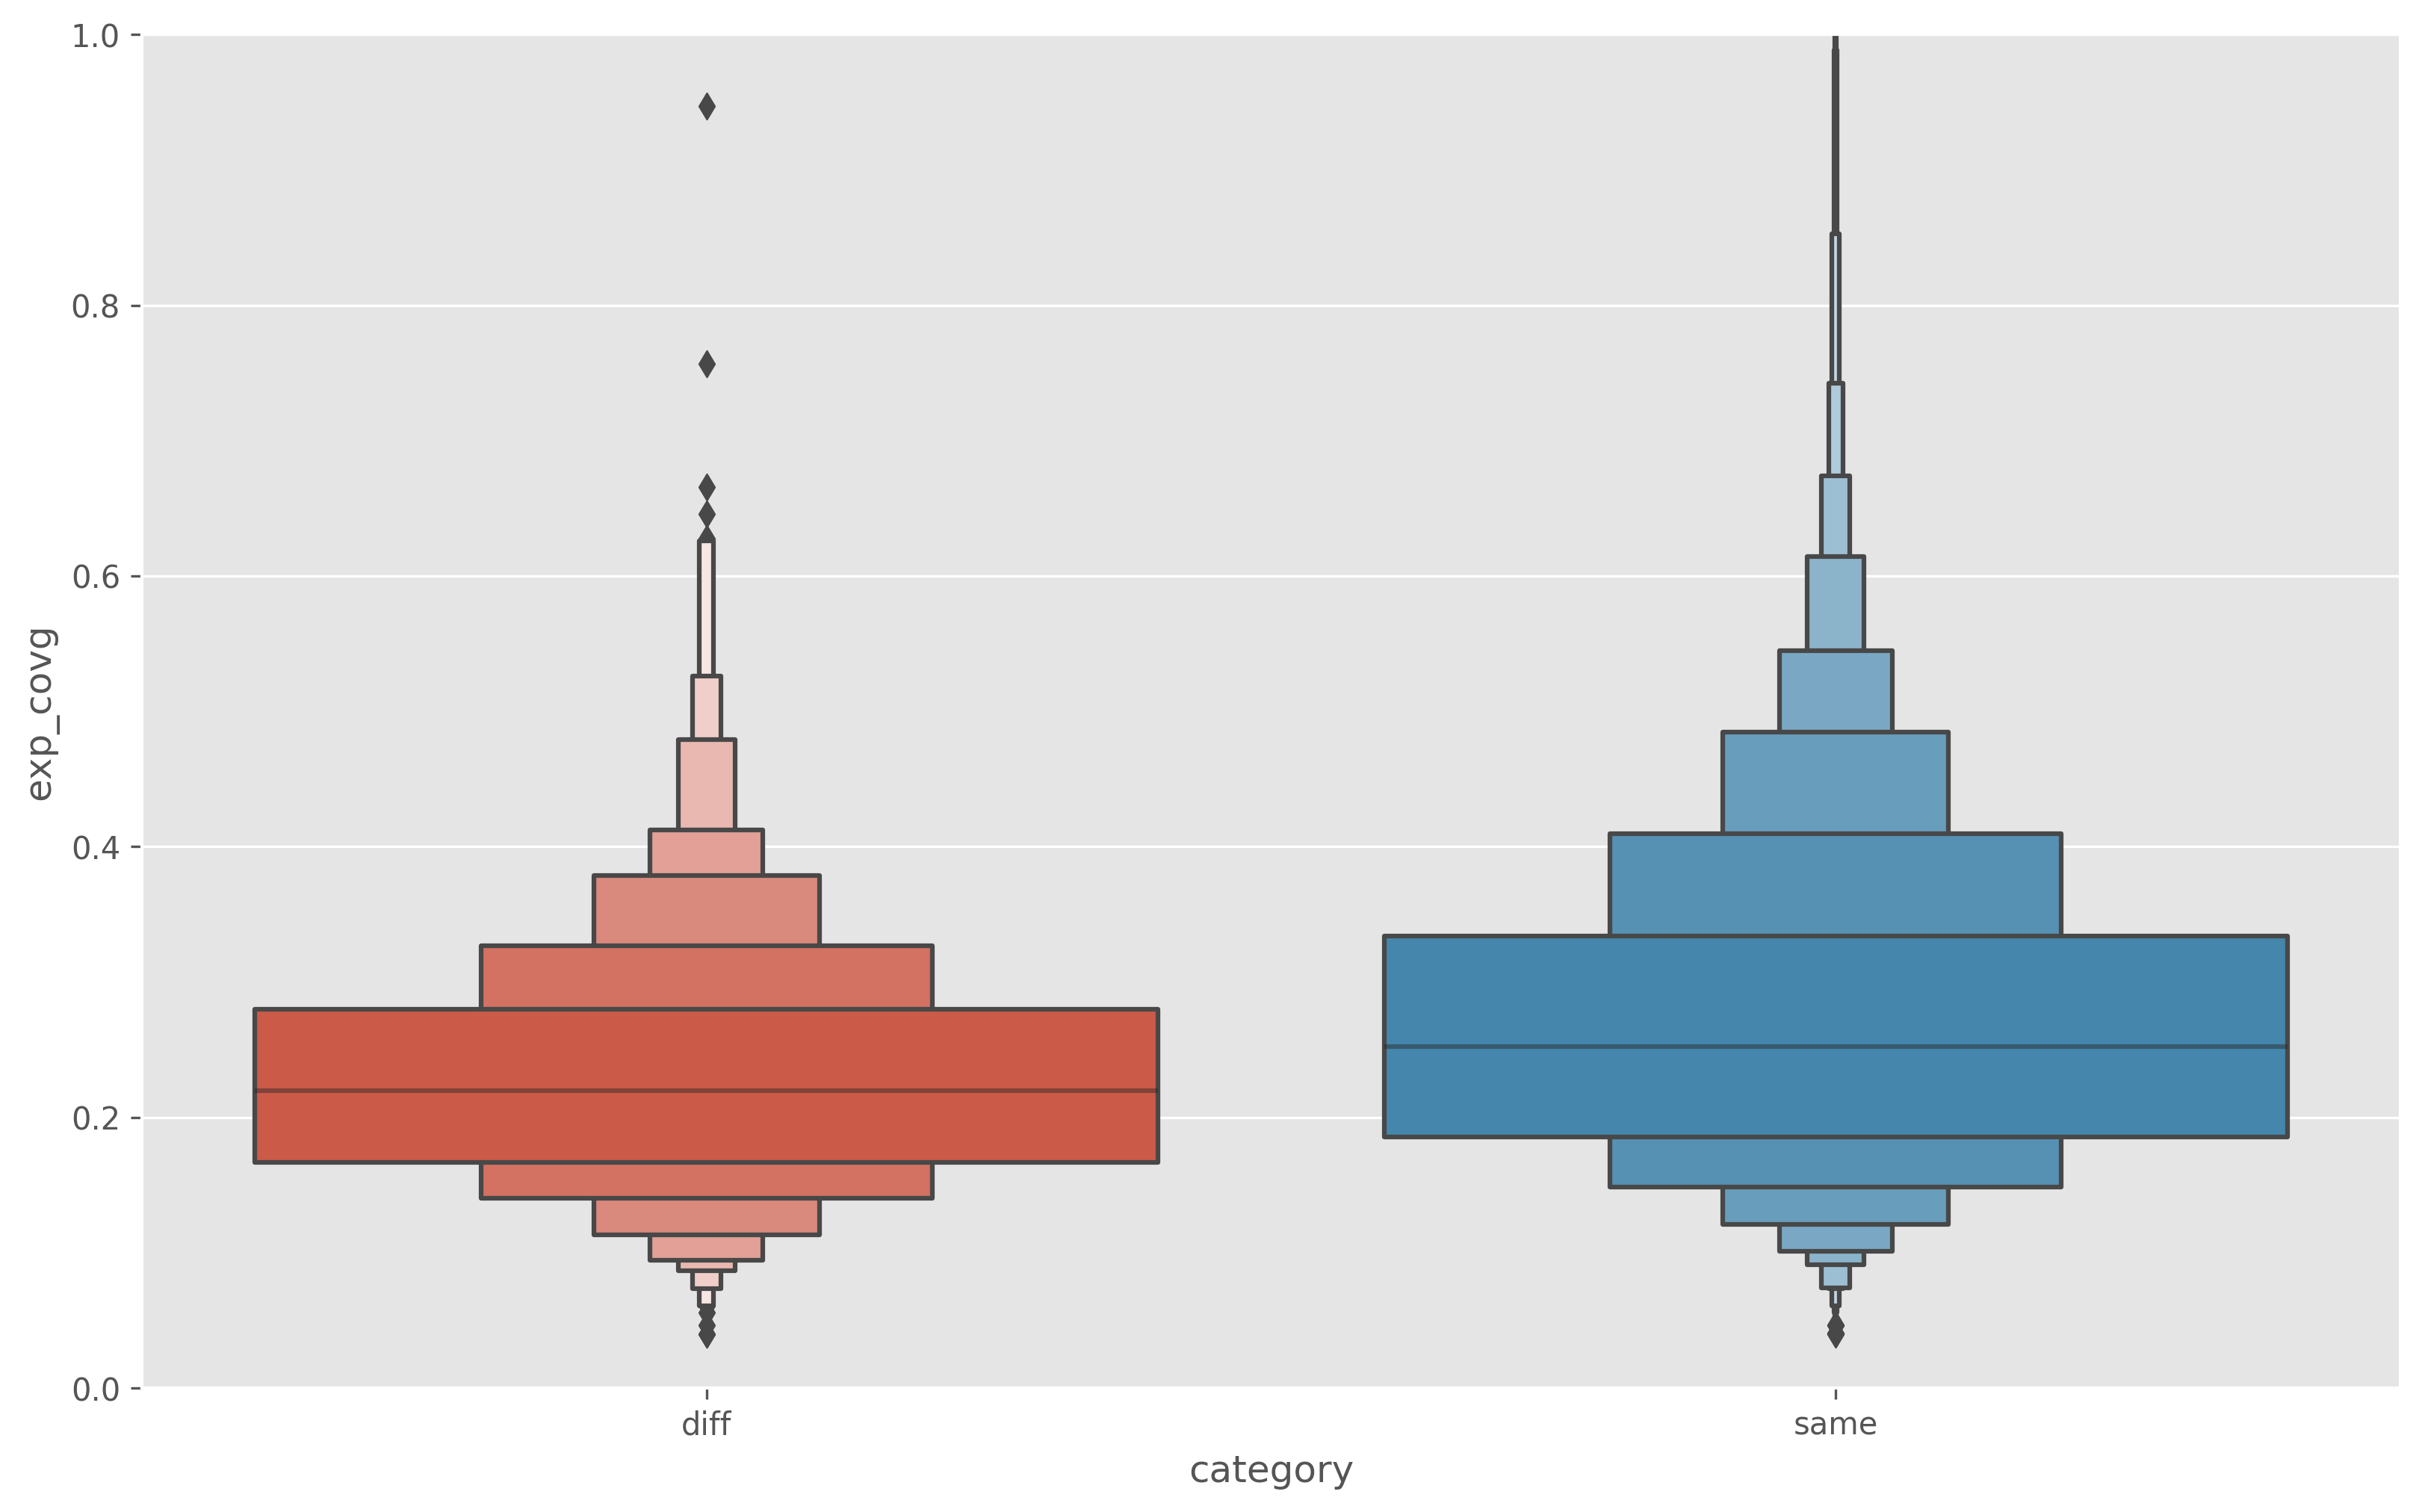

In [199]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="exp_covg", x="category", ax=ax)
ax.set_ylim((0, 1))

(0, 1)

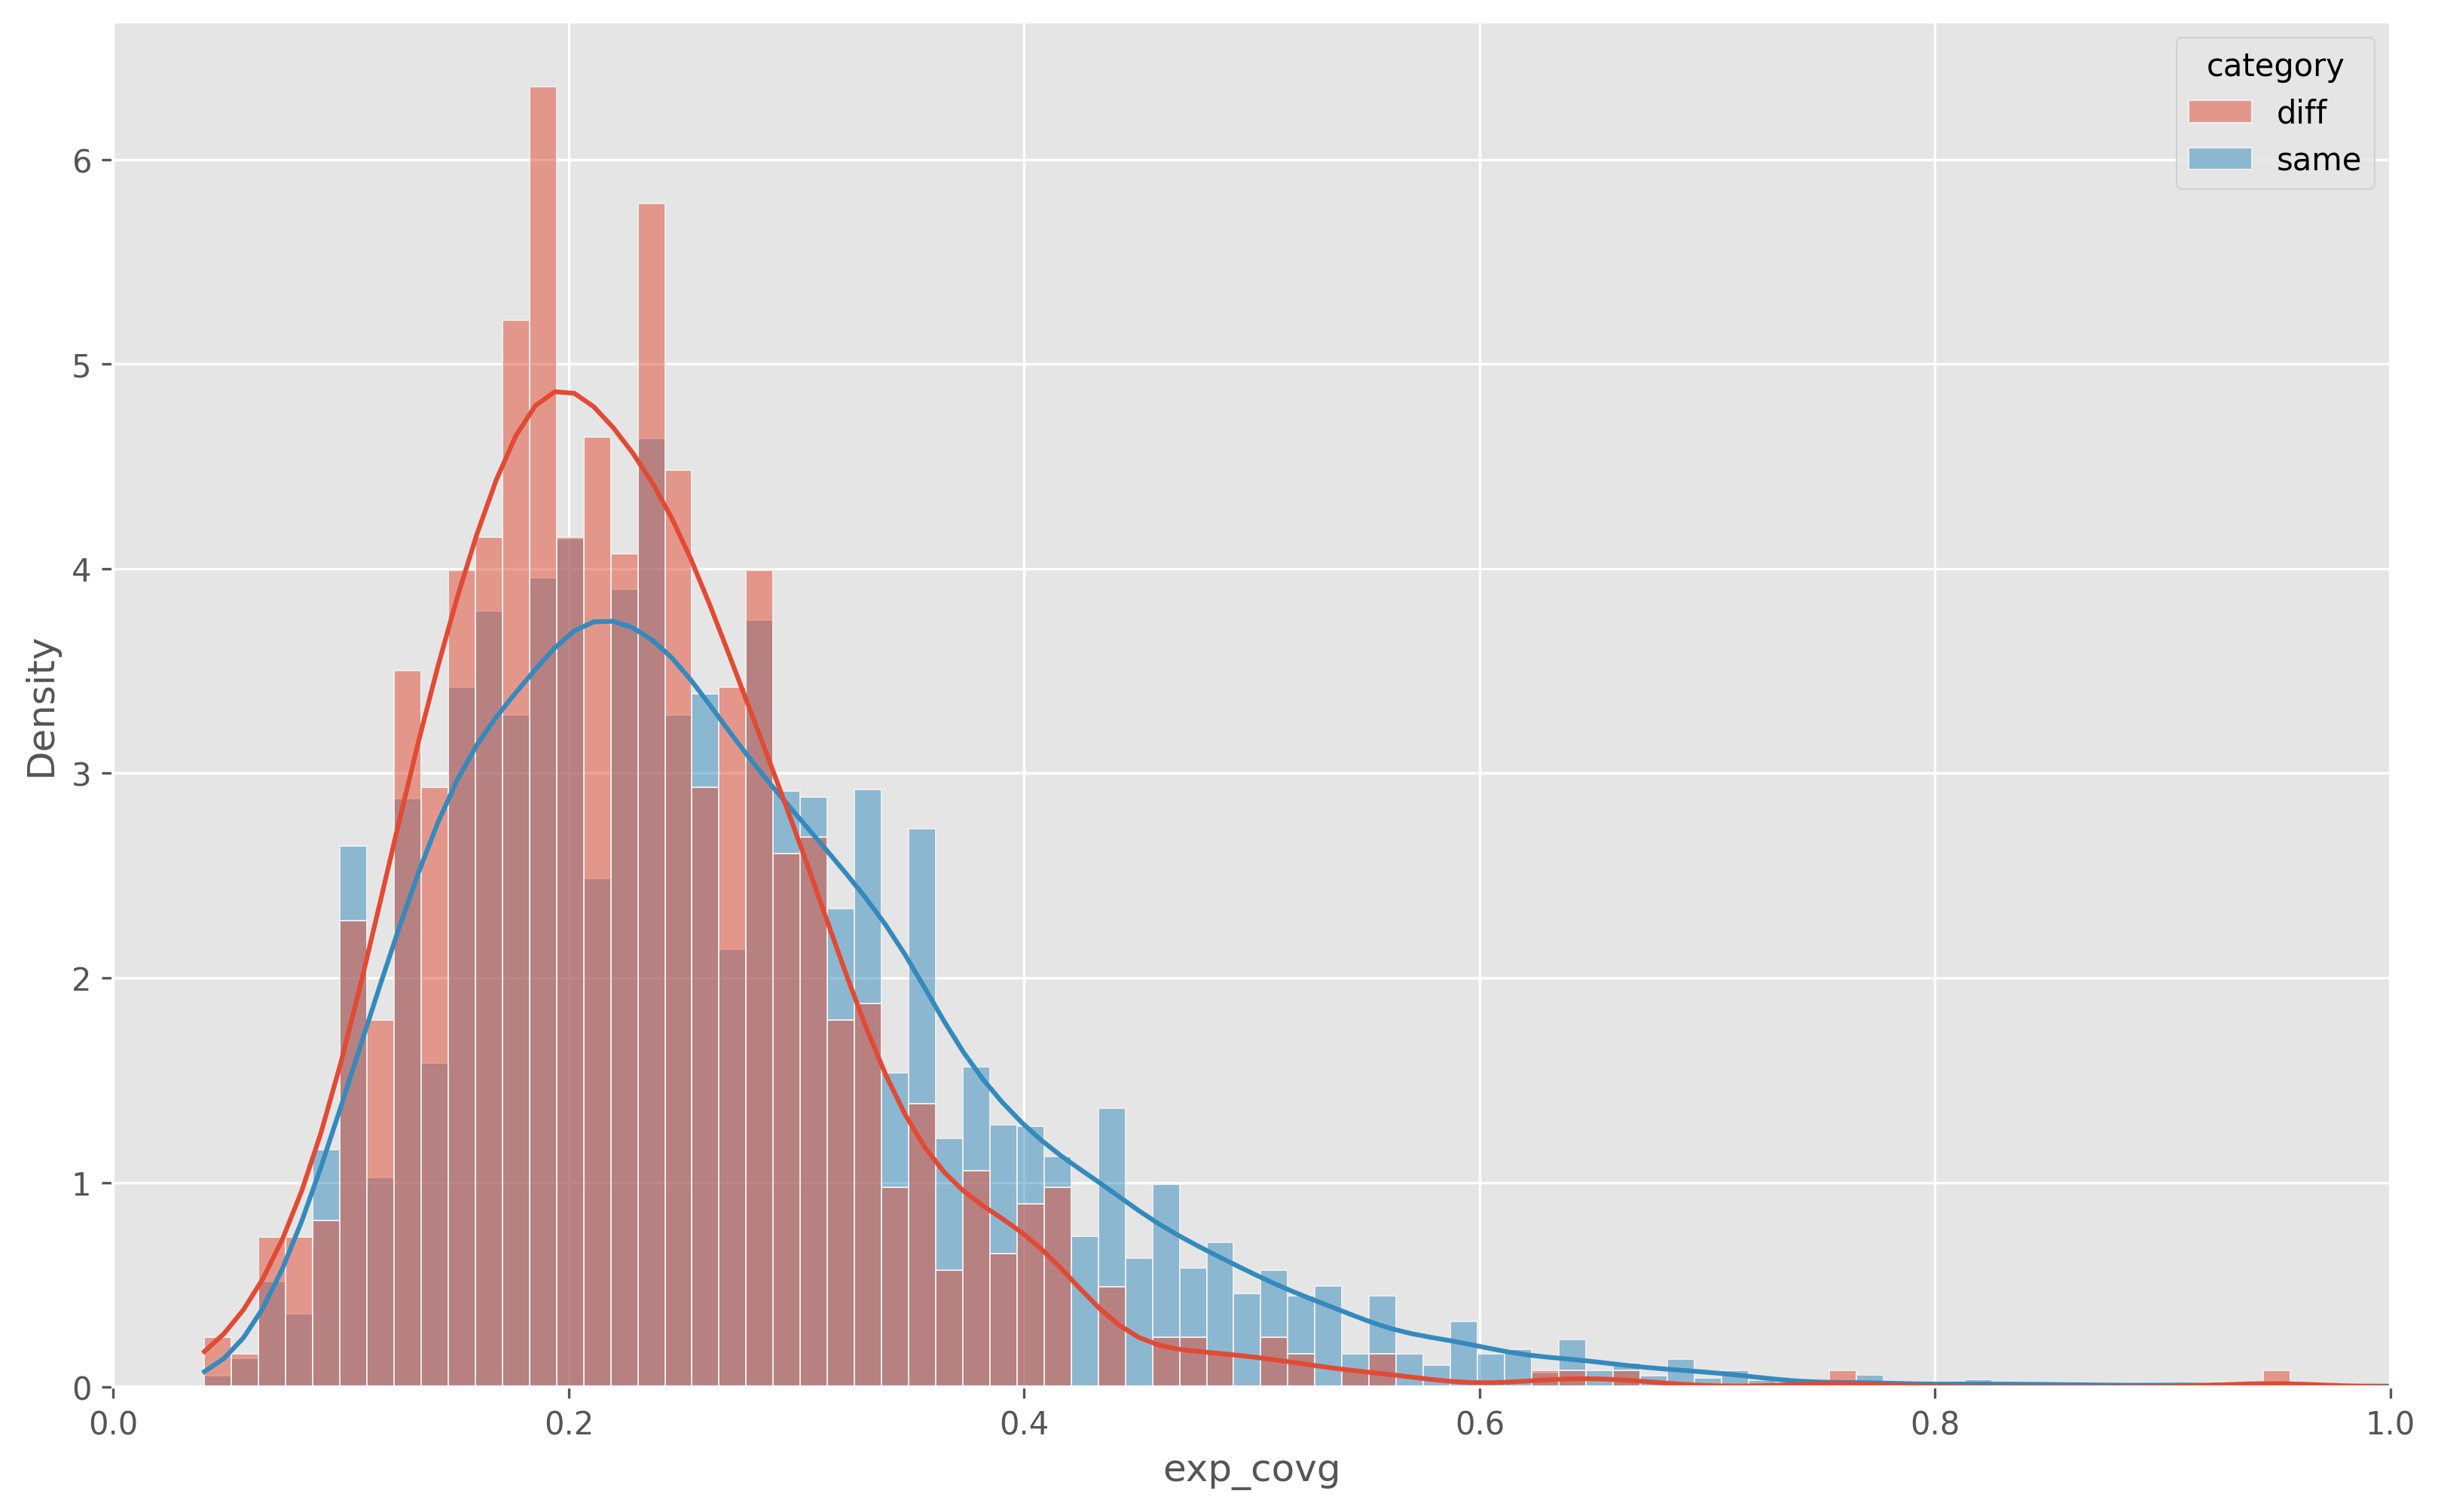

In [200]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="exp_covg", hue="category", ax=ax, common_norm=False, stat="density", kde=True)
ax.set_xlim((0, 1))

(0, 1)

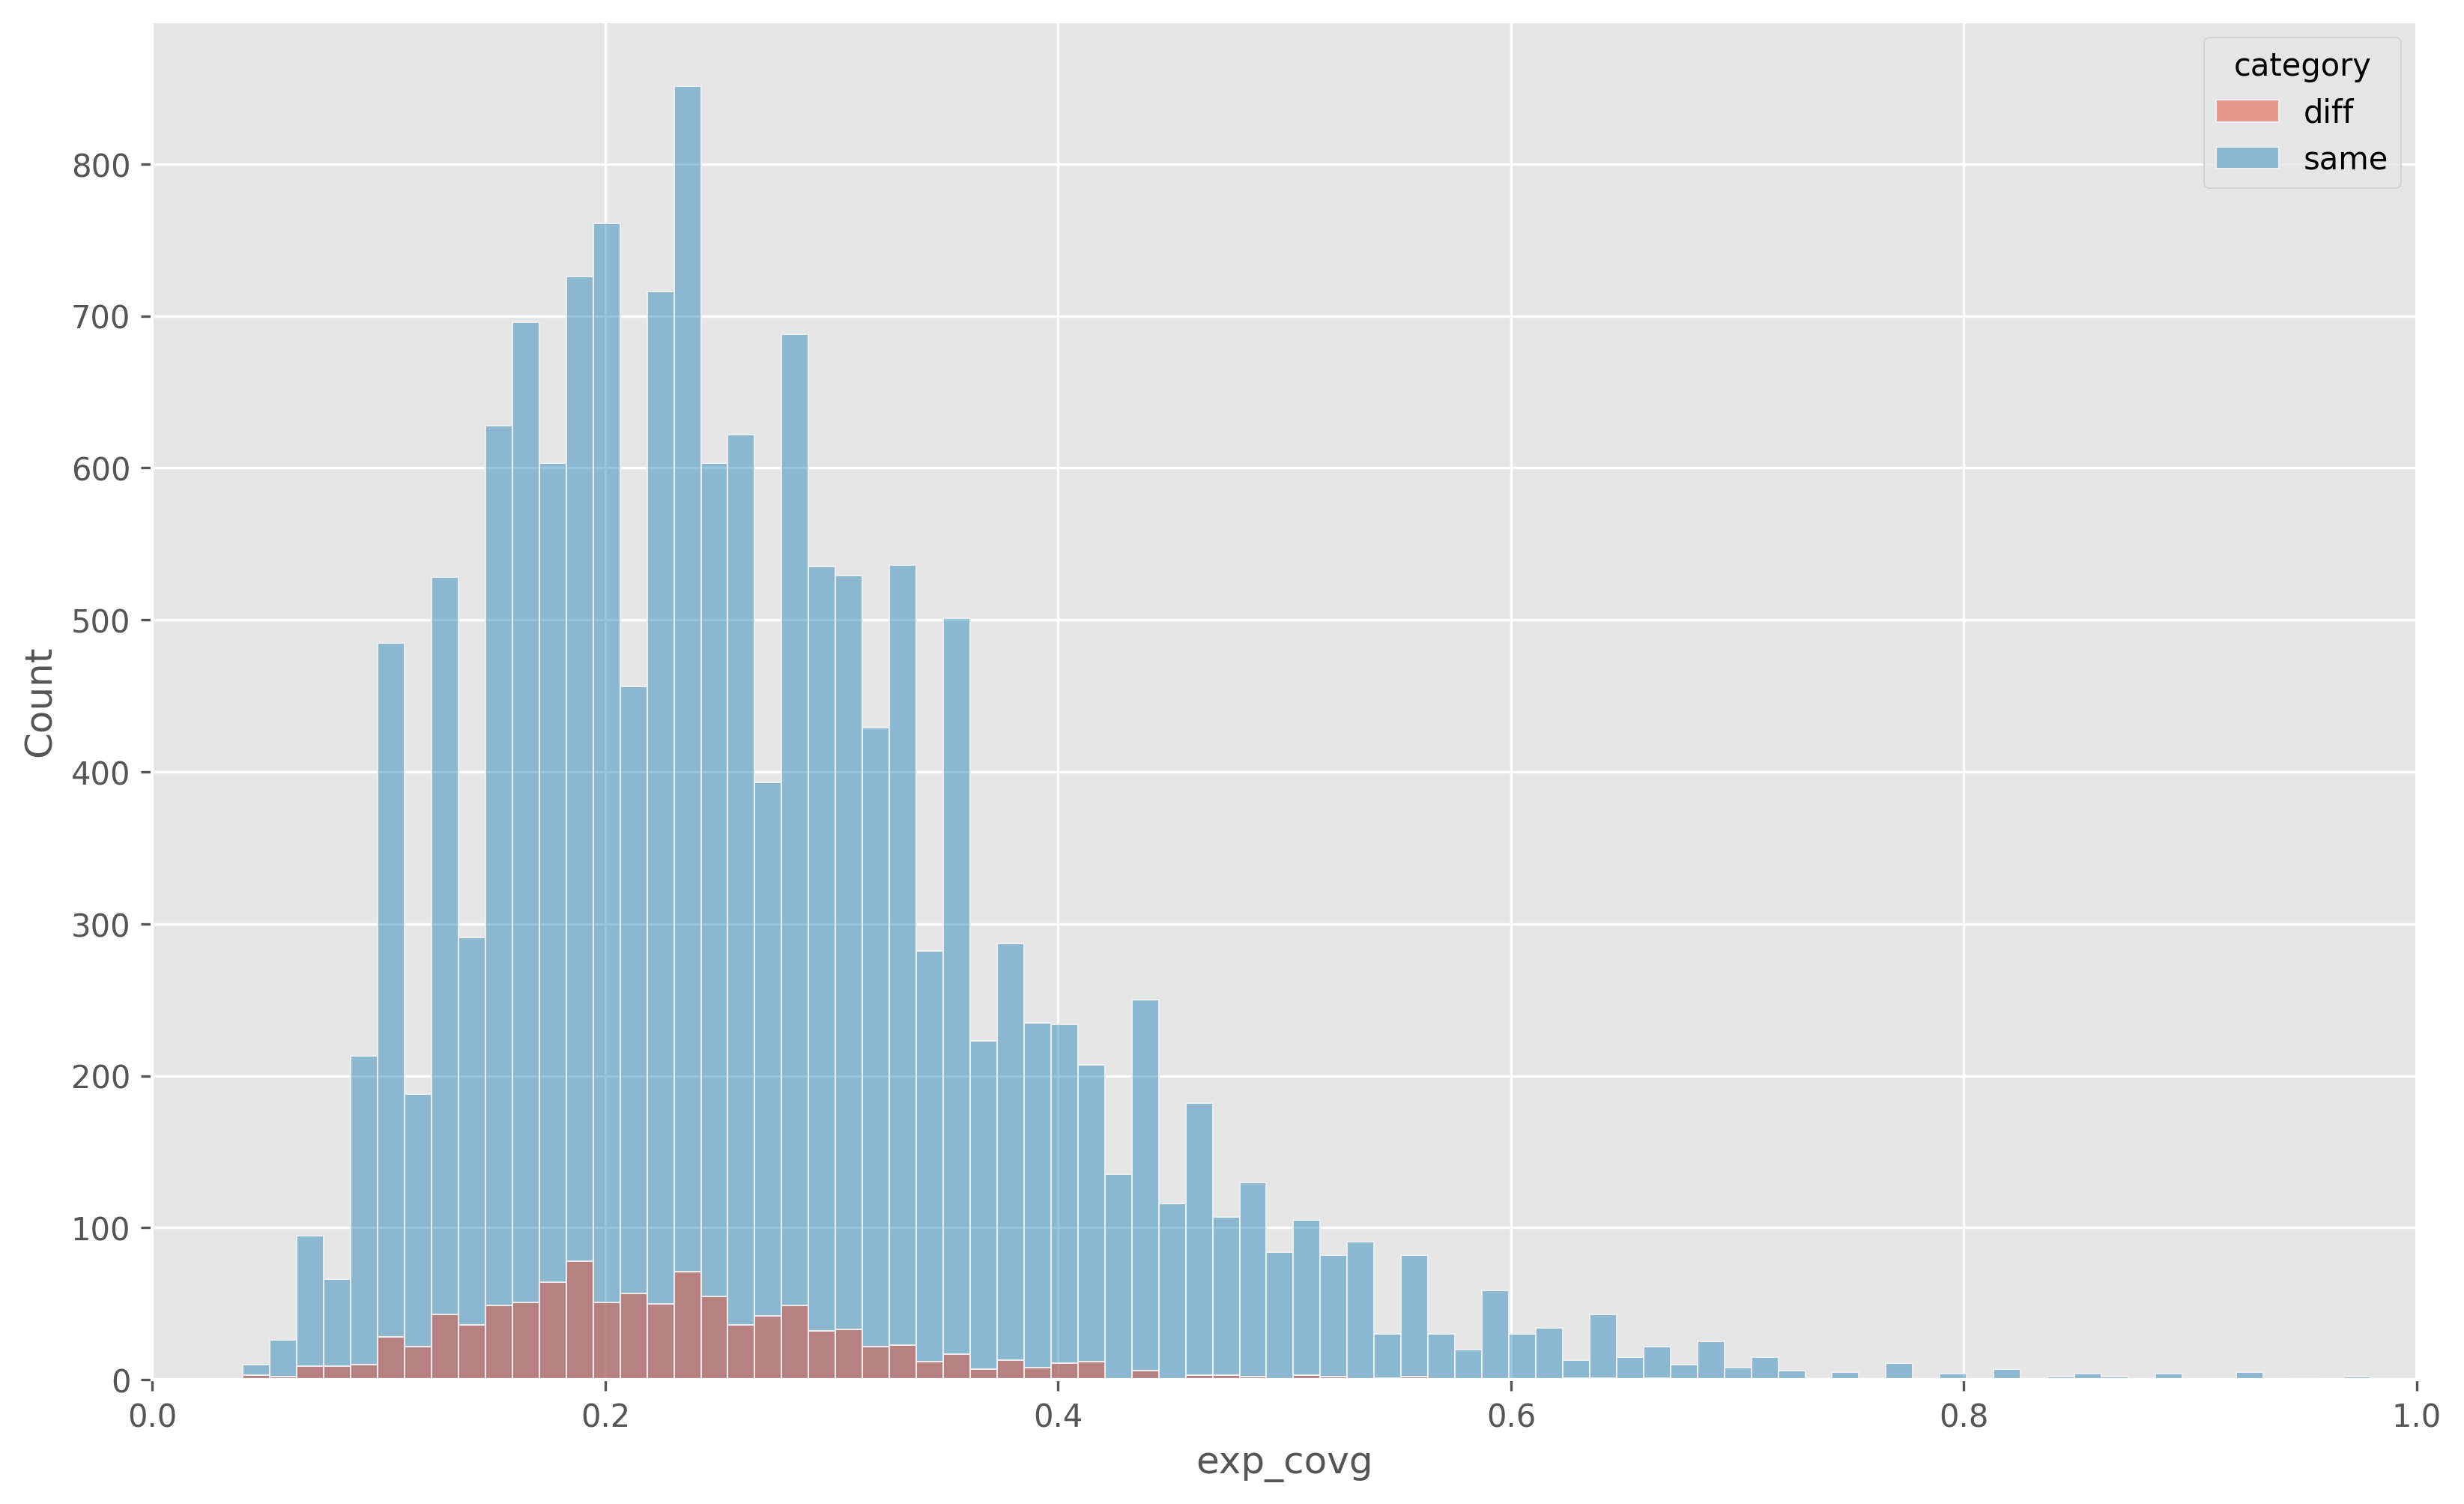

In [201]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="exp_covg", hue="category", ax=ax)
ax.set_xlim((0, 1))

### Conclusion

There doesn't seem to be a clear signal that would suggest coverage plays a part in the incorrect calls.

## Strand bias (non-SNPs only)

In [8]:
def get_bias(variant: Variant, sample_idx: int=0) -> float:
    strand = Strand.from_variant(variant, sample_idx=sample_idx)
    return strand.ratio

In [203]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        var_type = variant_type(v)
        if var_type != "non-snp":
            continue
        for sample in pair.split("x"):
            bias = get_bias(v, SAMPLE_IDX[sample])
            data.append((pair, cat, bias))

In [204]:
df = pd.DataFrame(data, columns=["pair", "category", "bias"])

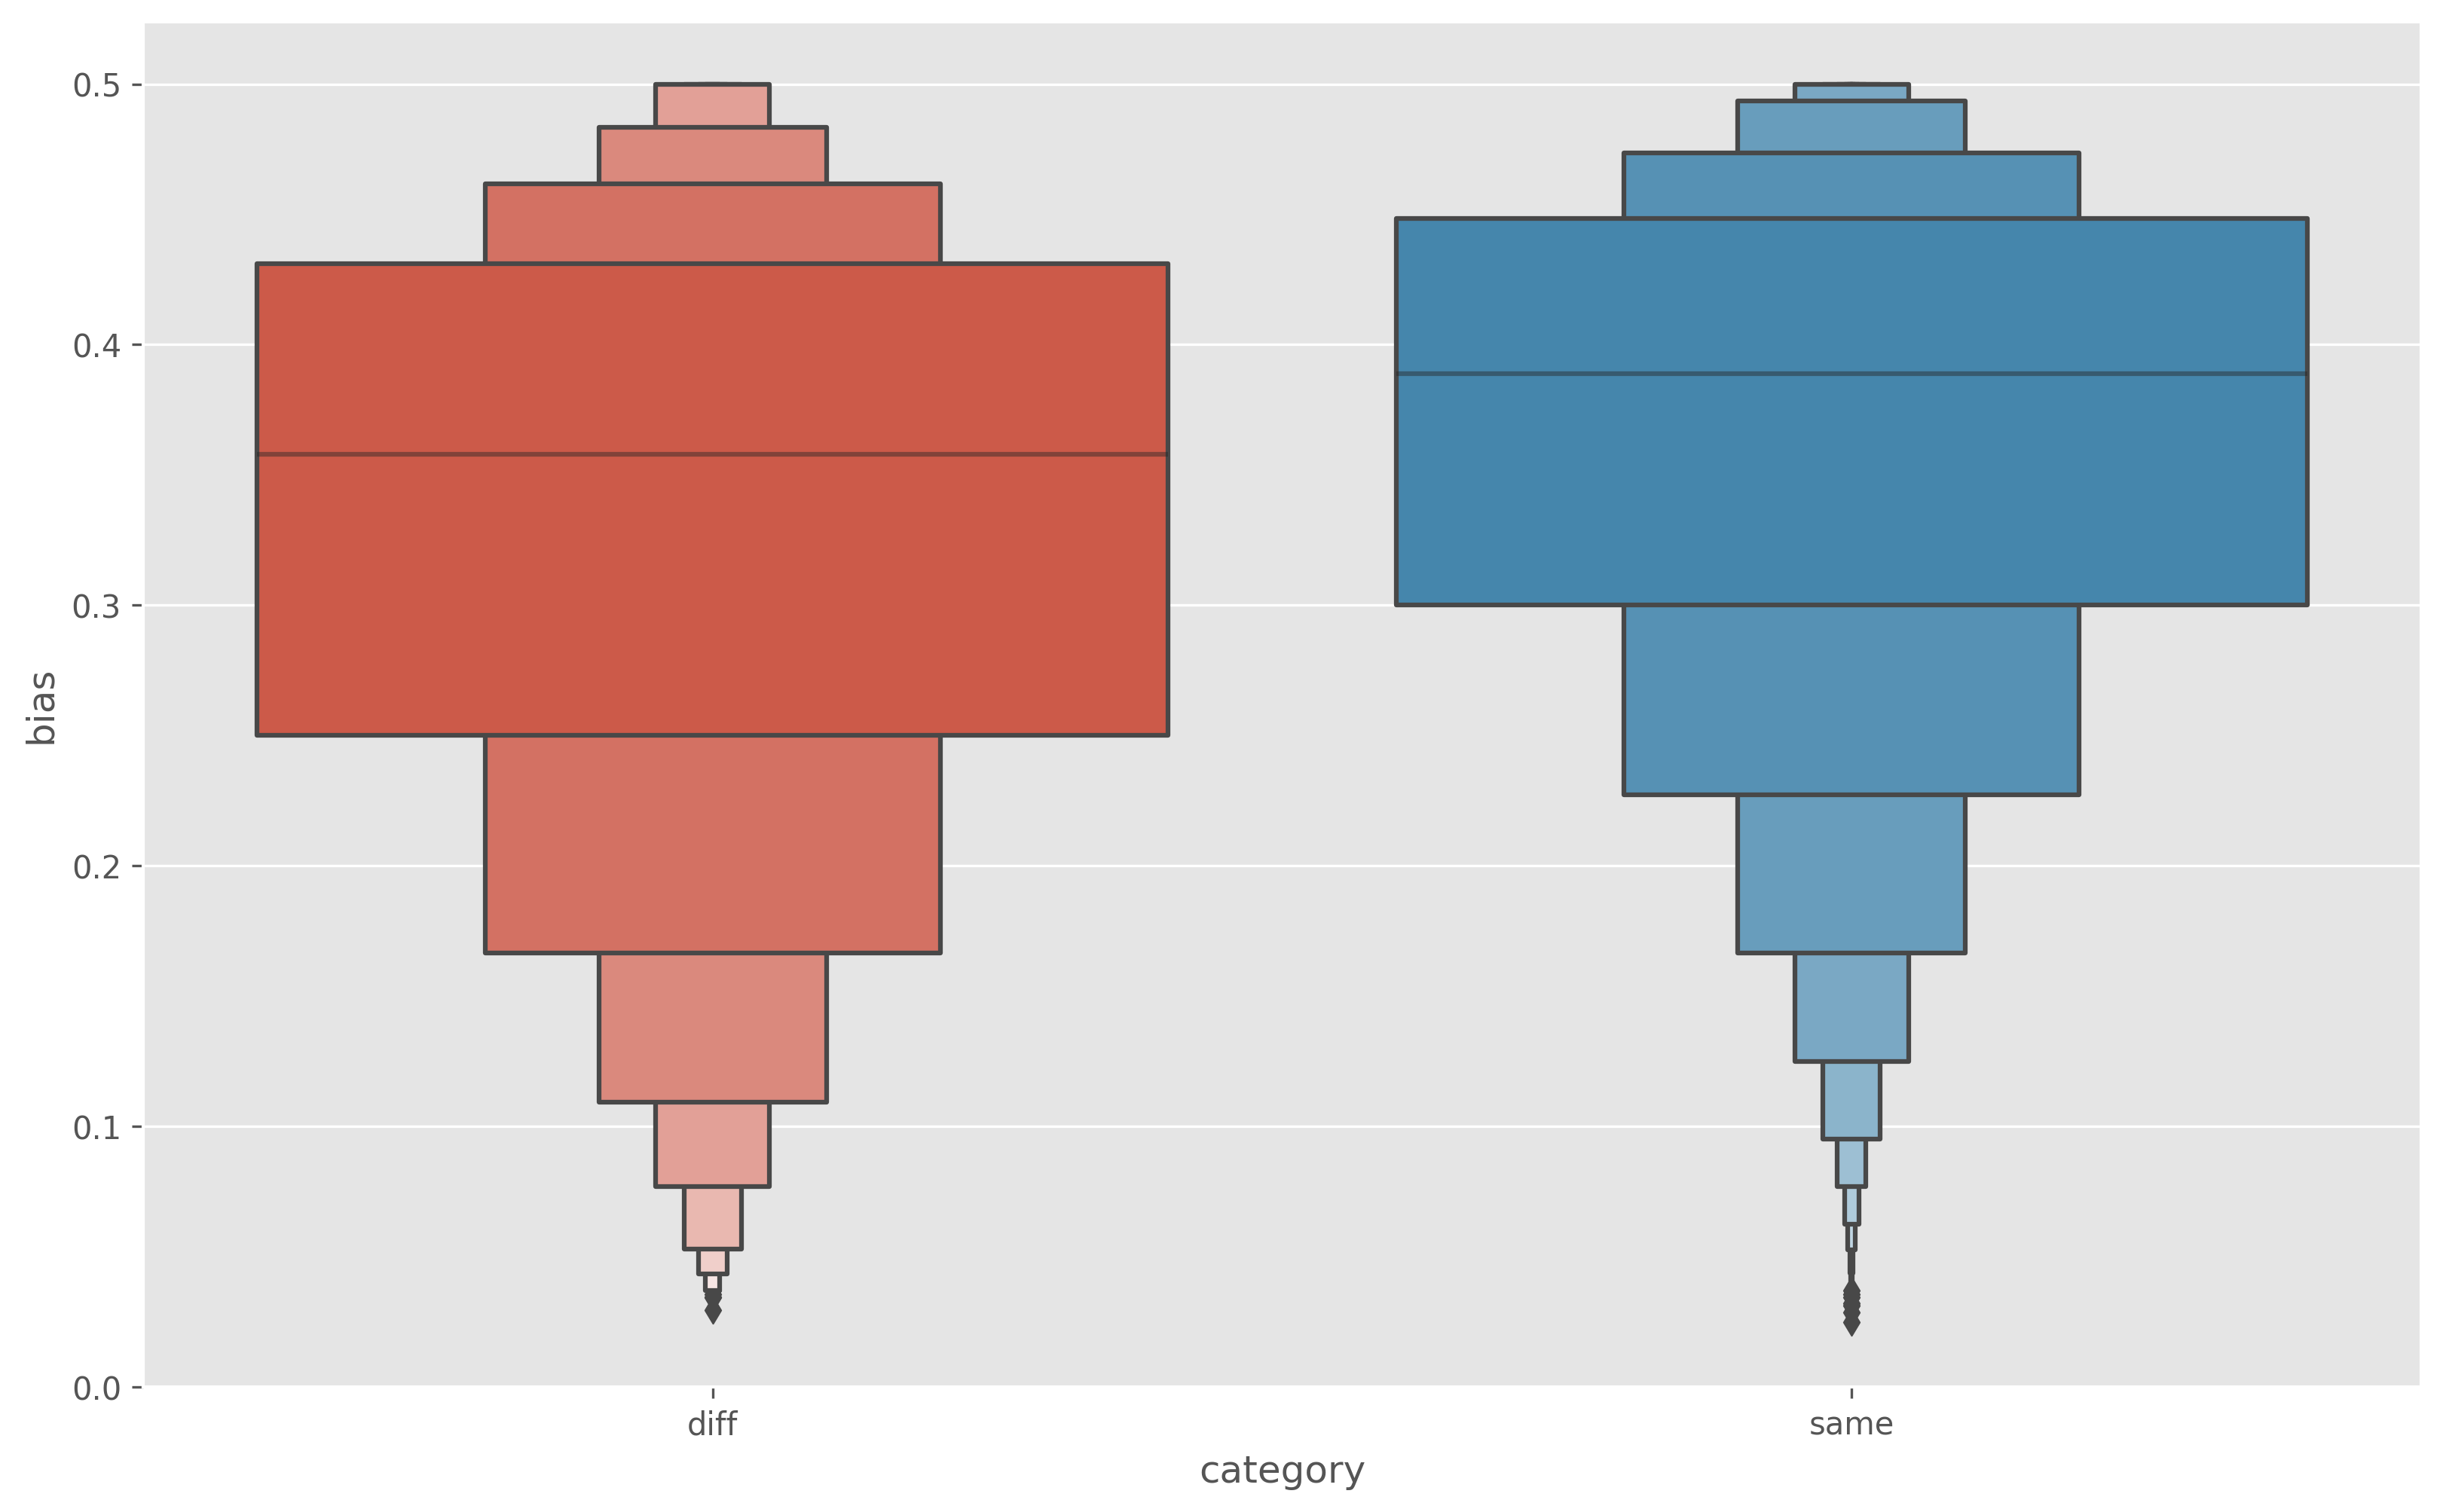

In [206]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="bias", x="category", ax=ax)

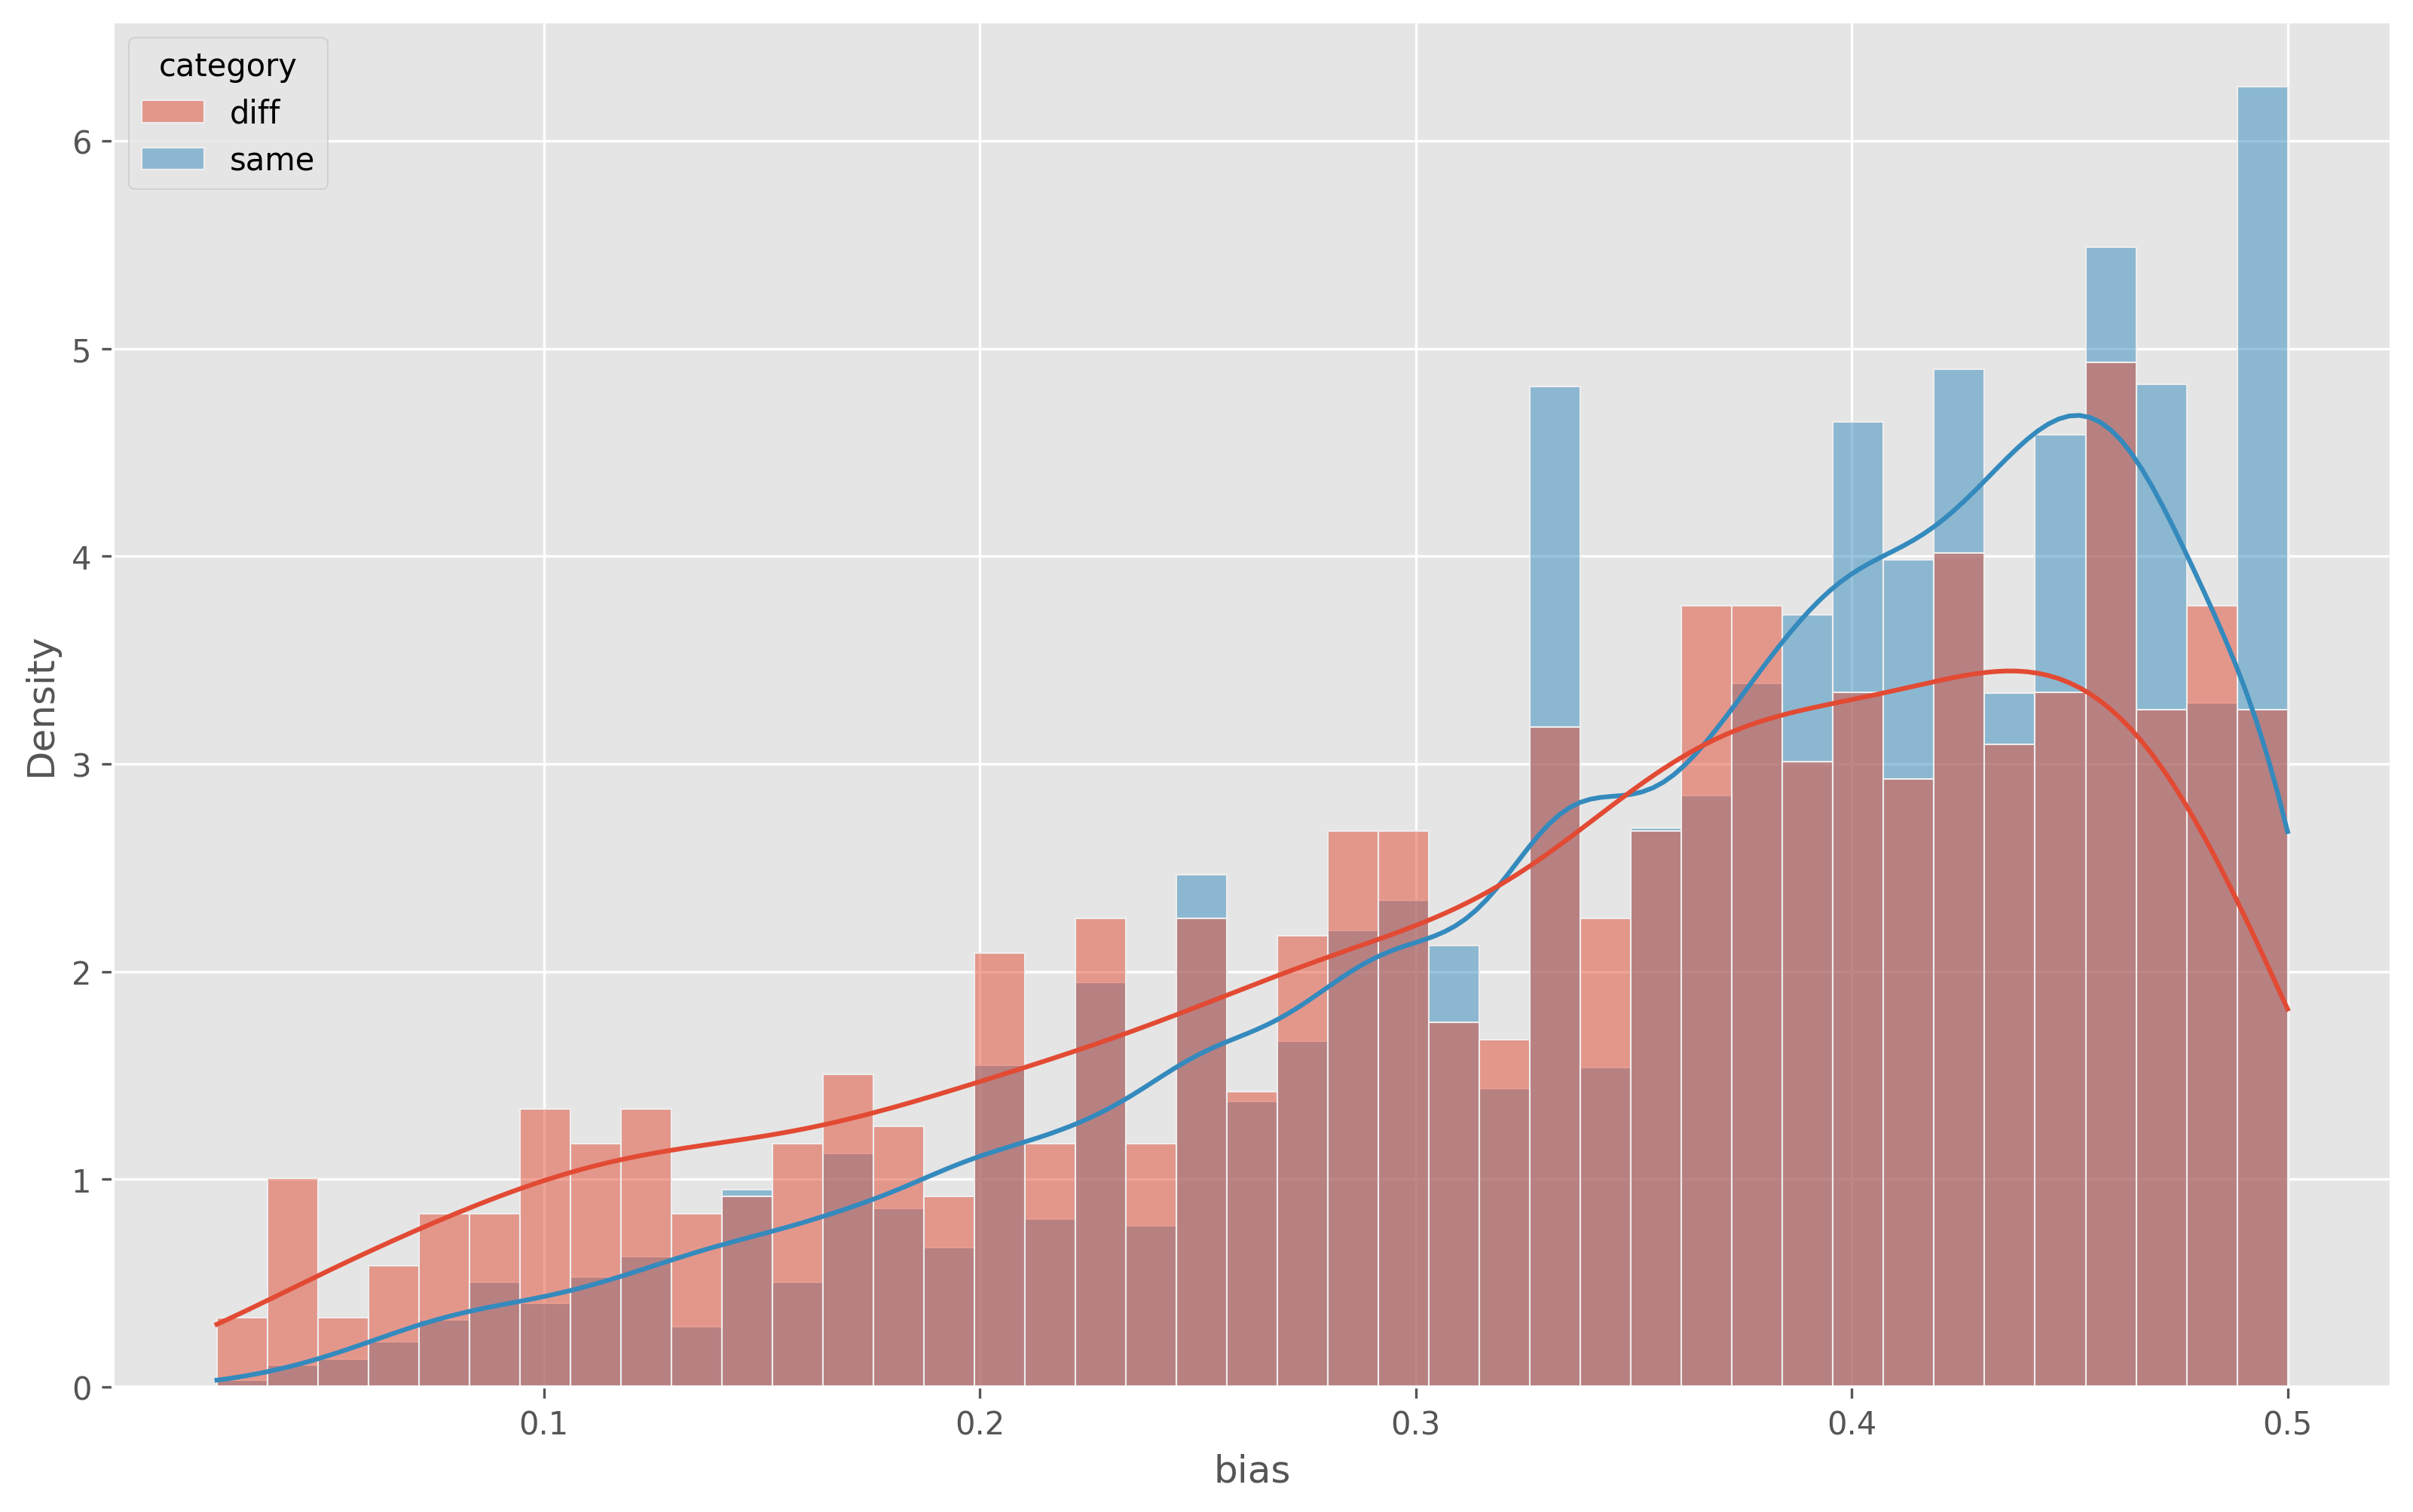

In [208]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="bias", hue="category", ax=ax, common_norm=False, stat="density", kde=True)

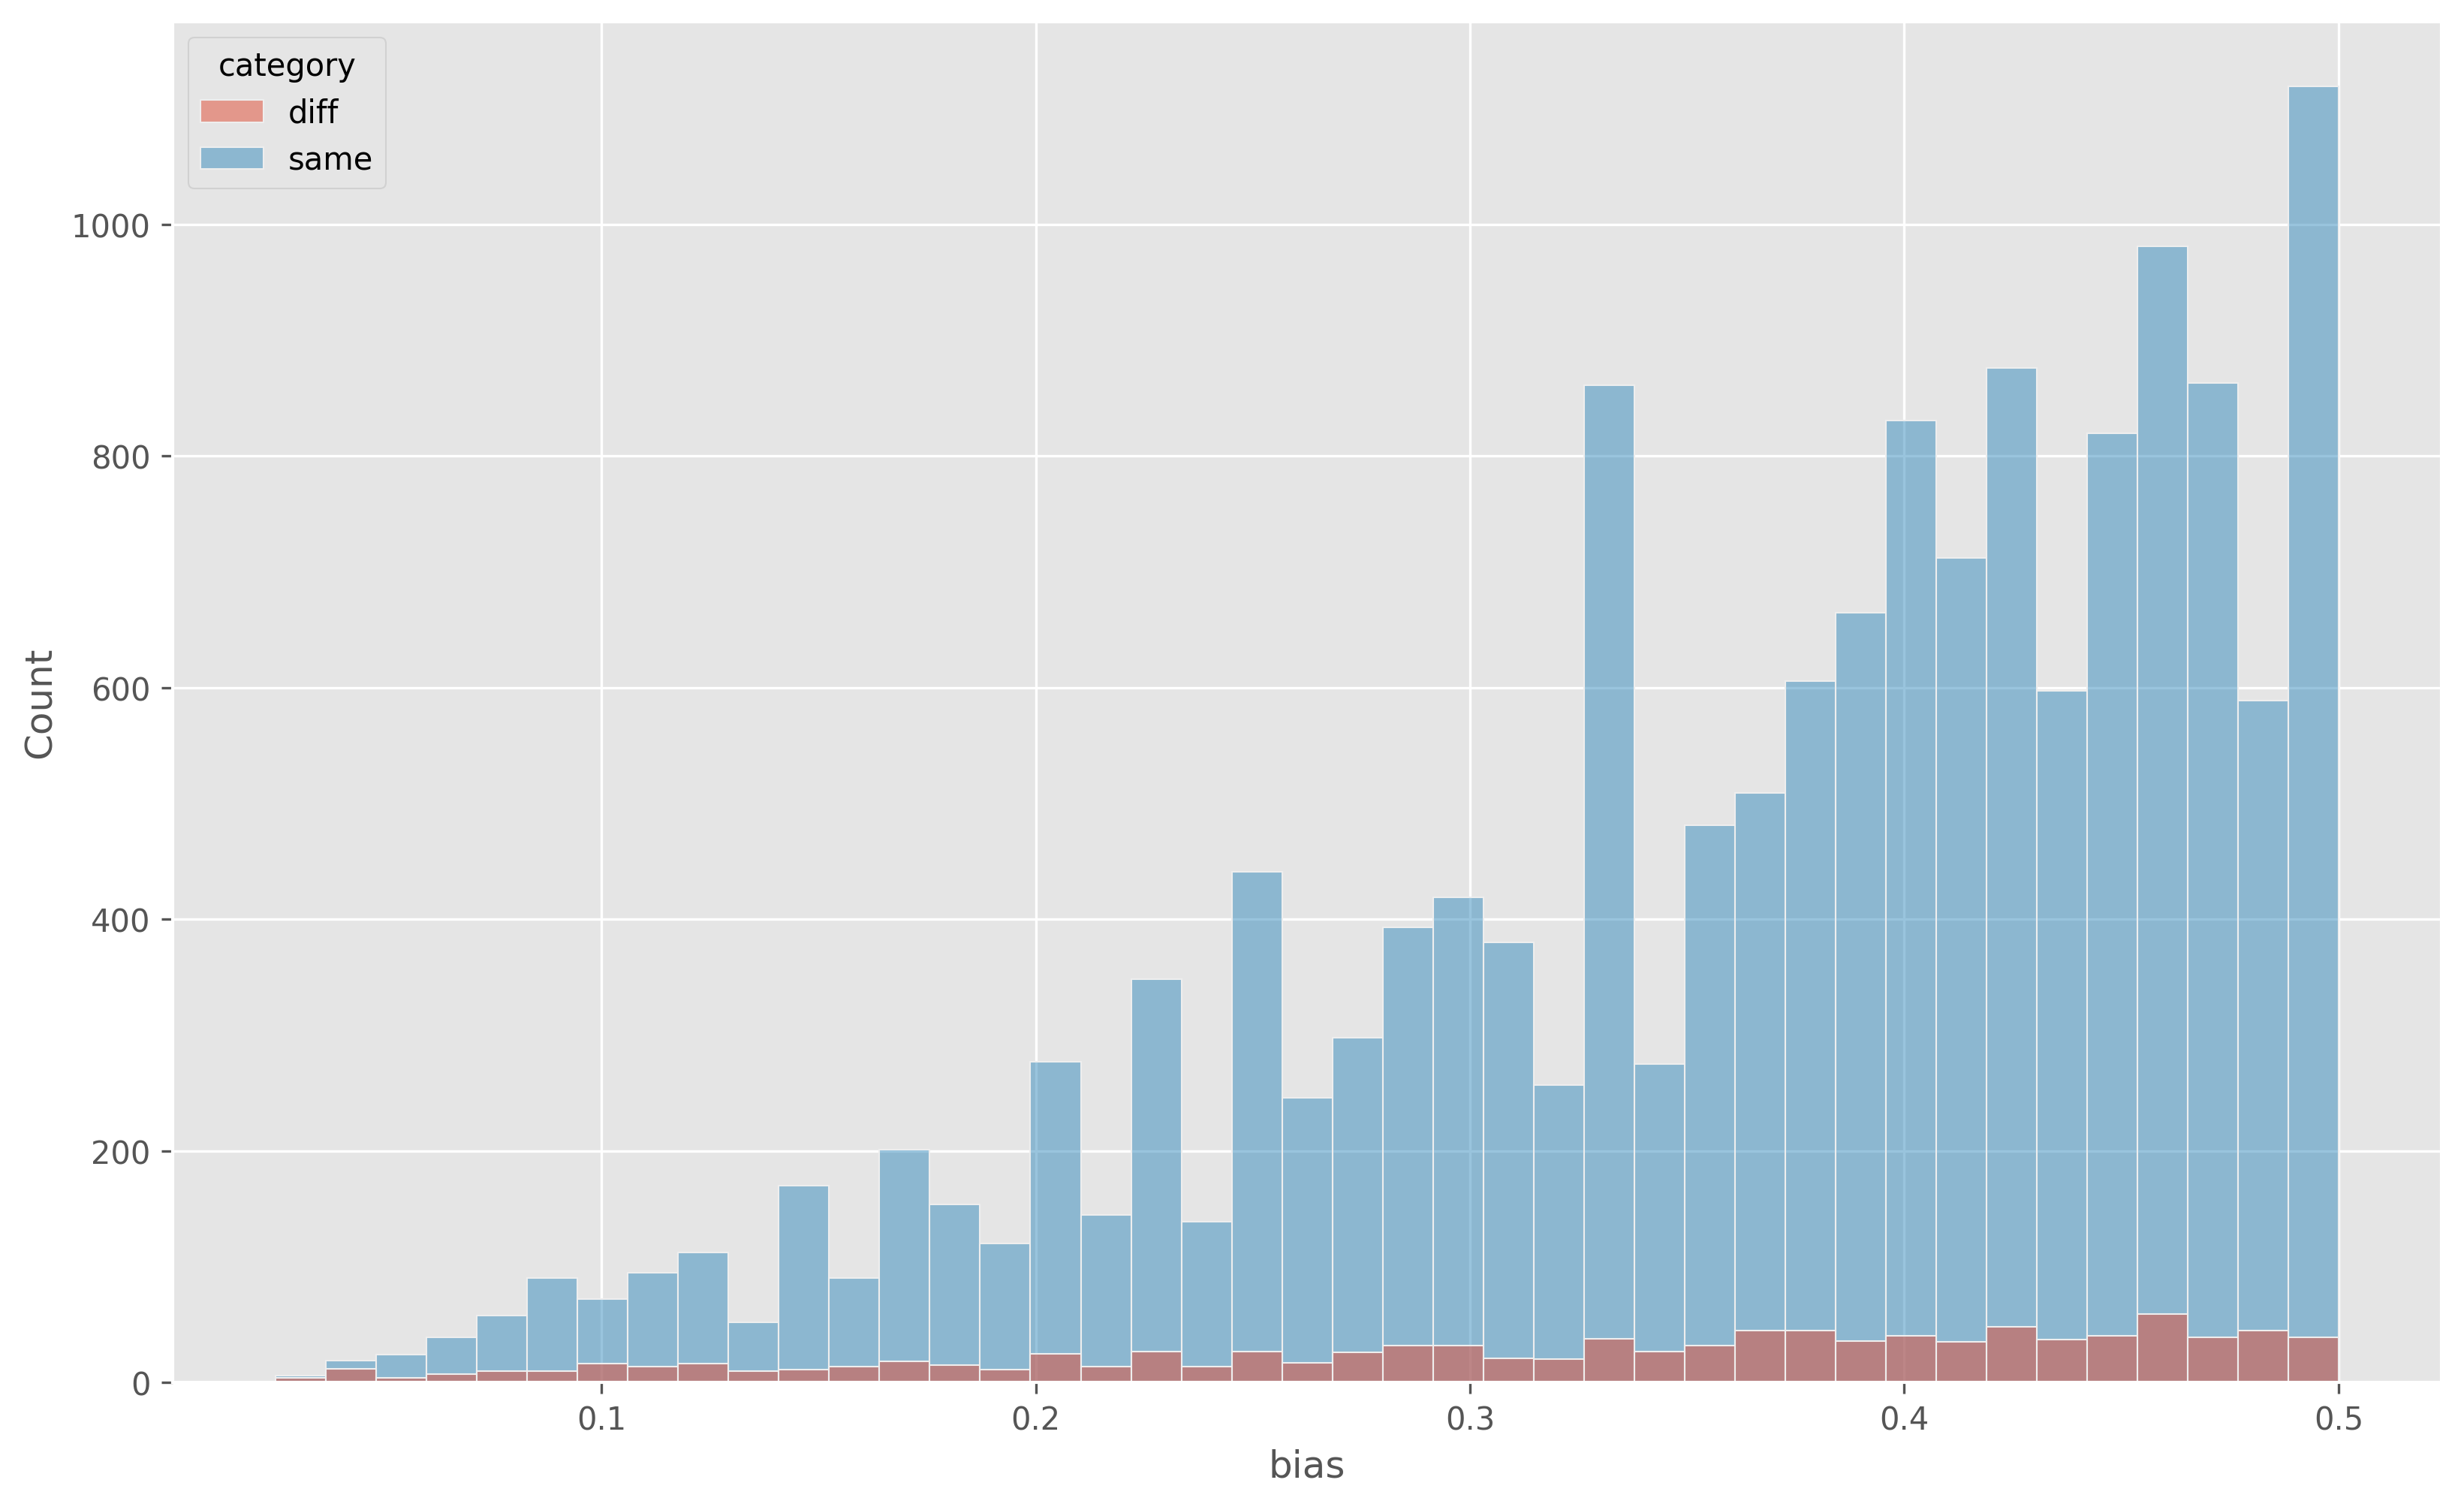

In [211]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="bias", hue="category", ax=ax)
# ax.set_xlim((0, 0.1))

### Conclusion

Strand bias seems to not play much of a part although you could argue there is a case for raising the threshold from 0.01 to 0.05 for non-SNPs...

## Follow up analysis

Based on questions from Zam in <https://github.com/mbhall88/head_to_head_pipeline/issues/7#issuecomment-772272451>

> 1.For the non SNPs, are the results equally bad for "real' indels and for things where both ref and alt alleles are long?

In [21]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        var_type = variant_type(v)
        if var_type != "non-snp":
            continue
        data.append((pair, cat, len(v.REF)))

In [22]:
df = pd.DataFrame(data, columns=["pair", "category", "ref_len"])

Text(0.5, 1.0, 'Length of reference allele')

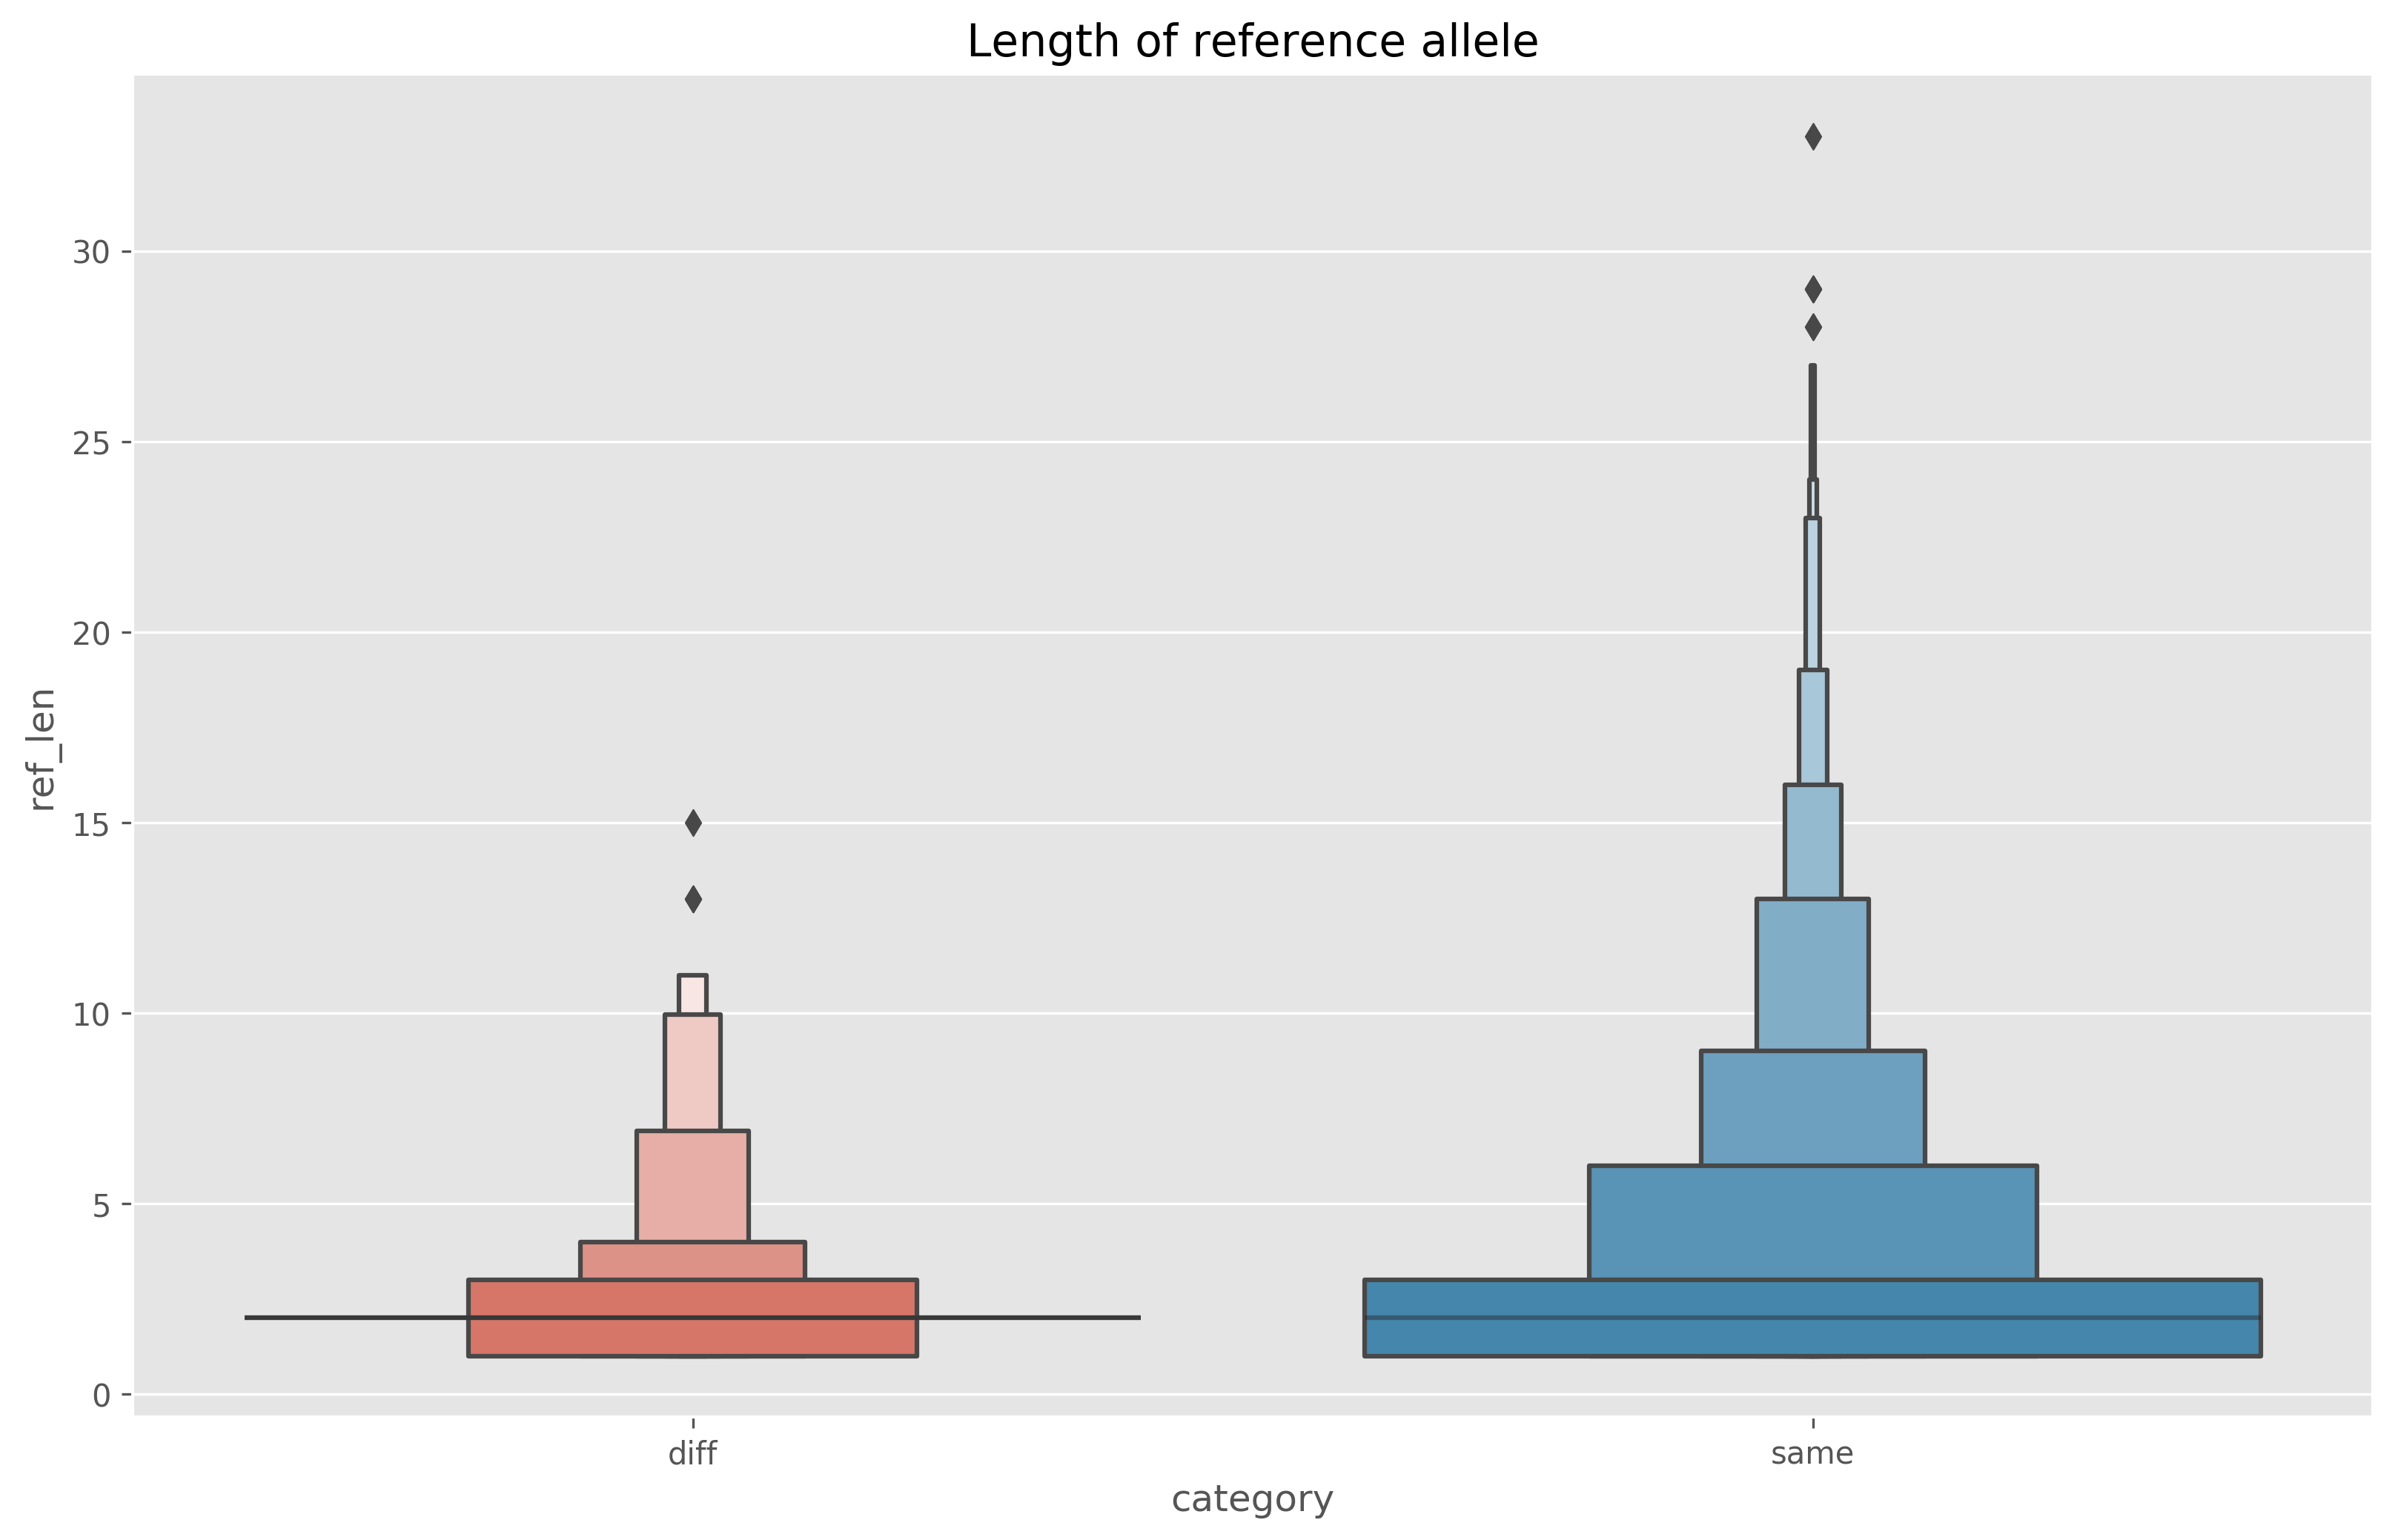

In [23]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="ref_len", x="category", ax=ax)
ax.set_title("Length of reference allele")

In [68]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        var_type = variant_type(v)
        if var_type != "non-snp":
            continue
        for alt in v.ALT:
            data.append((pair, cat, len(alt)))

In [69]:
df = pd.DataFrame(data, columns=["pair", "category", "alt_len"])

Text(0.5, 1.0, 'Length of alternate allele')

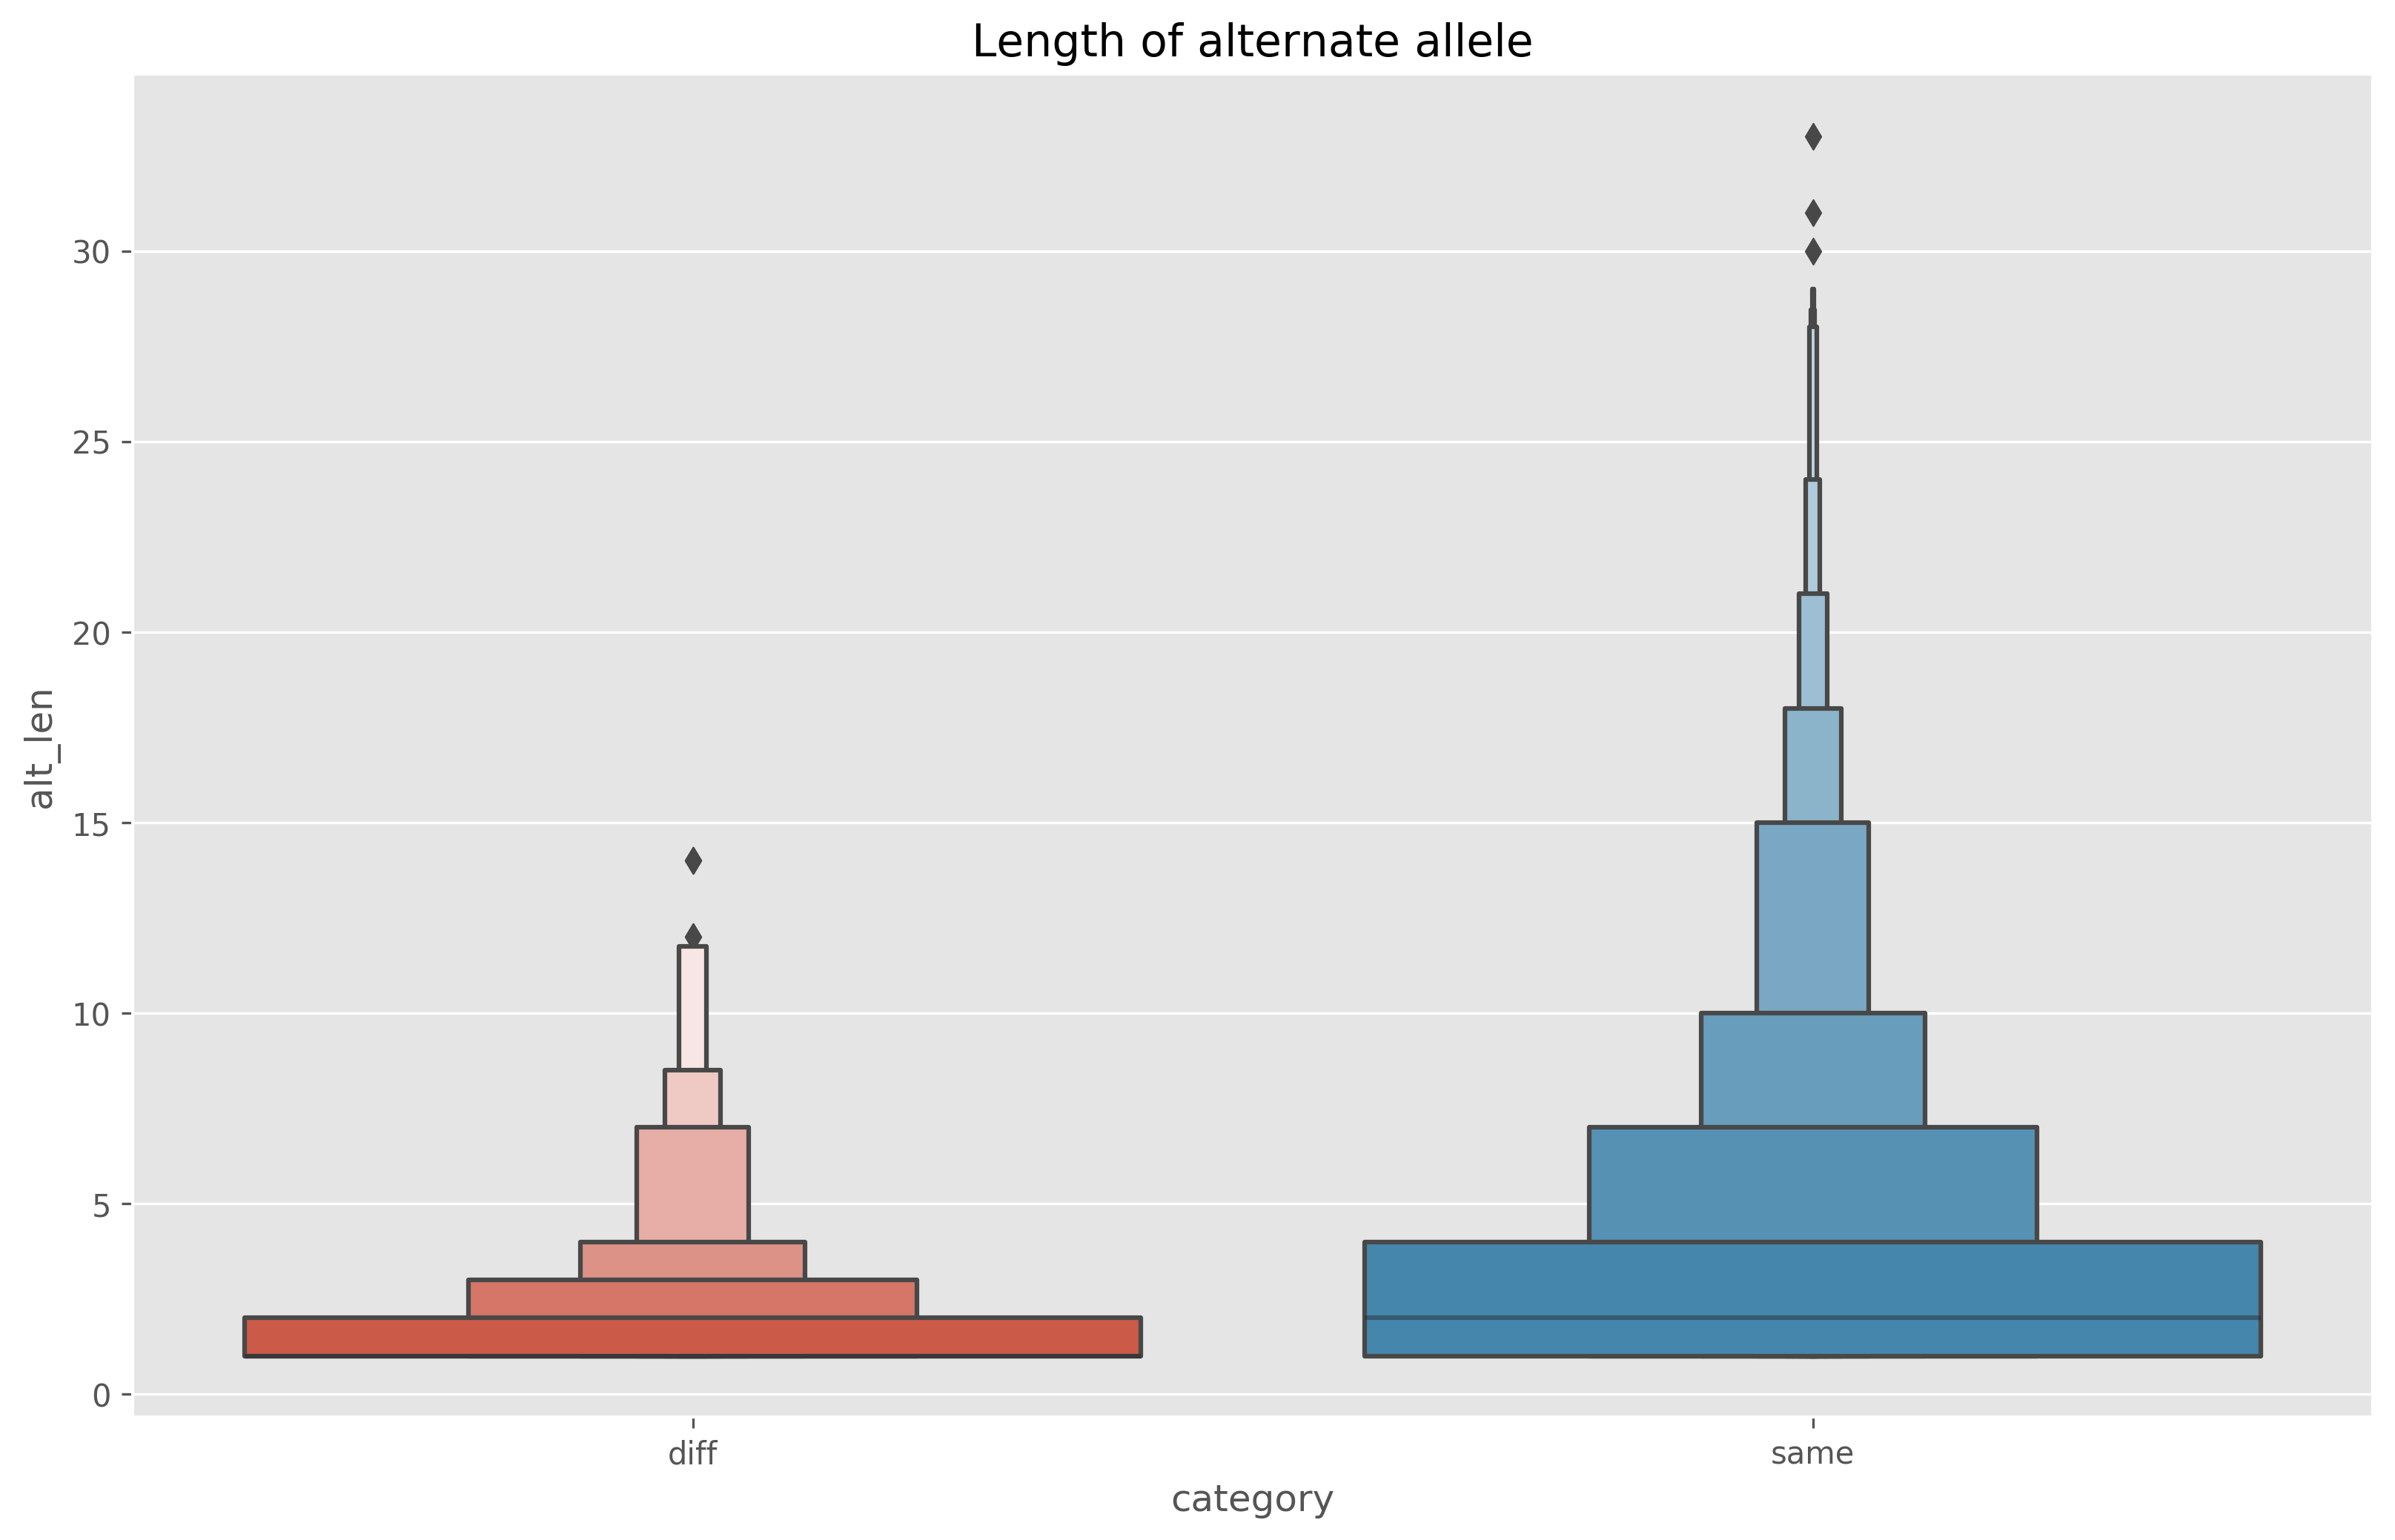

In [70]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="alt_len", x="category", ax=ax)
ax.set_title("Length of alternate allele")

In the VCFs I am working with, there aren't many "long" alleles in the VCFs where the calls are different for the two samples when they should have been the same. However, I have left-aligned and normalised these VCFs so that may not reflect their original lengths.

Let's look at the same plots. but with the VCF entries from the original `pandora` VCF

In [71]:
data = []
samples = []
for p in set(df["pair"]):
    s1, s2 = p.split("x")
    samples.append(s1)
    samples.append(s2)
pandora_vcf = VCF("pandora.original.compare.bcf", samples=samples)
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        original_var = next(pandora_vcf(f"{v.CHROM}:{v.POS}"))
        var_type = variant_type(original_var)
        if var_type != "non-snp":
            continue
        for alt in original_var.ALT:
            data.append((pair, cat, len(alt)))

In [72]:
df = pd.DataFrame(data, columns=["pair", "category", "alt_len"])

(0, 50)

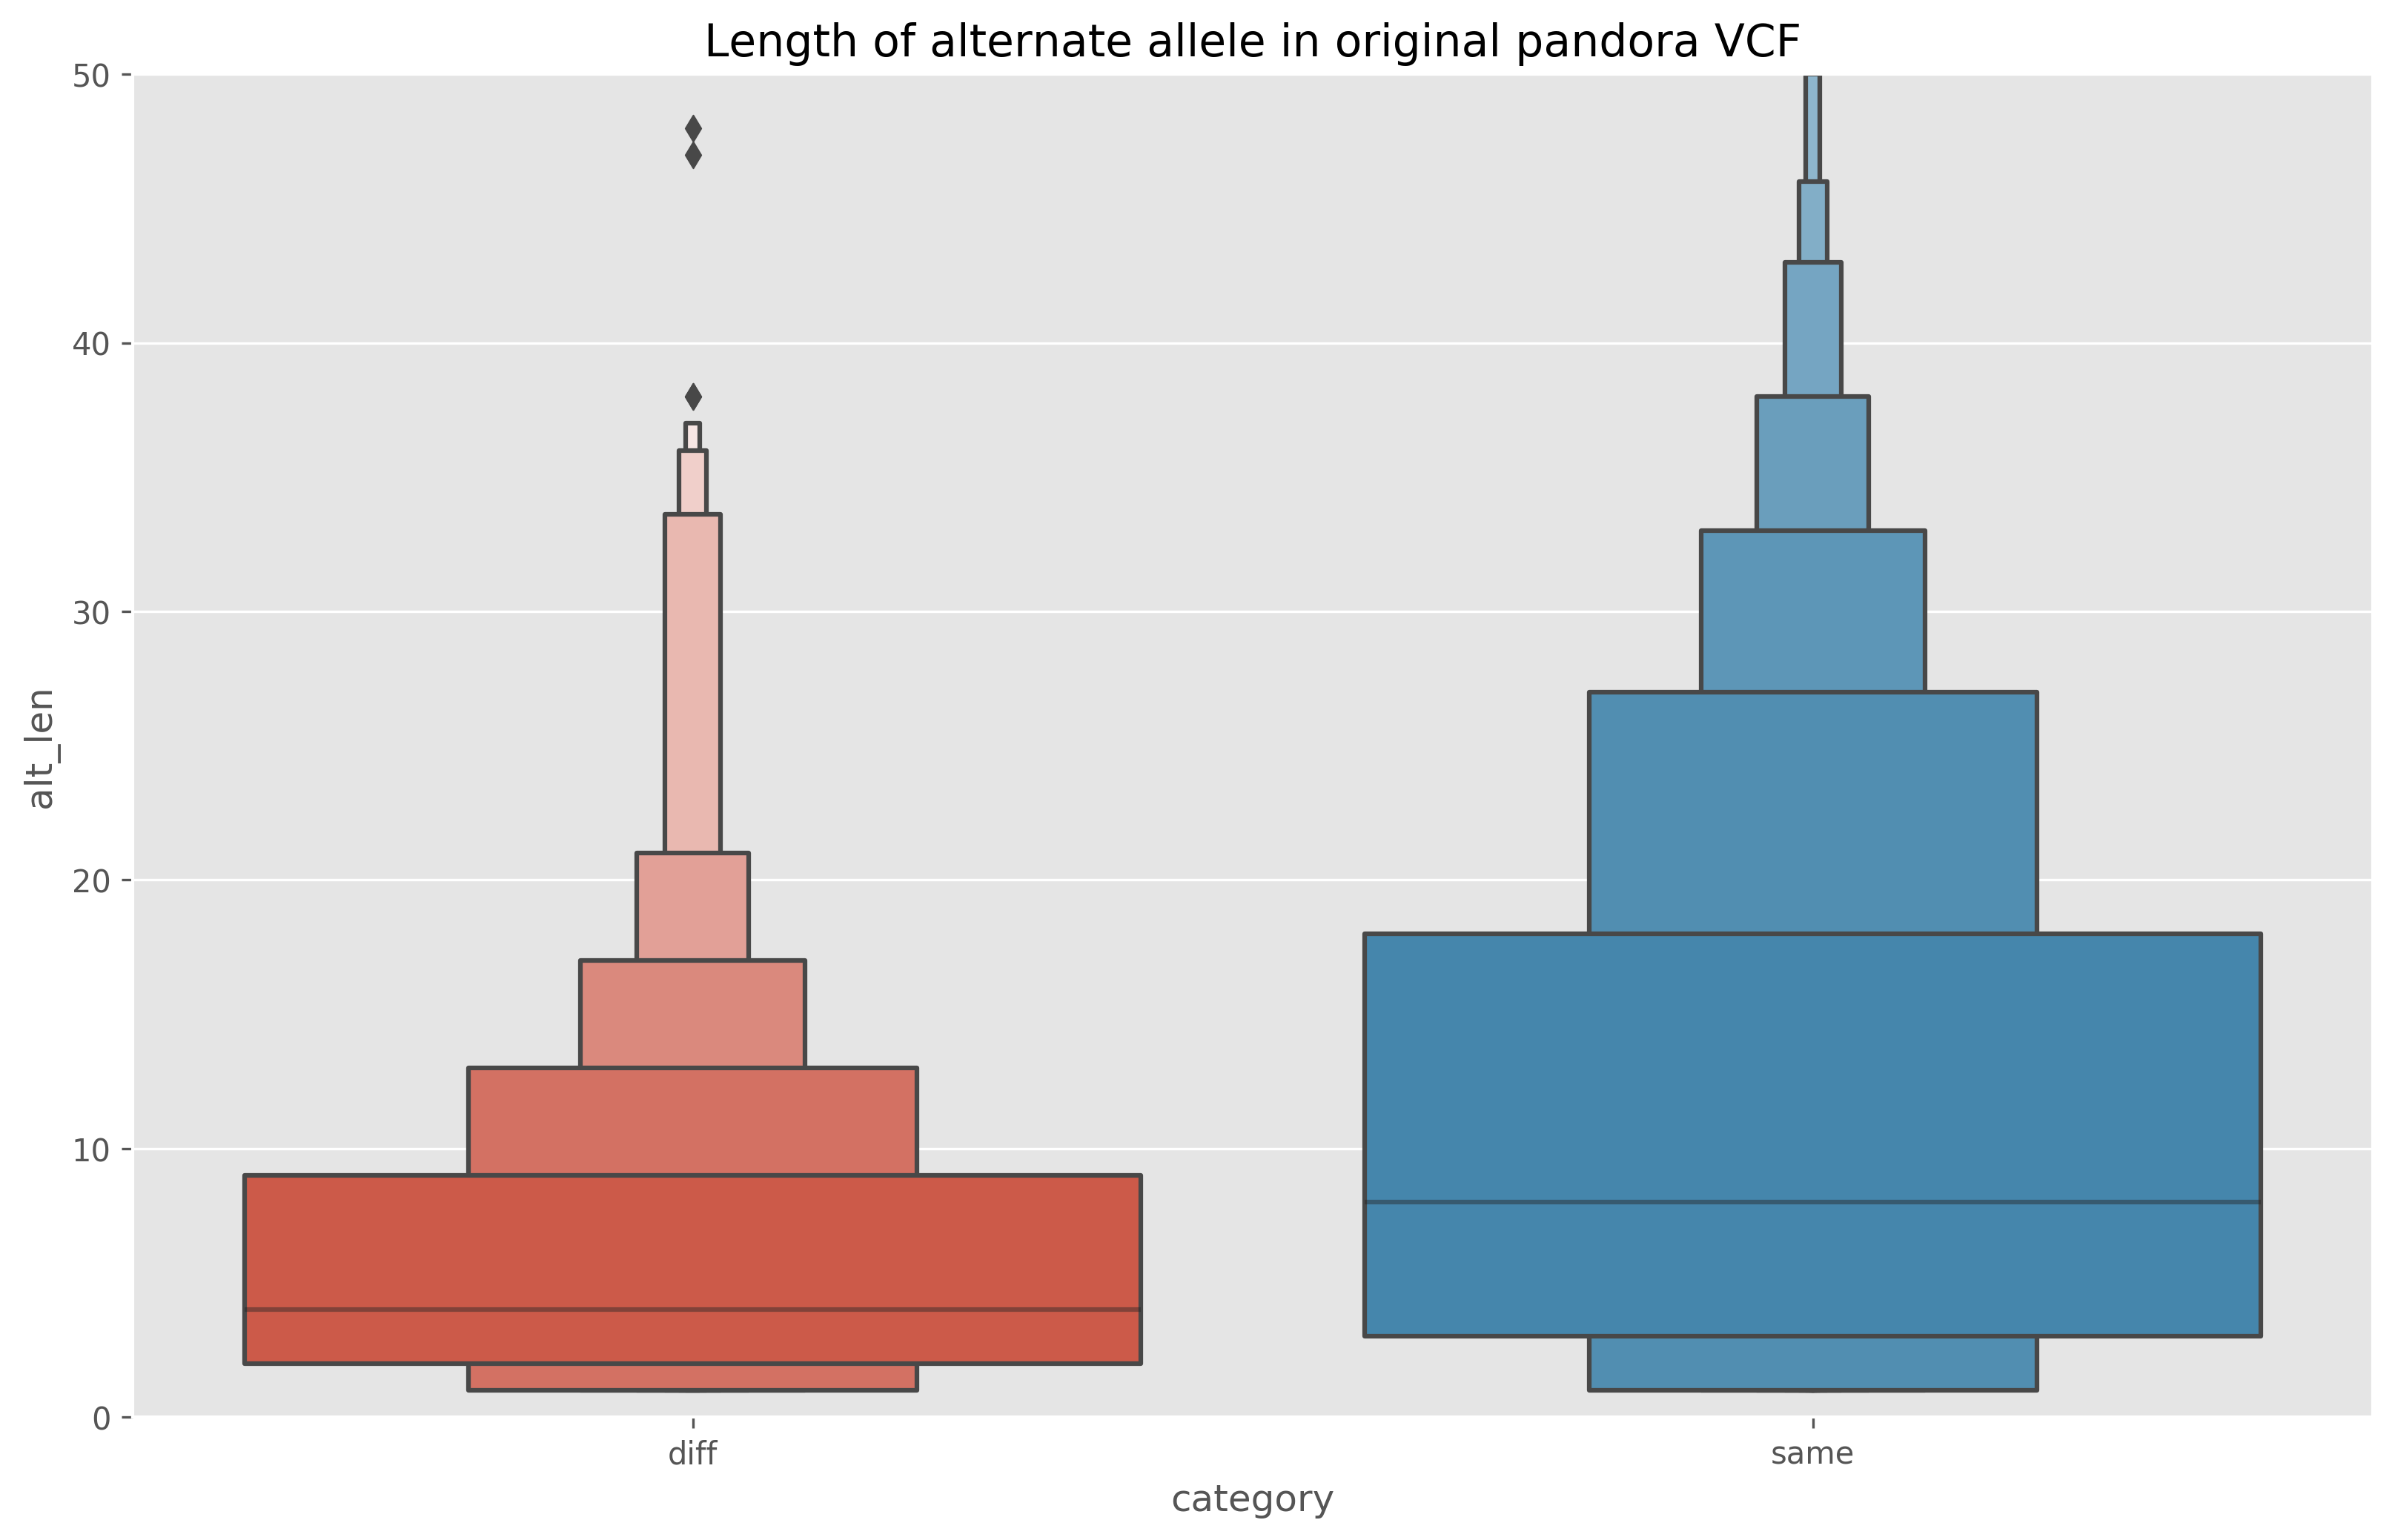

In [73]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="alt_len", x="category", ax=ax)
ax.set_title("Length of alternate allele in original pandora VCF")
ax.set_ylim((0, 50))

Text(0.5, 1.0, 'Length of alternate allele in original pandora VCF - density')

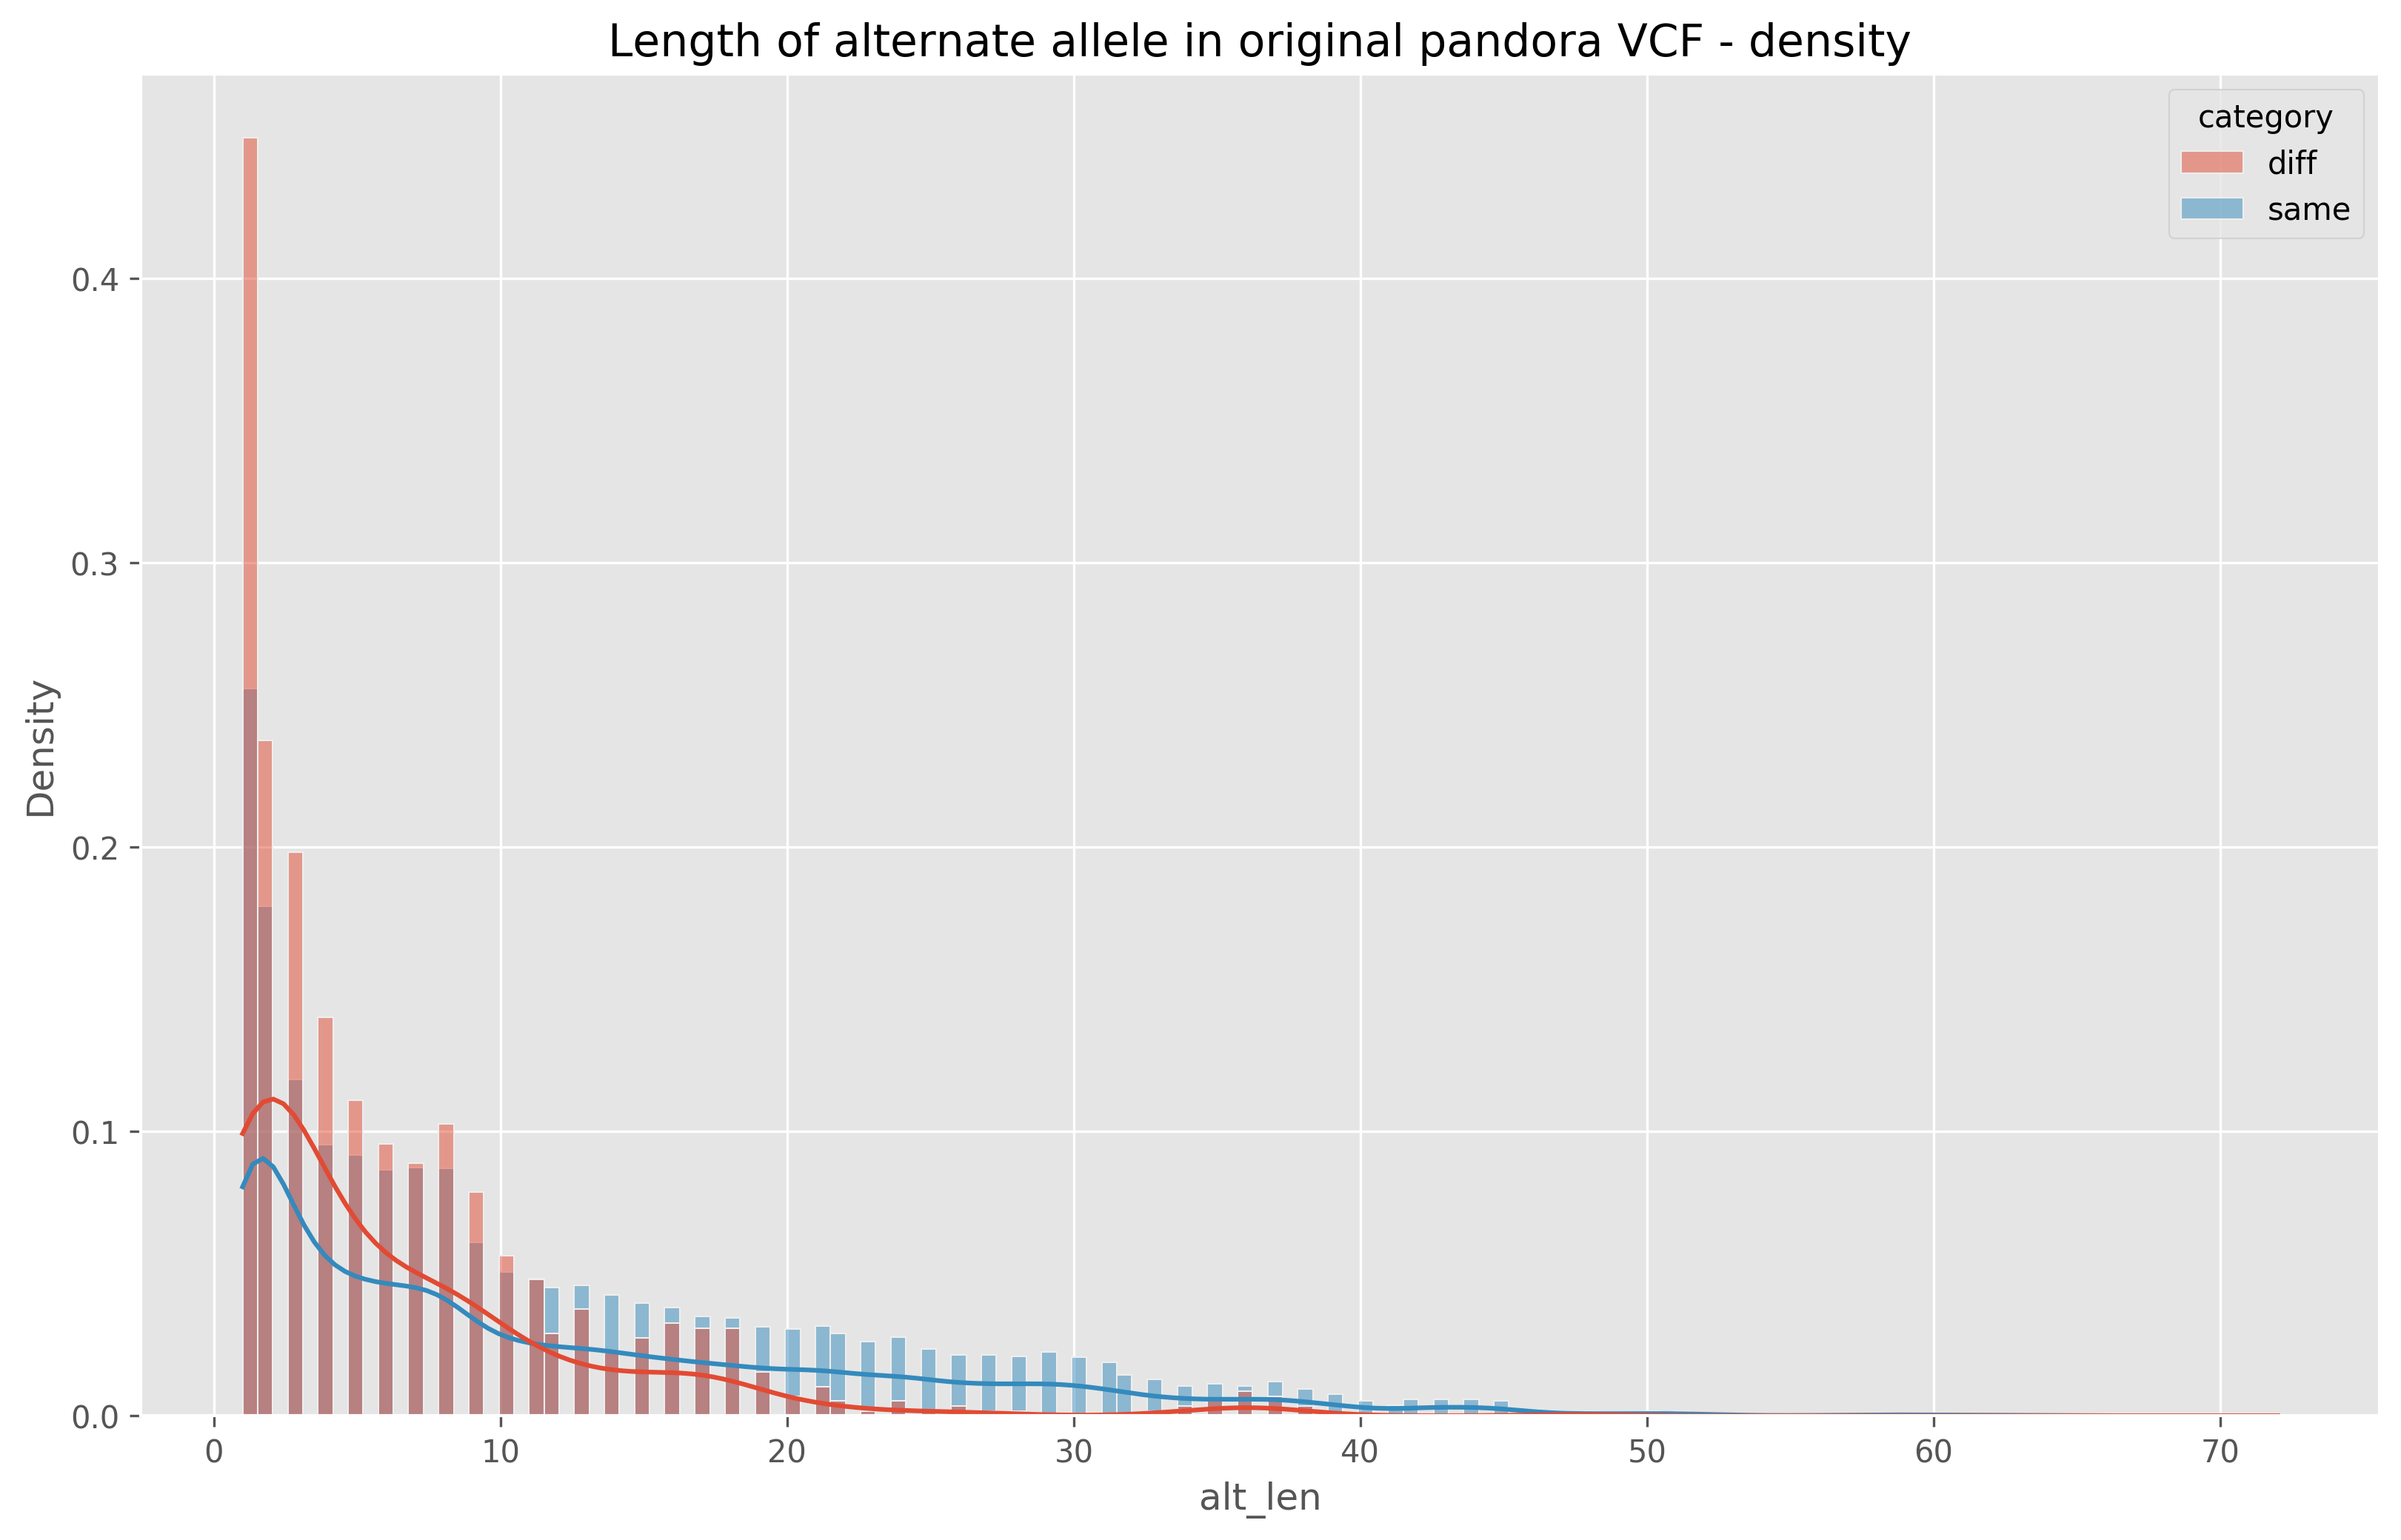

In [74]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="alt_len", hue="category", ax=ax, common_norm=False, stat="density", kde=True)
ax.set_title("Length of alternate allele in original pandora VCF - density")

Text(0.5, 1.0, 'Length of alternate allele in original pandora VCF - raw count (log)')

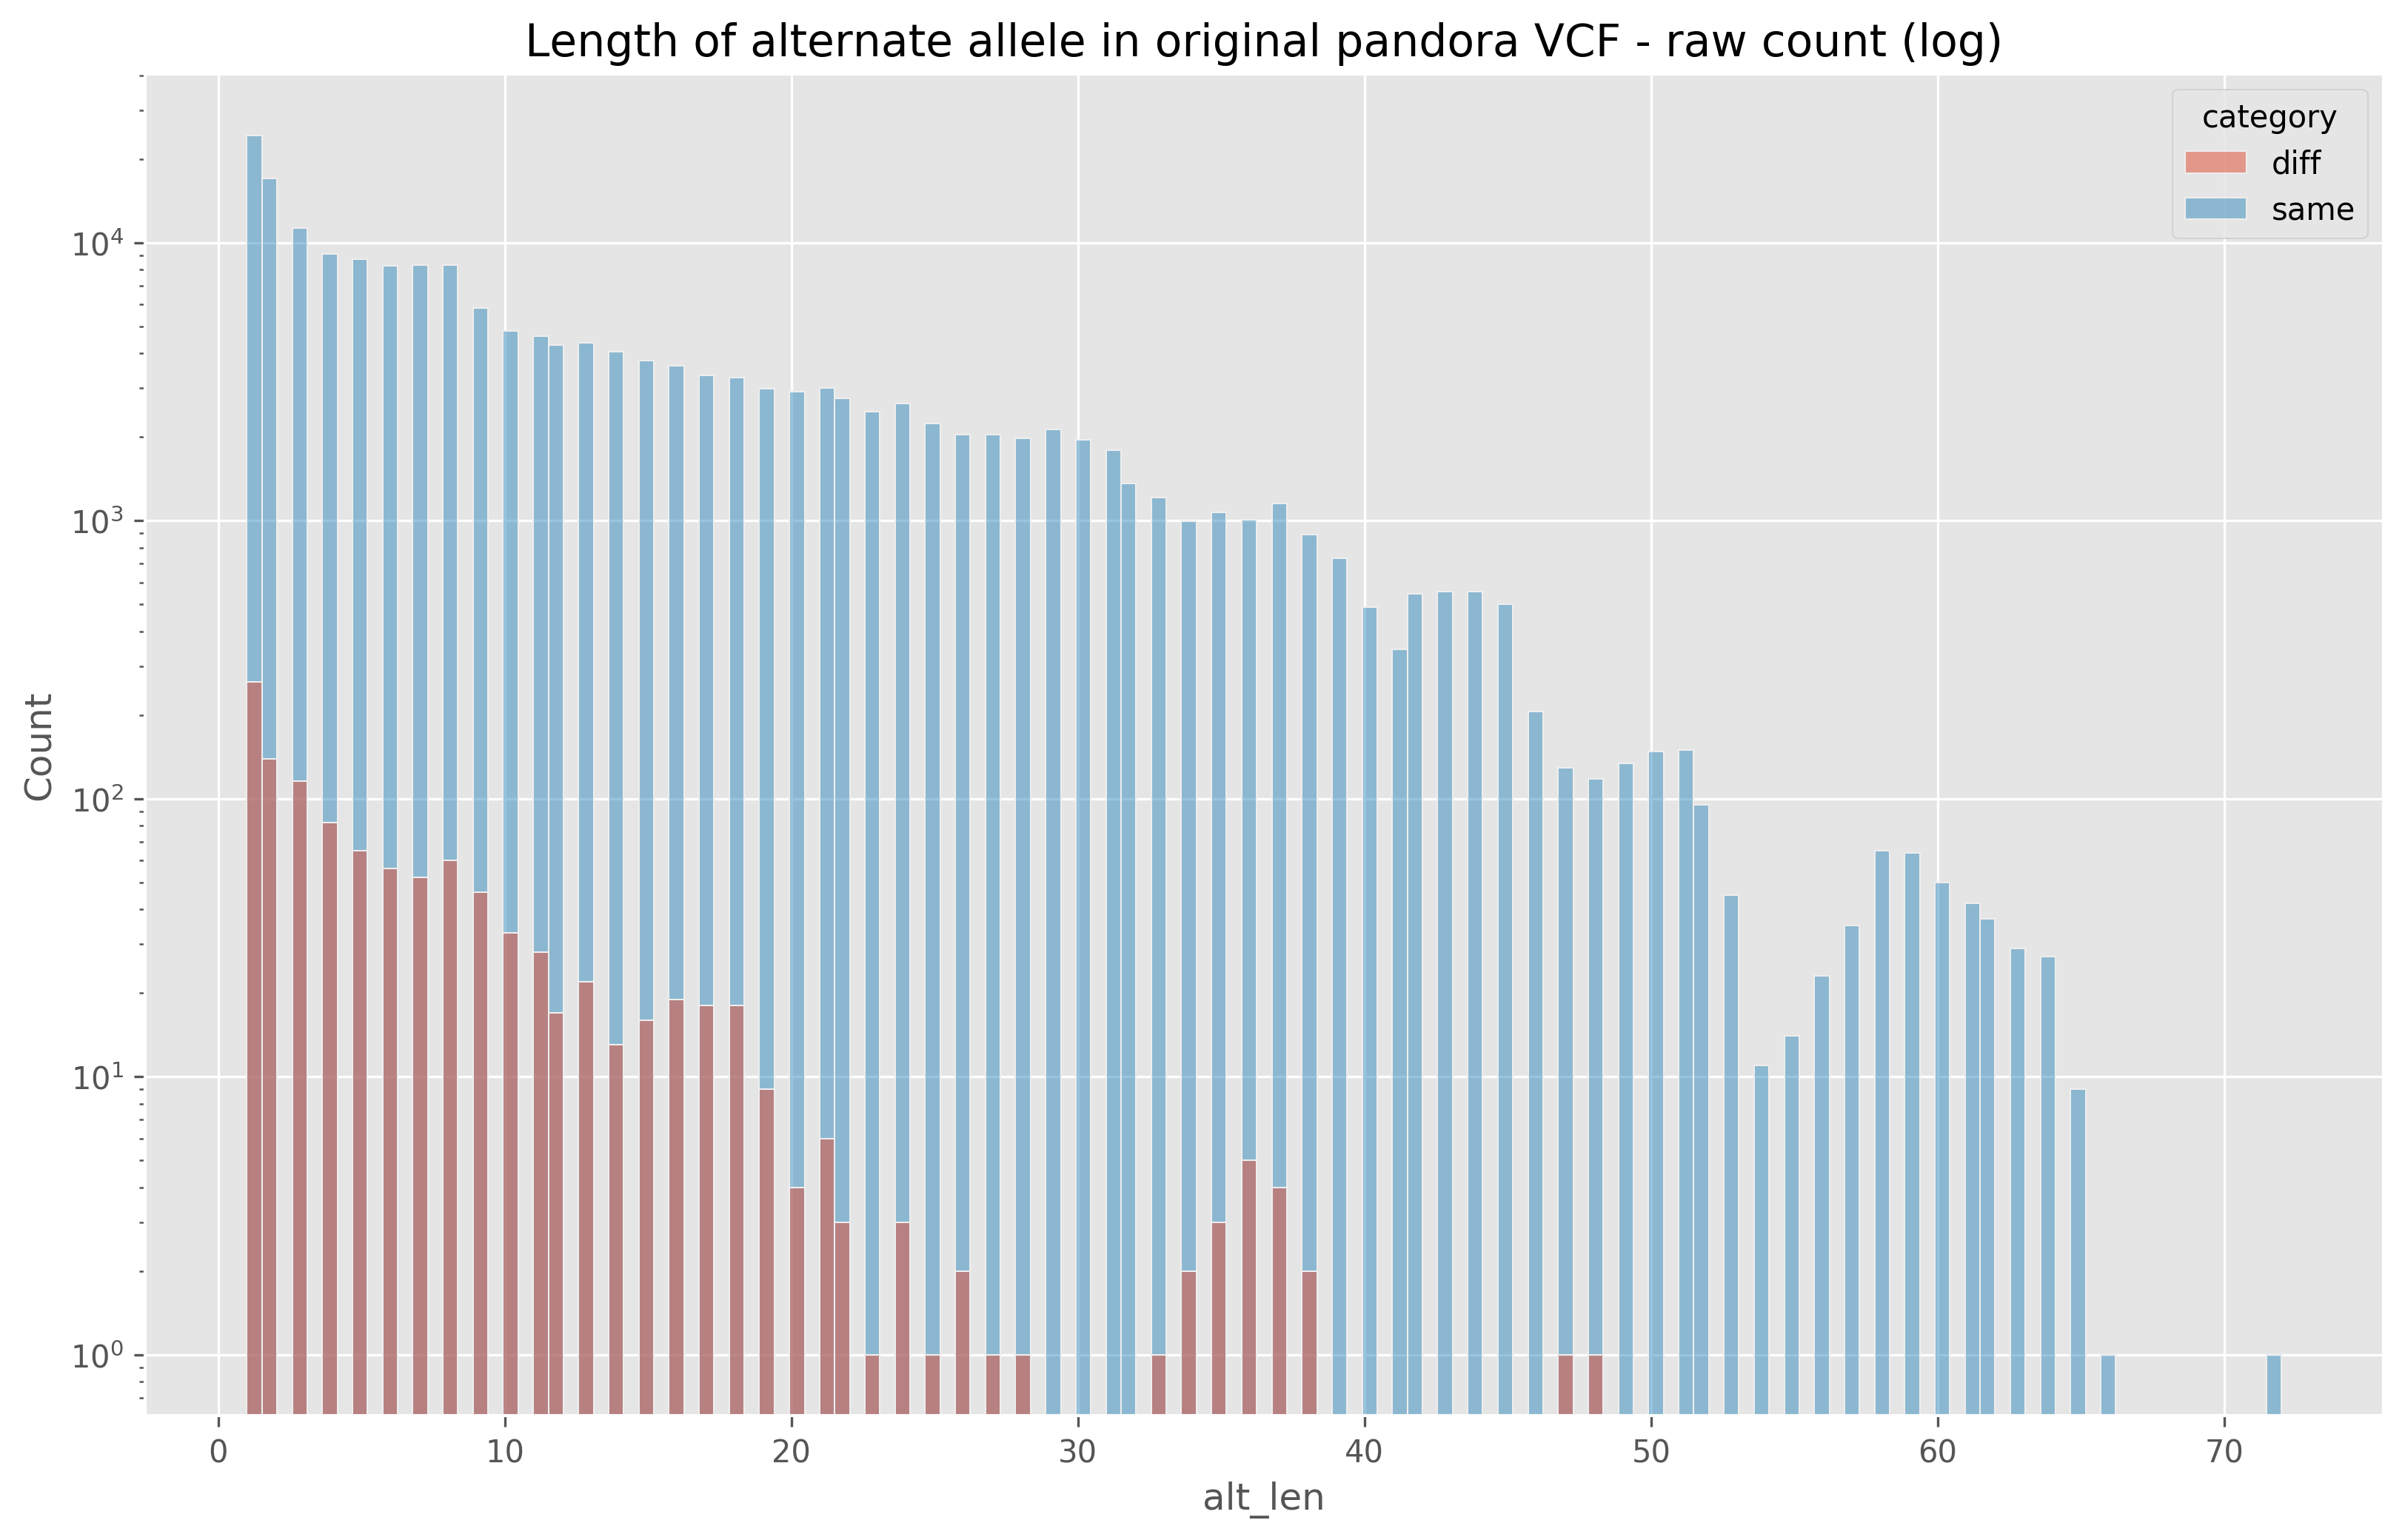

In [76]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="alt_len", hue="category", ax=ax, log_scale=(False,True))
ax.set_title("Length of alternate allele in original pandora VCF - raw count (log)")

In [42]:
data = []
samples = []
for p in set(df["pair"]):
    s1, s2 = p.split("x")
    samples.append(s1)
    samples.append(s2)
pandora_vcf = VCF("pandora.original.compare.bcf", samples=samples)
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        original_var = next(pandora_vcf(f"{v.CHROM}:{v.POS}"))
        var_type = variant_type(original_var)
        if var_type != "non-snp":
            continue
        data.append((pair, cat, len(original_var.REF)))

In [43]:
df = pd.DataFrame(data, columns=["pair", "category", "ref_len"])

Text(0.5, 1.0, 'Length of ref allele in original pandora VCF')

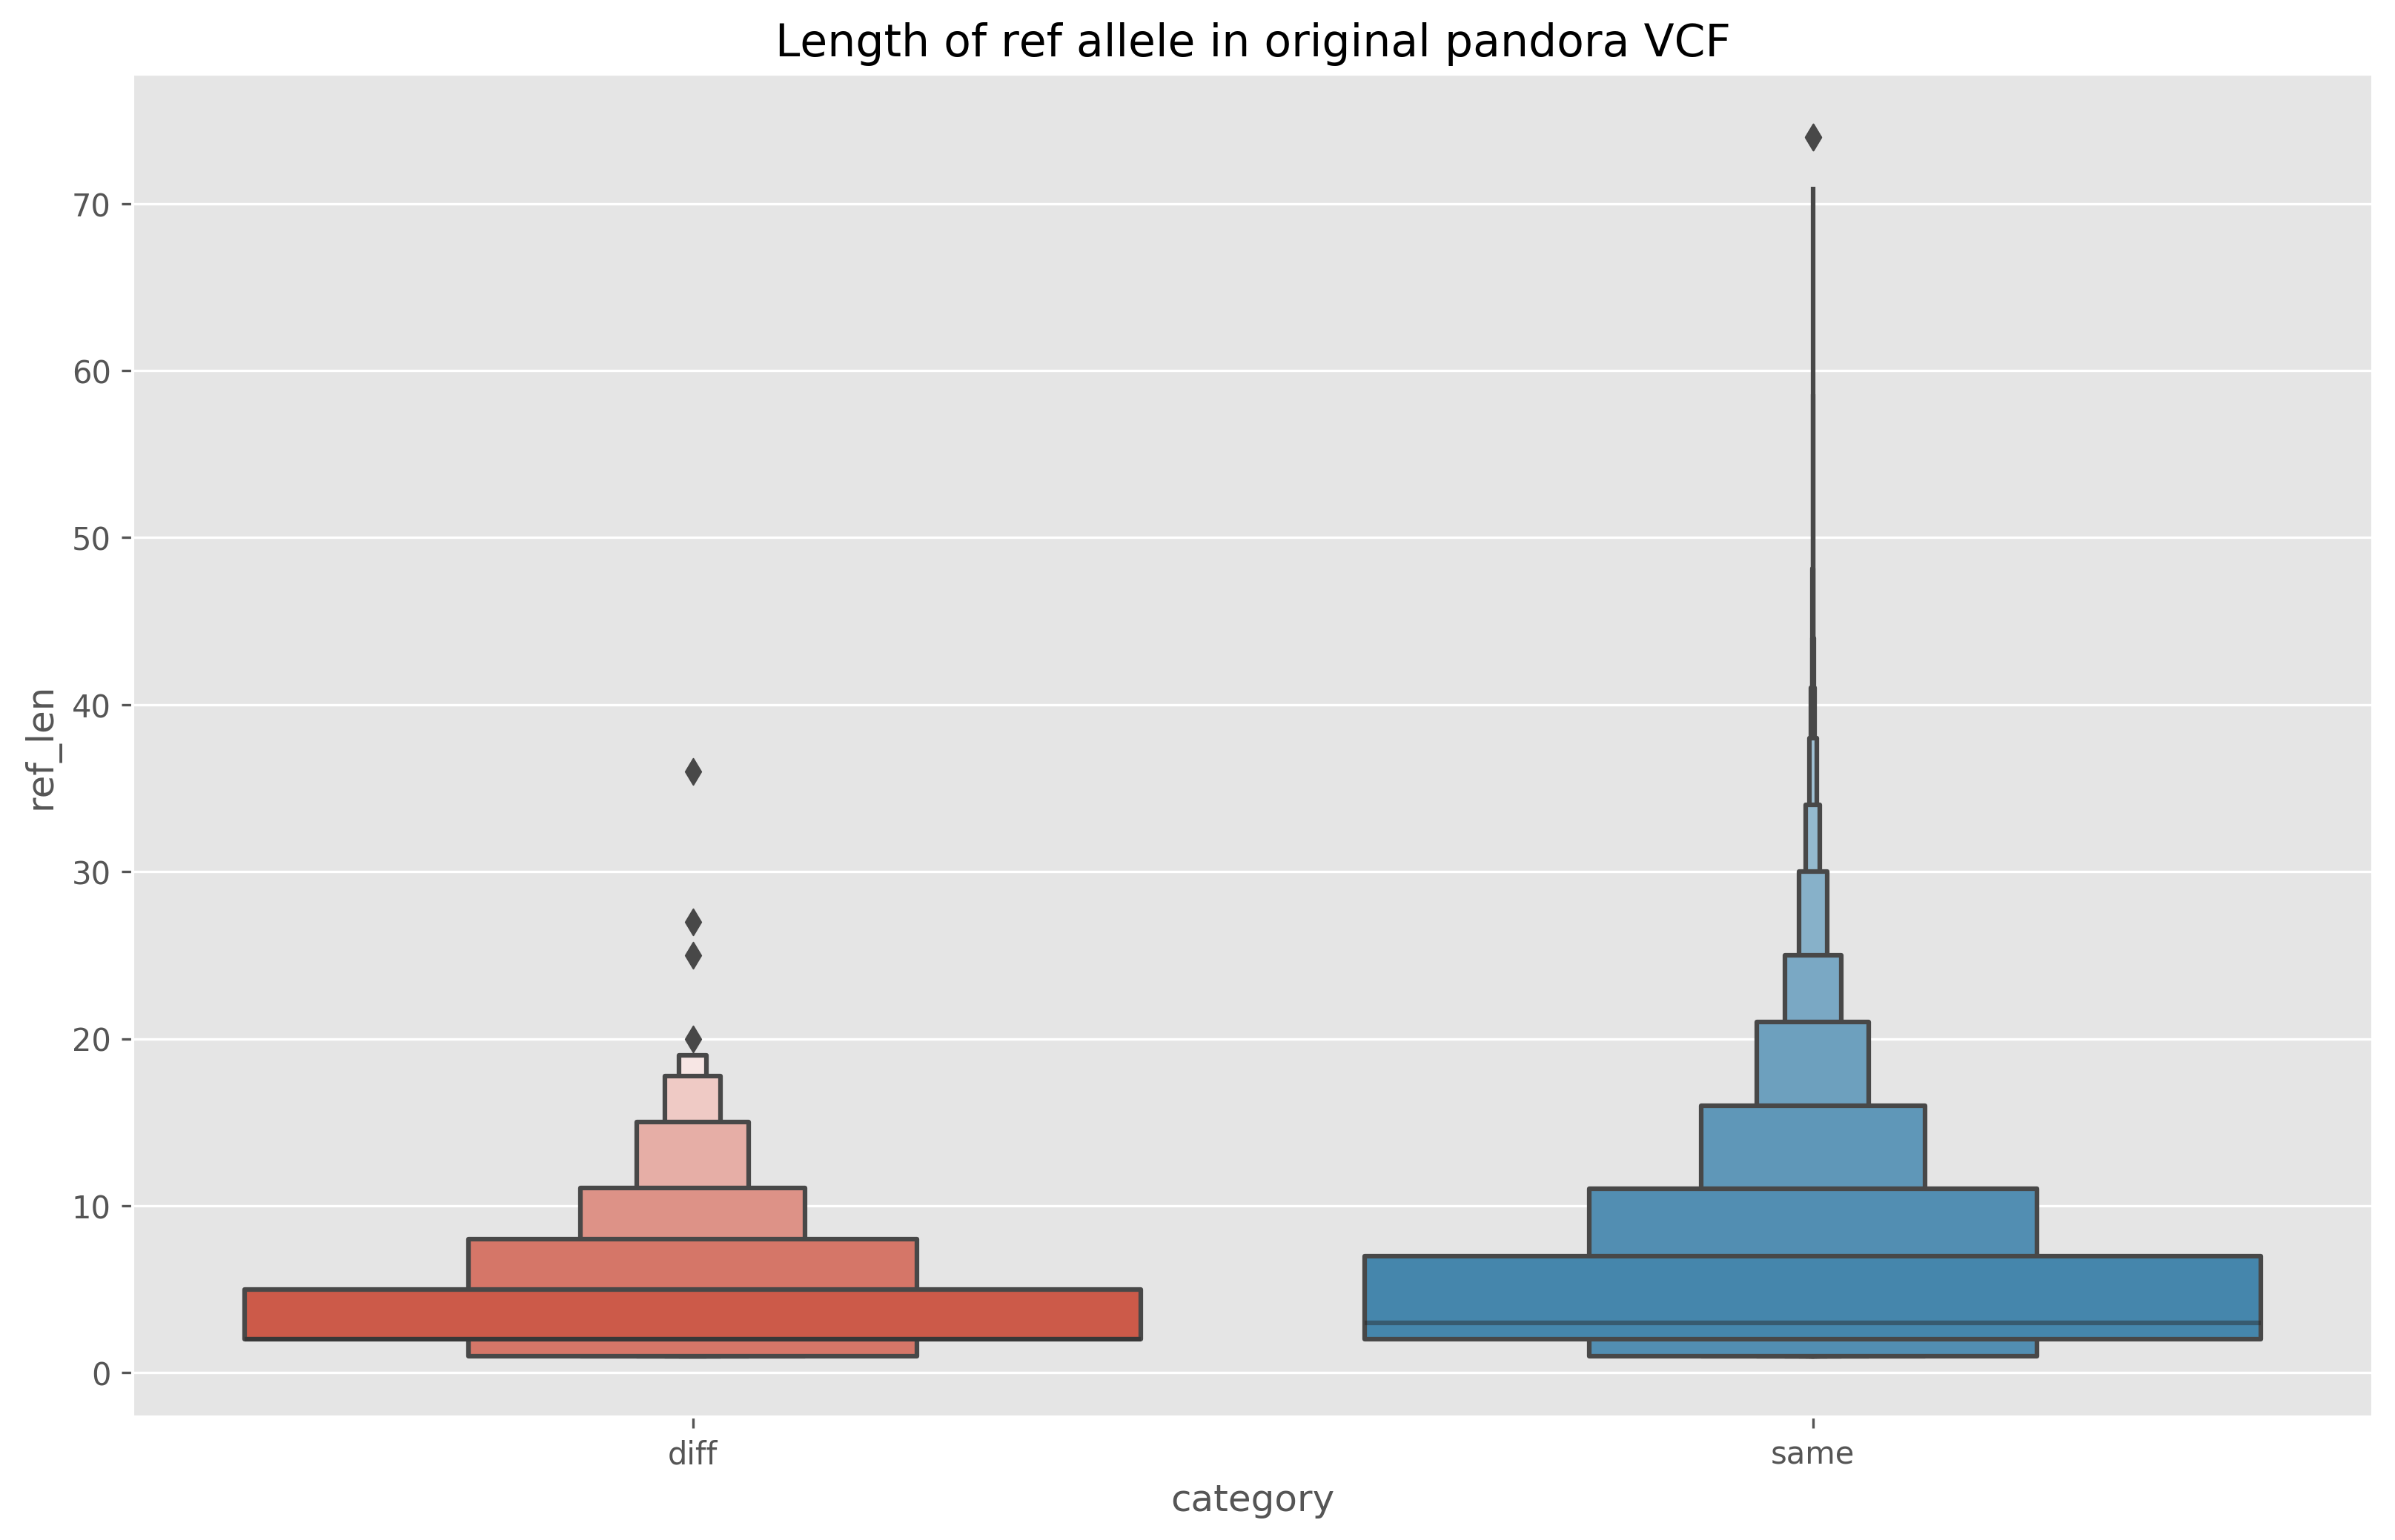

In [44]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y="ref_len", x="category", ax=ax)
ax.set_title("Length of ref allele in original pandora VCF")
# ax.set_ylim((0, 50))

Text(0.5, 1.0, 'Length of ref allele in original pandora VCF - density')

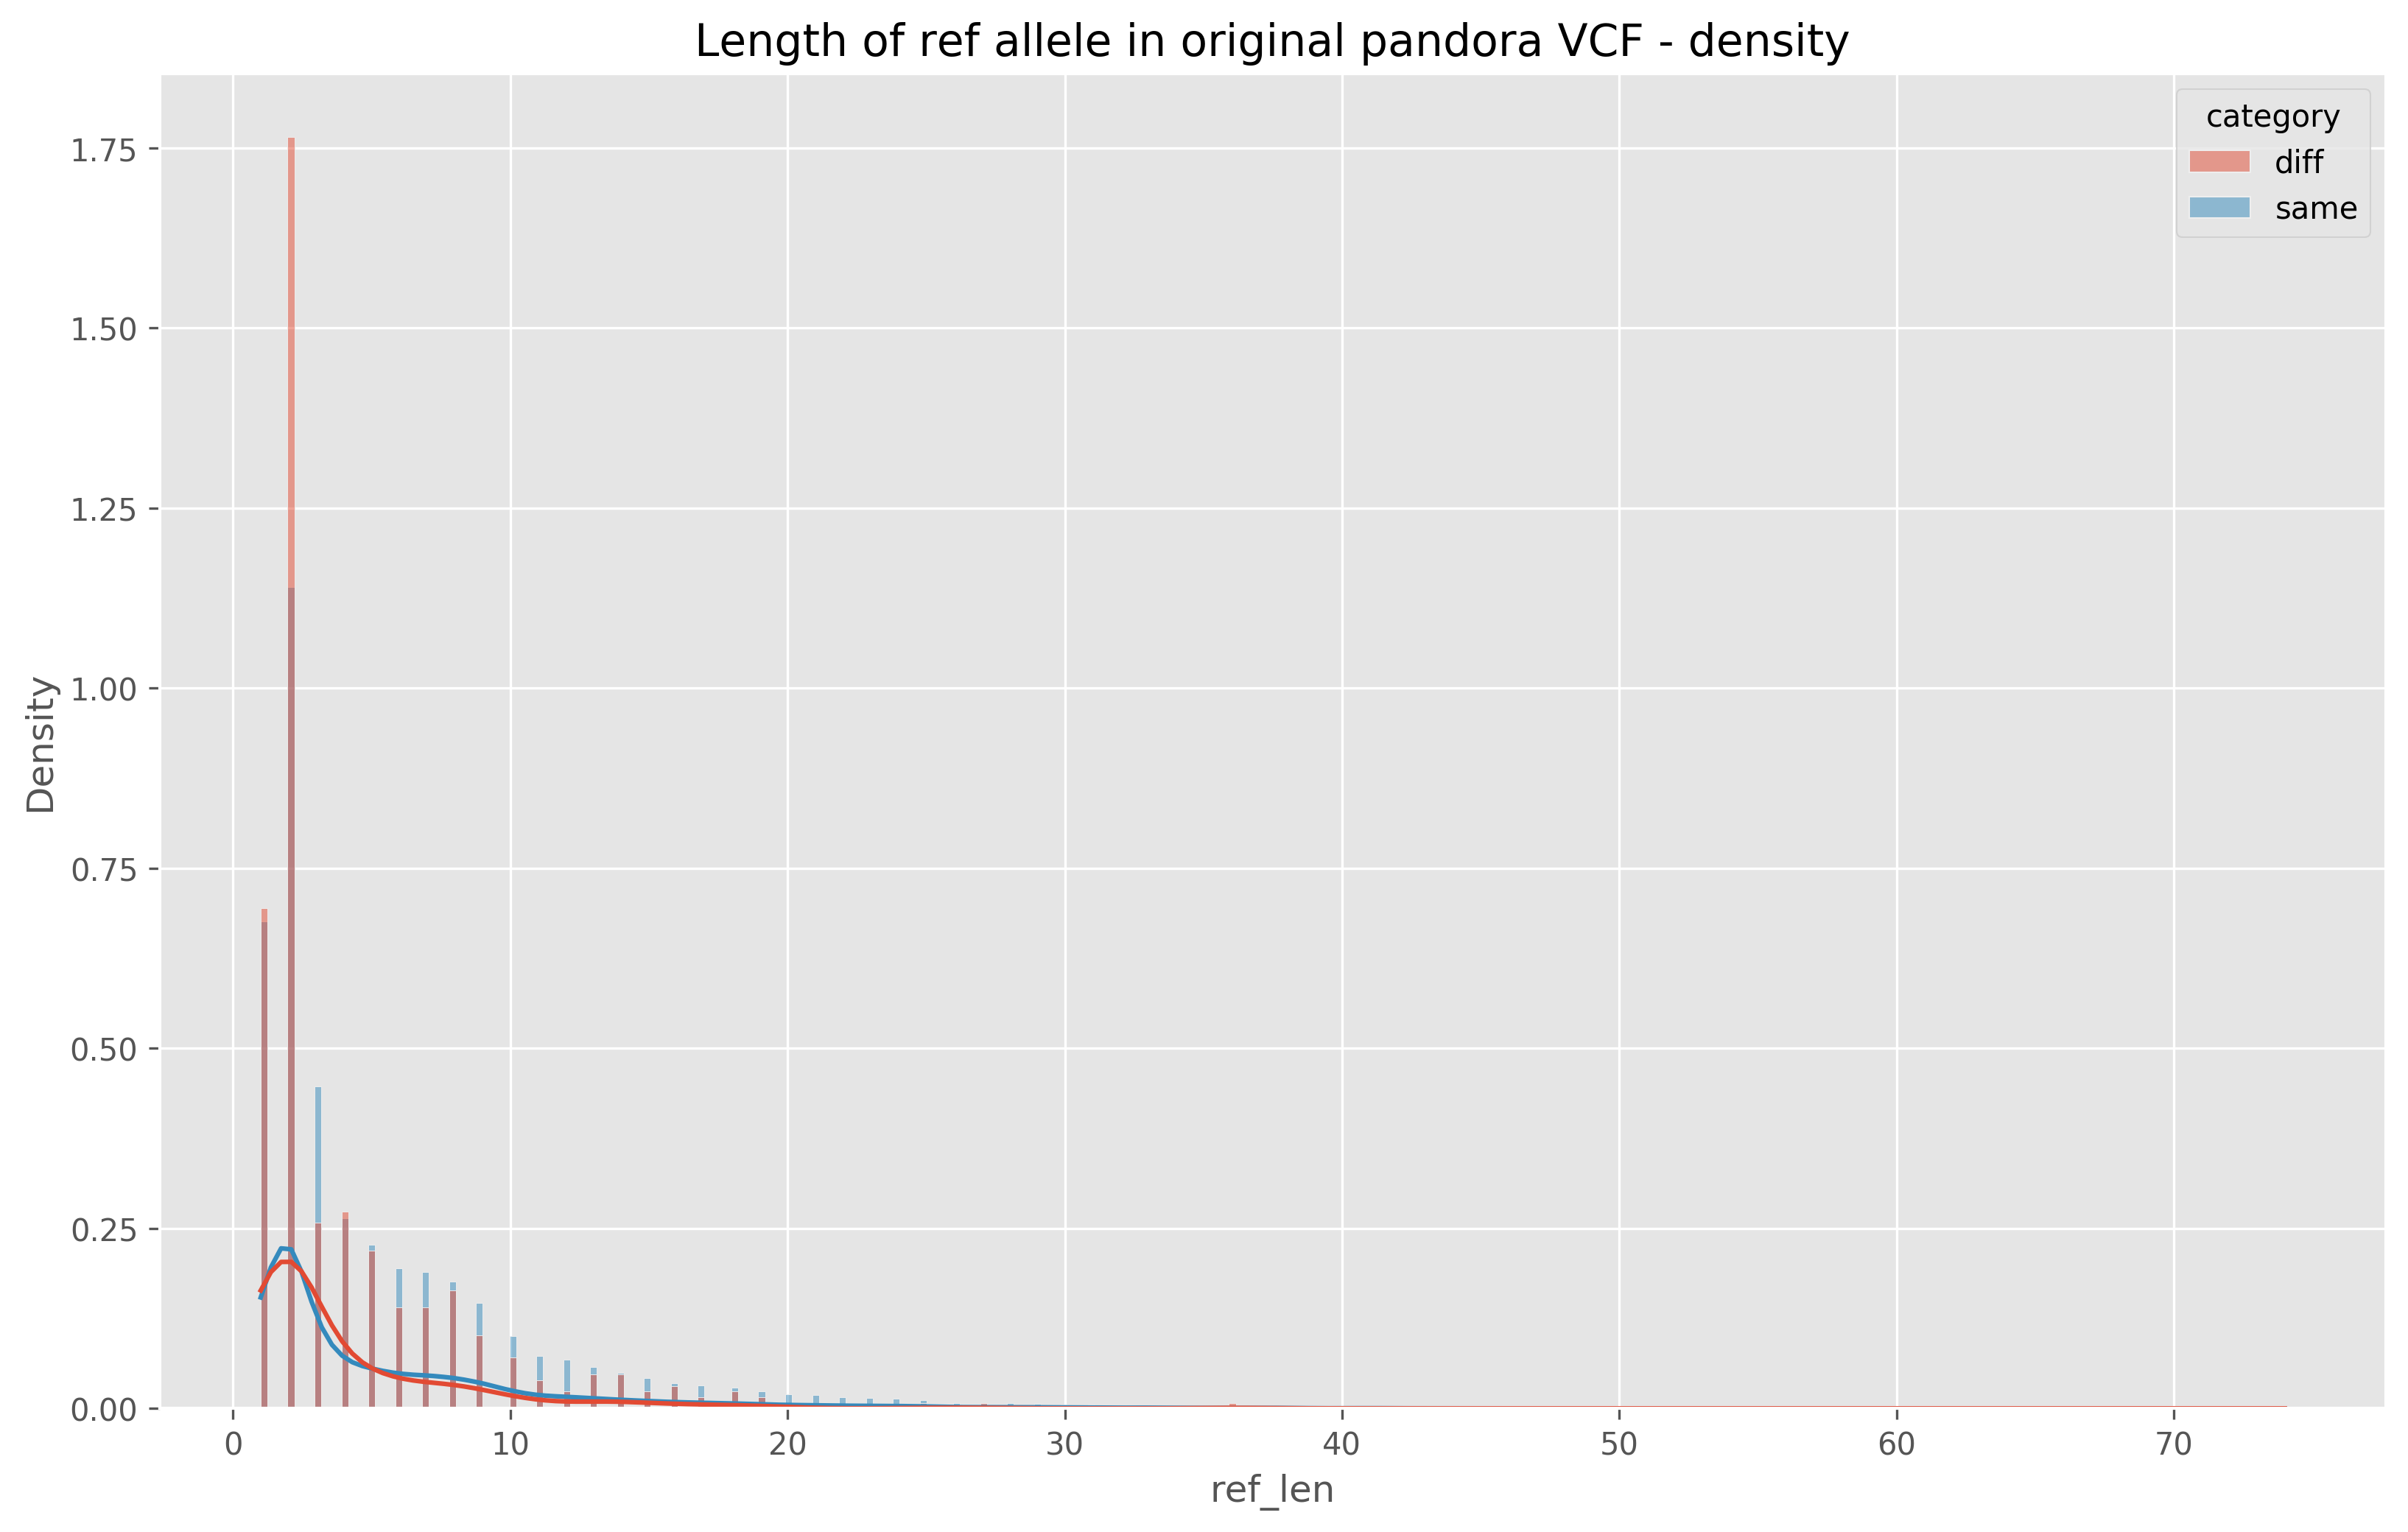

In [45]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="ref_len", hue="category", ax=ax, common_norm=False, stat="density", kde=True)
ax.set_title("Length of ref allele in original pandora VCF - density")

Text(0.5, 1.0, 'Length of ref allele in original pandora VCF - raw count')

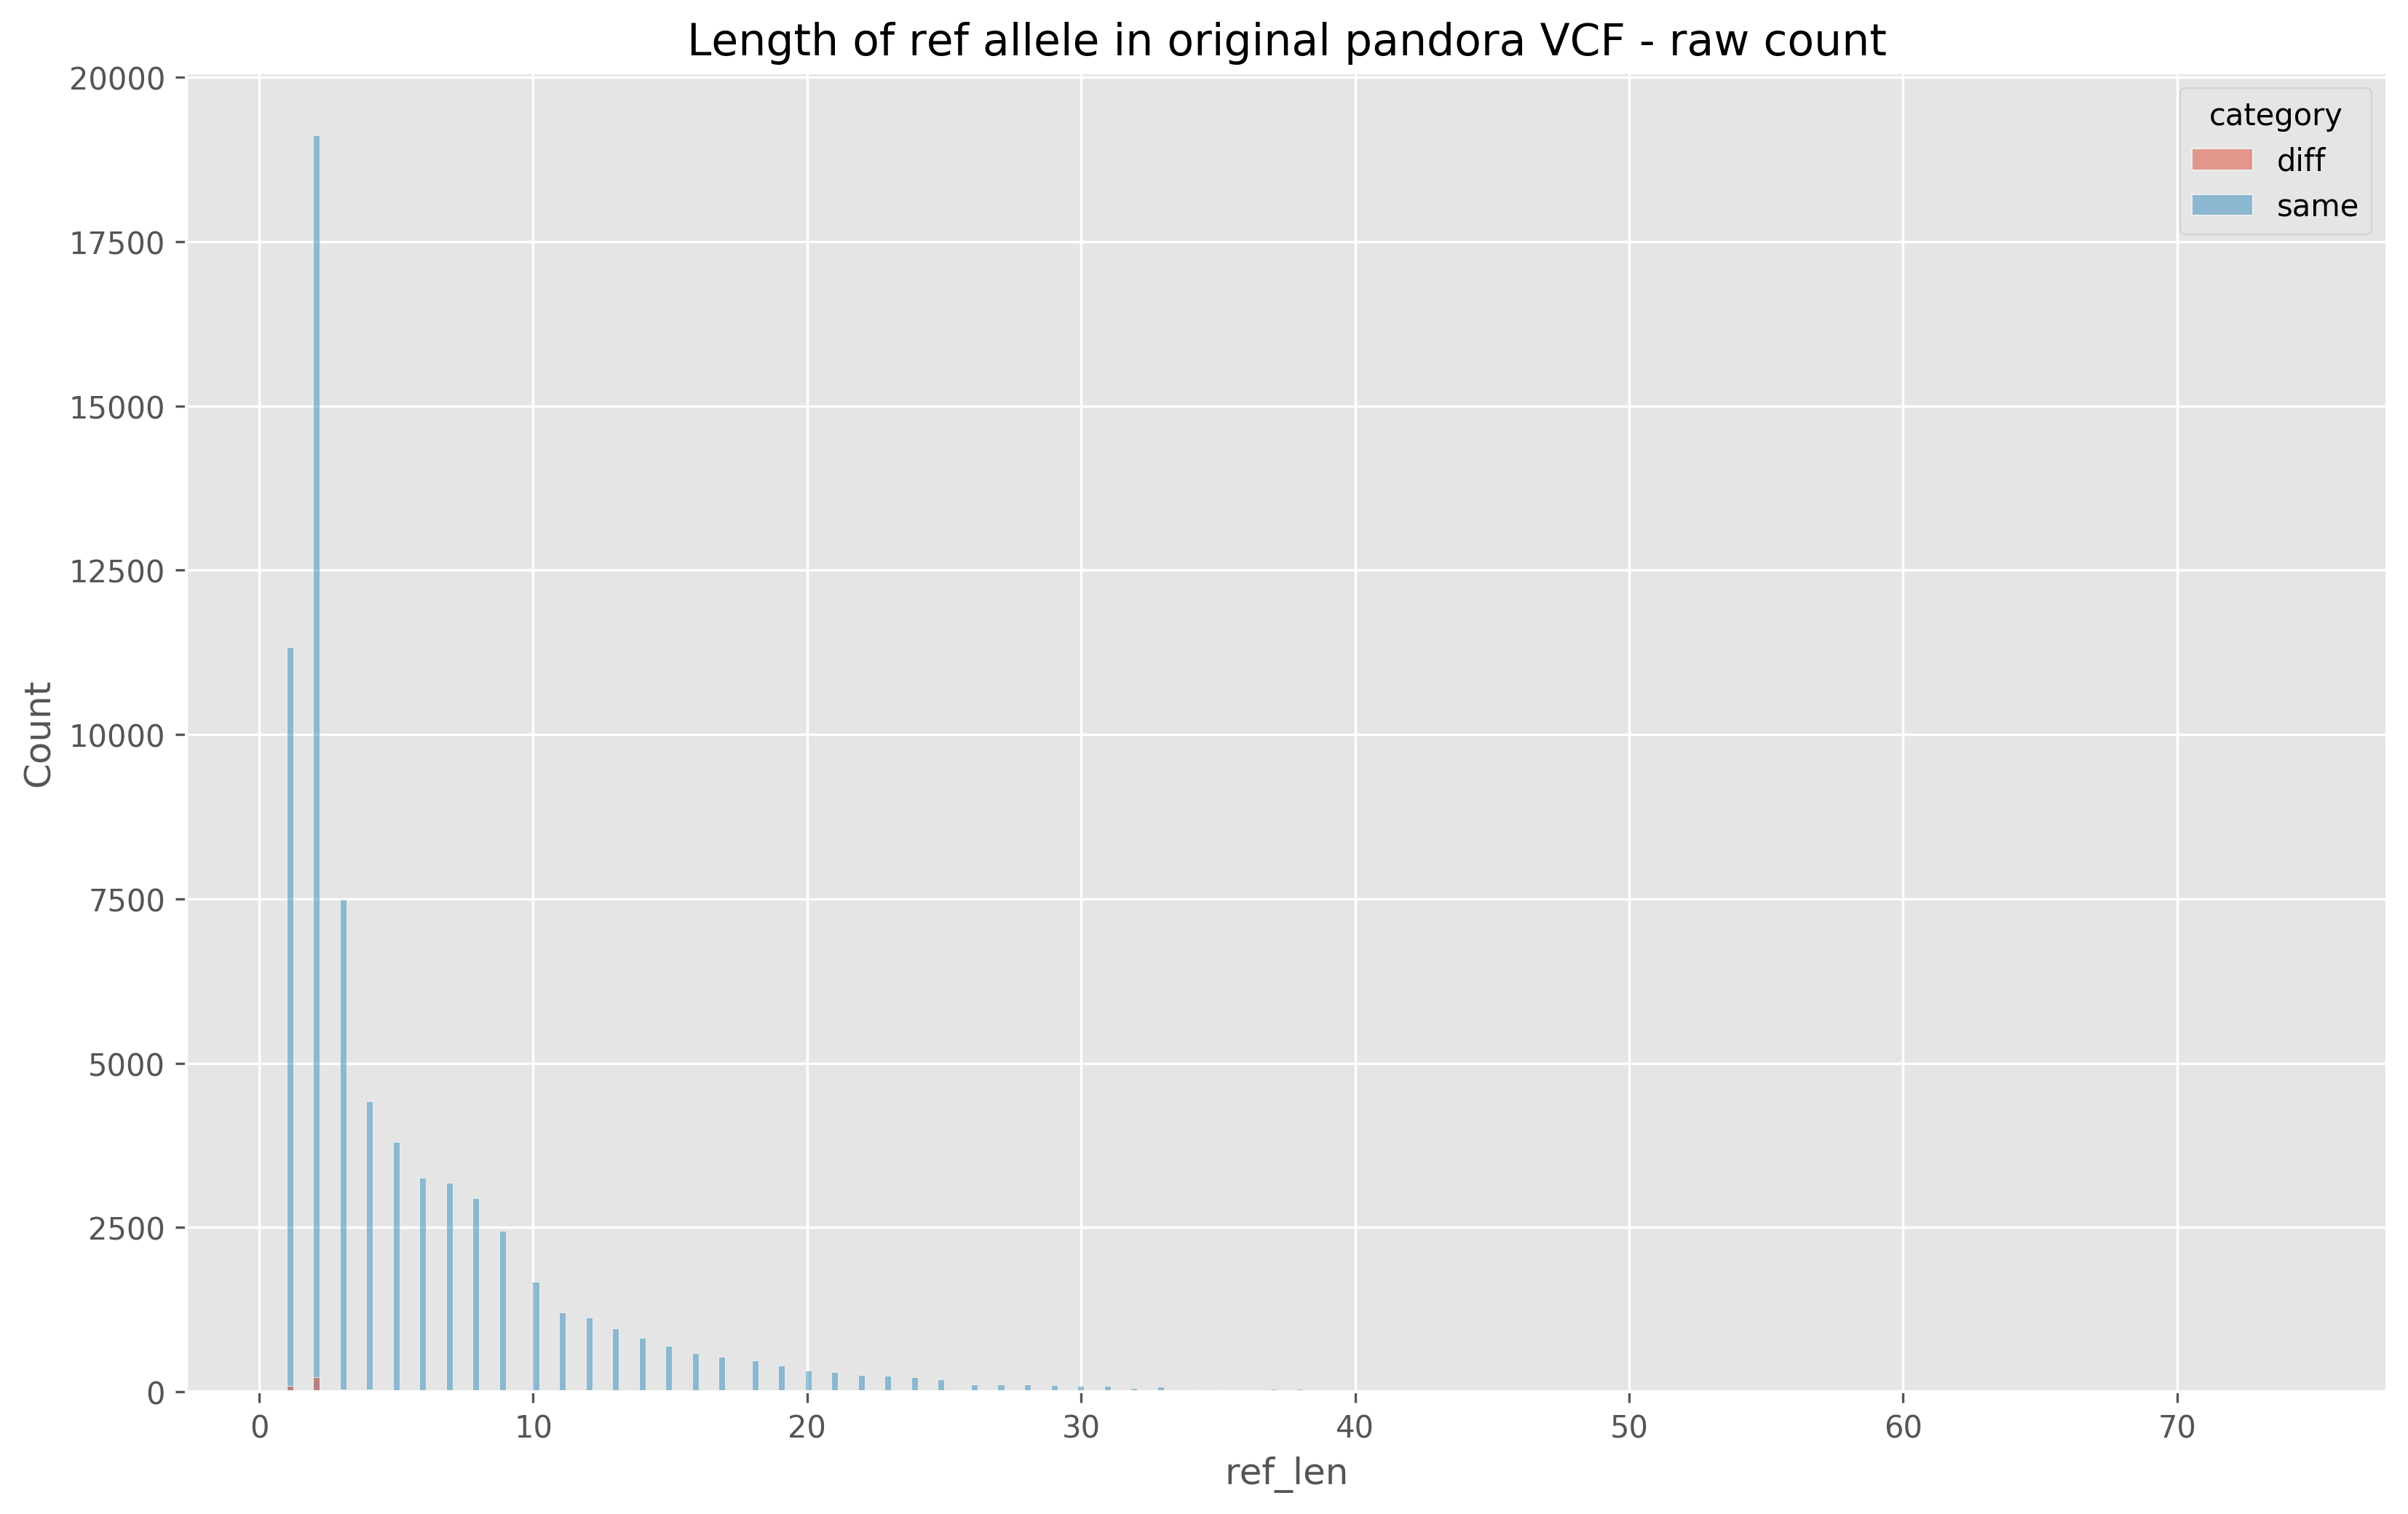

In [46]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="ref_len", hue="category", ax=ax)
ax.set_title("Length of ref allele in original pandora VCF - raw count")

Looking at the number of alternate alleles at our positions-of-interest (i.e. those where we get things right and those where we get it wrong) in the original VCFs

In [47]:
data = []
samples = []
for p in set(df["pair"]):
    s1, s2 = p.split("x")
    samples.append(s1)
    samples.append(s2)
pandora_vcf = VCF("pandora.original.compare.bcf", samples=samples)
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
        original_var = next(pandora_vcf(f"{v.CHROM}:{v.POS}"))
        var_type = variant_type(original_var)
        if var_type != "non-snp":
            continue
        data.append((pair, cat, len(original_var.ALT)))

In [49]:
y = "num_alts"
df = pd.DataFrame(data, columns=["pair", "category", y])

(0, 20)

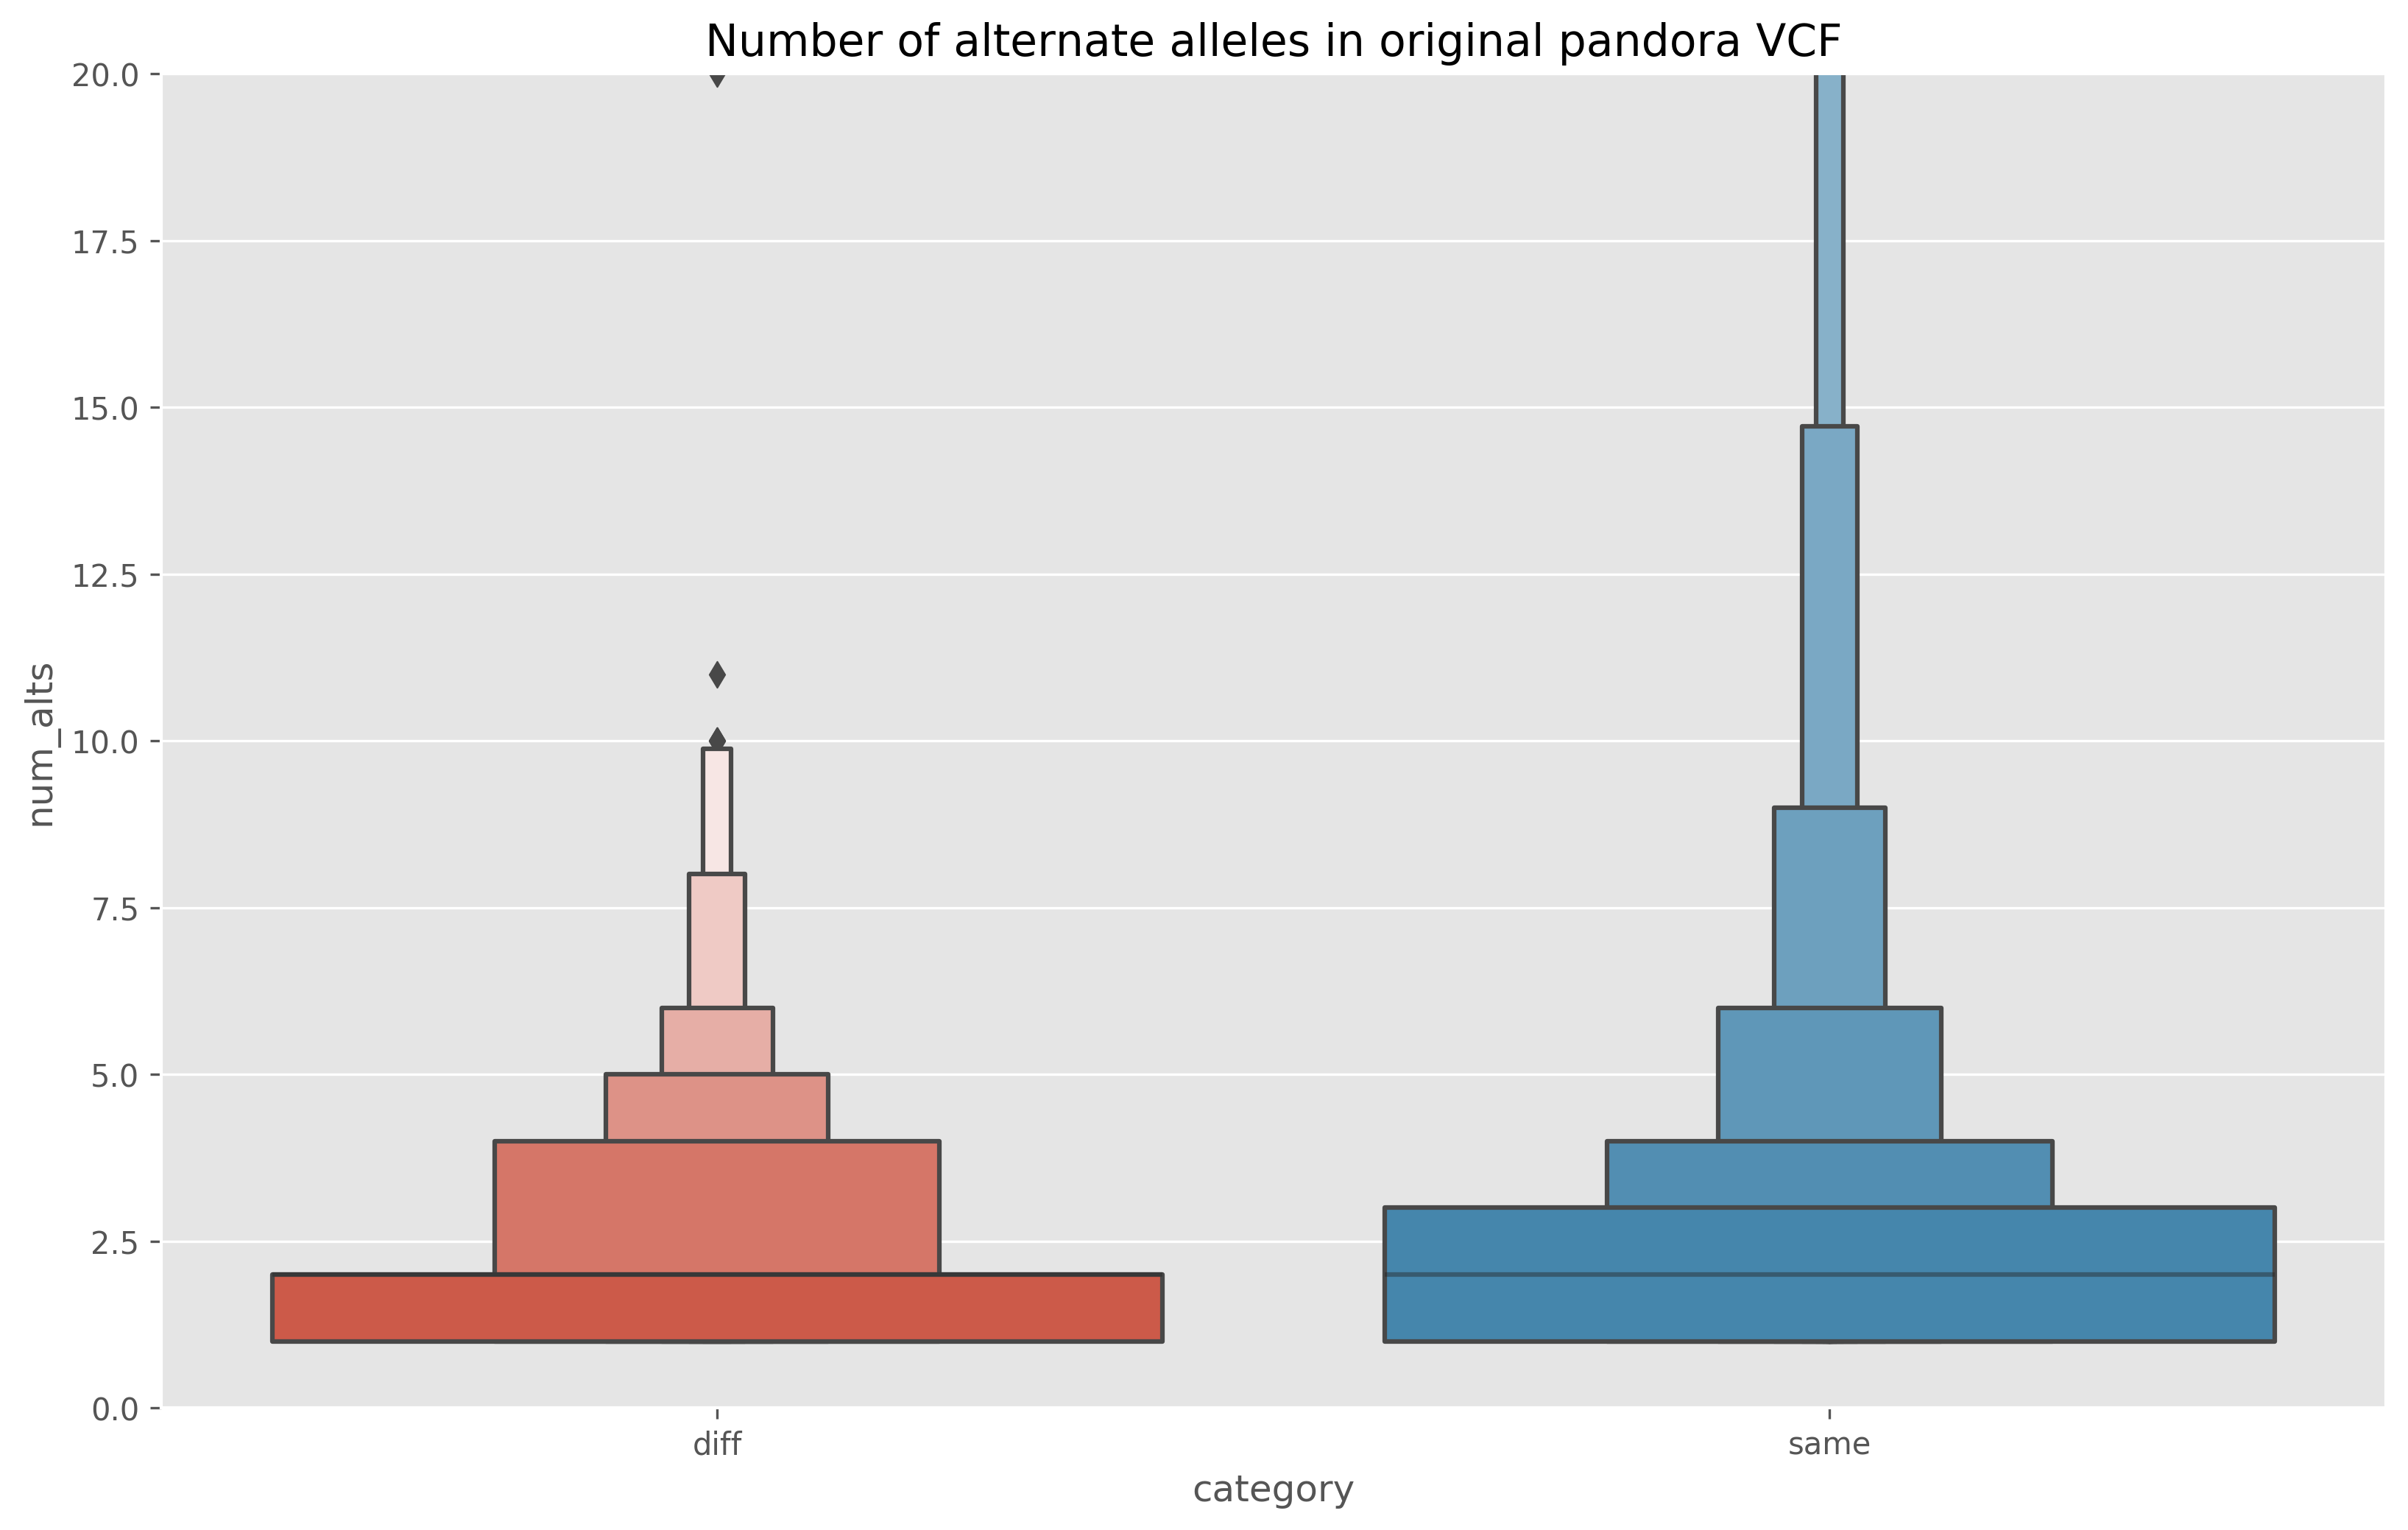

In [55]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.boxenplot(data=df, y=y, x="category", ax=ax)
ax.set_title("Number of alternate alleles in original pandora VCF")
ax.set_ylim((0, 20))

(0, 20)

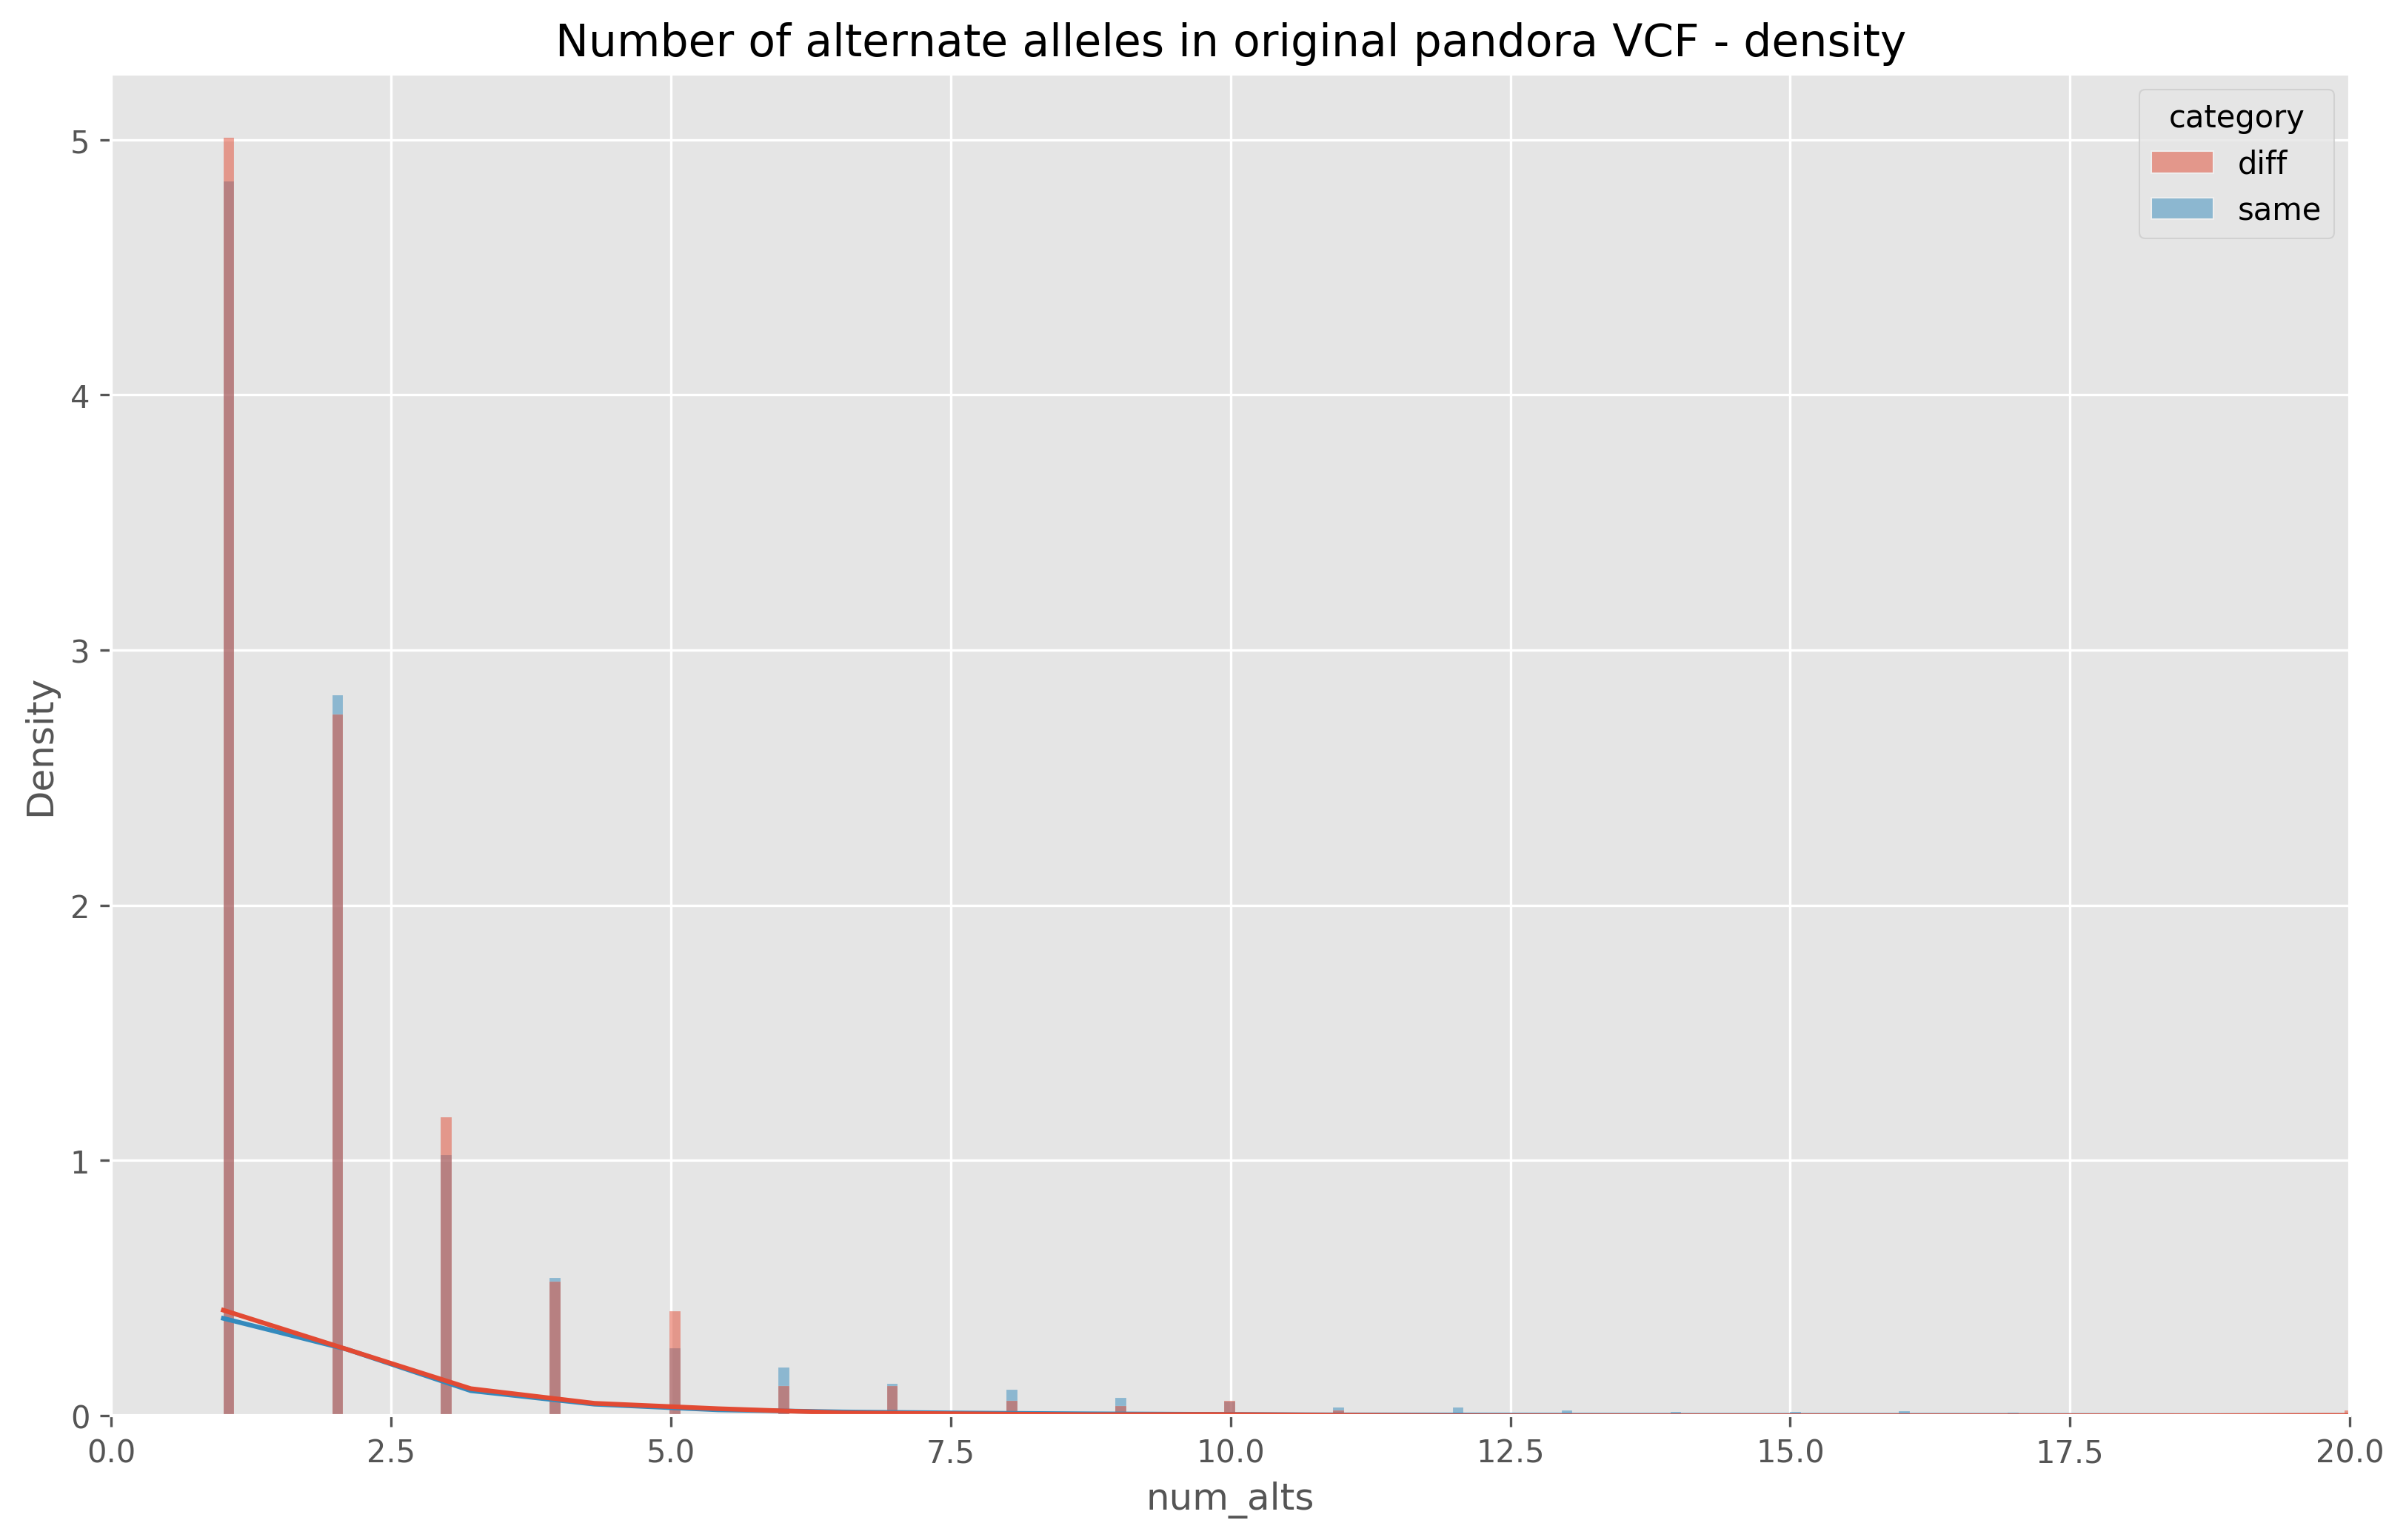

In [59]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x=y, hue="category", ax=ax, common_norm=False, stat="density", kde=True,)
ax.set_title("Number of alternate alleles in original pandora VCF - density")
ax.set_xlim((0, 20))

(0, 20)

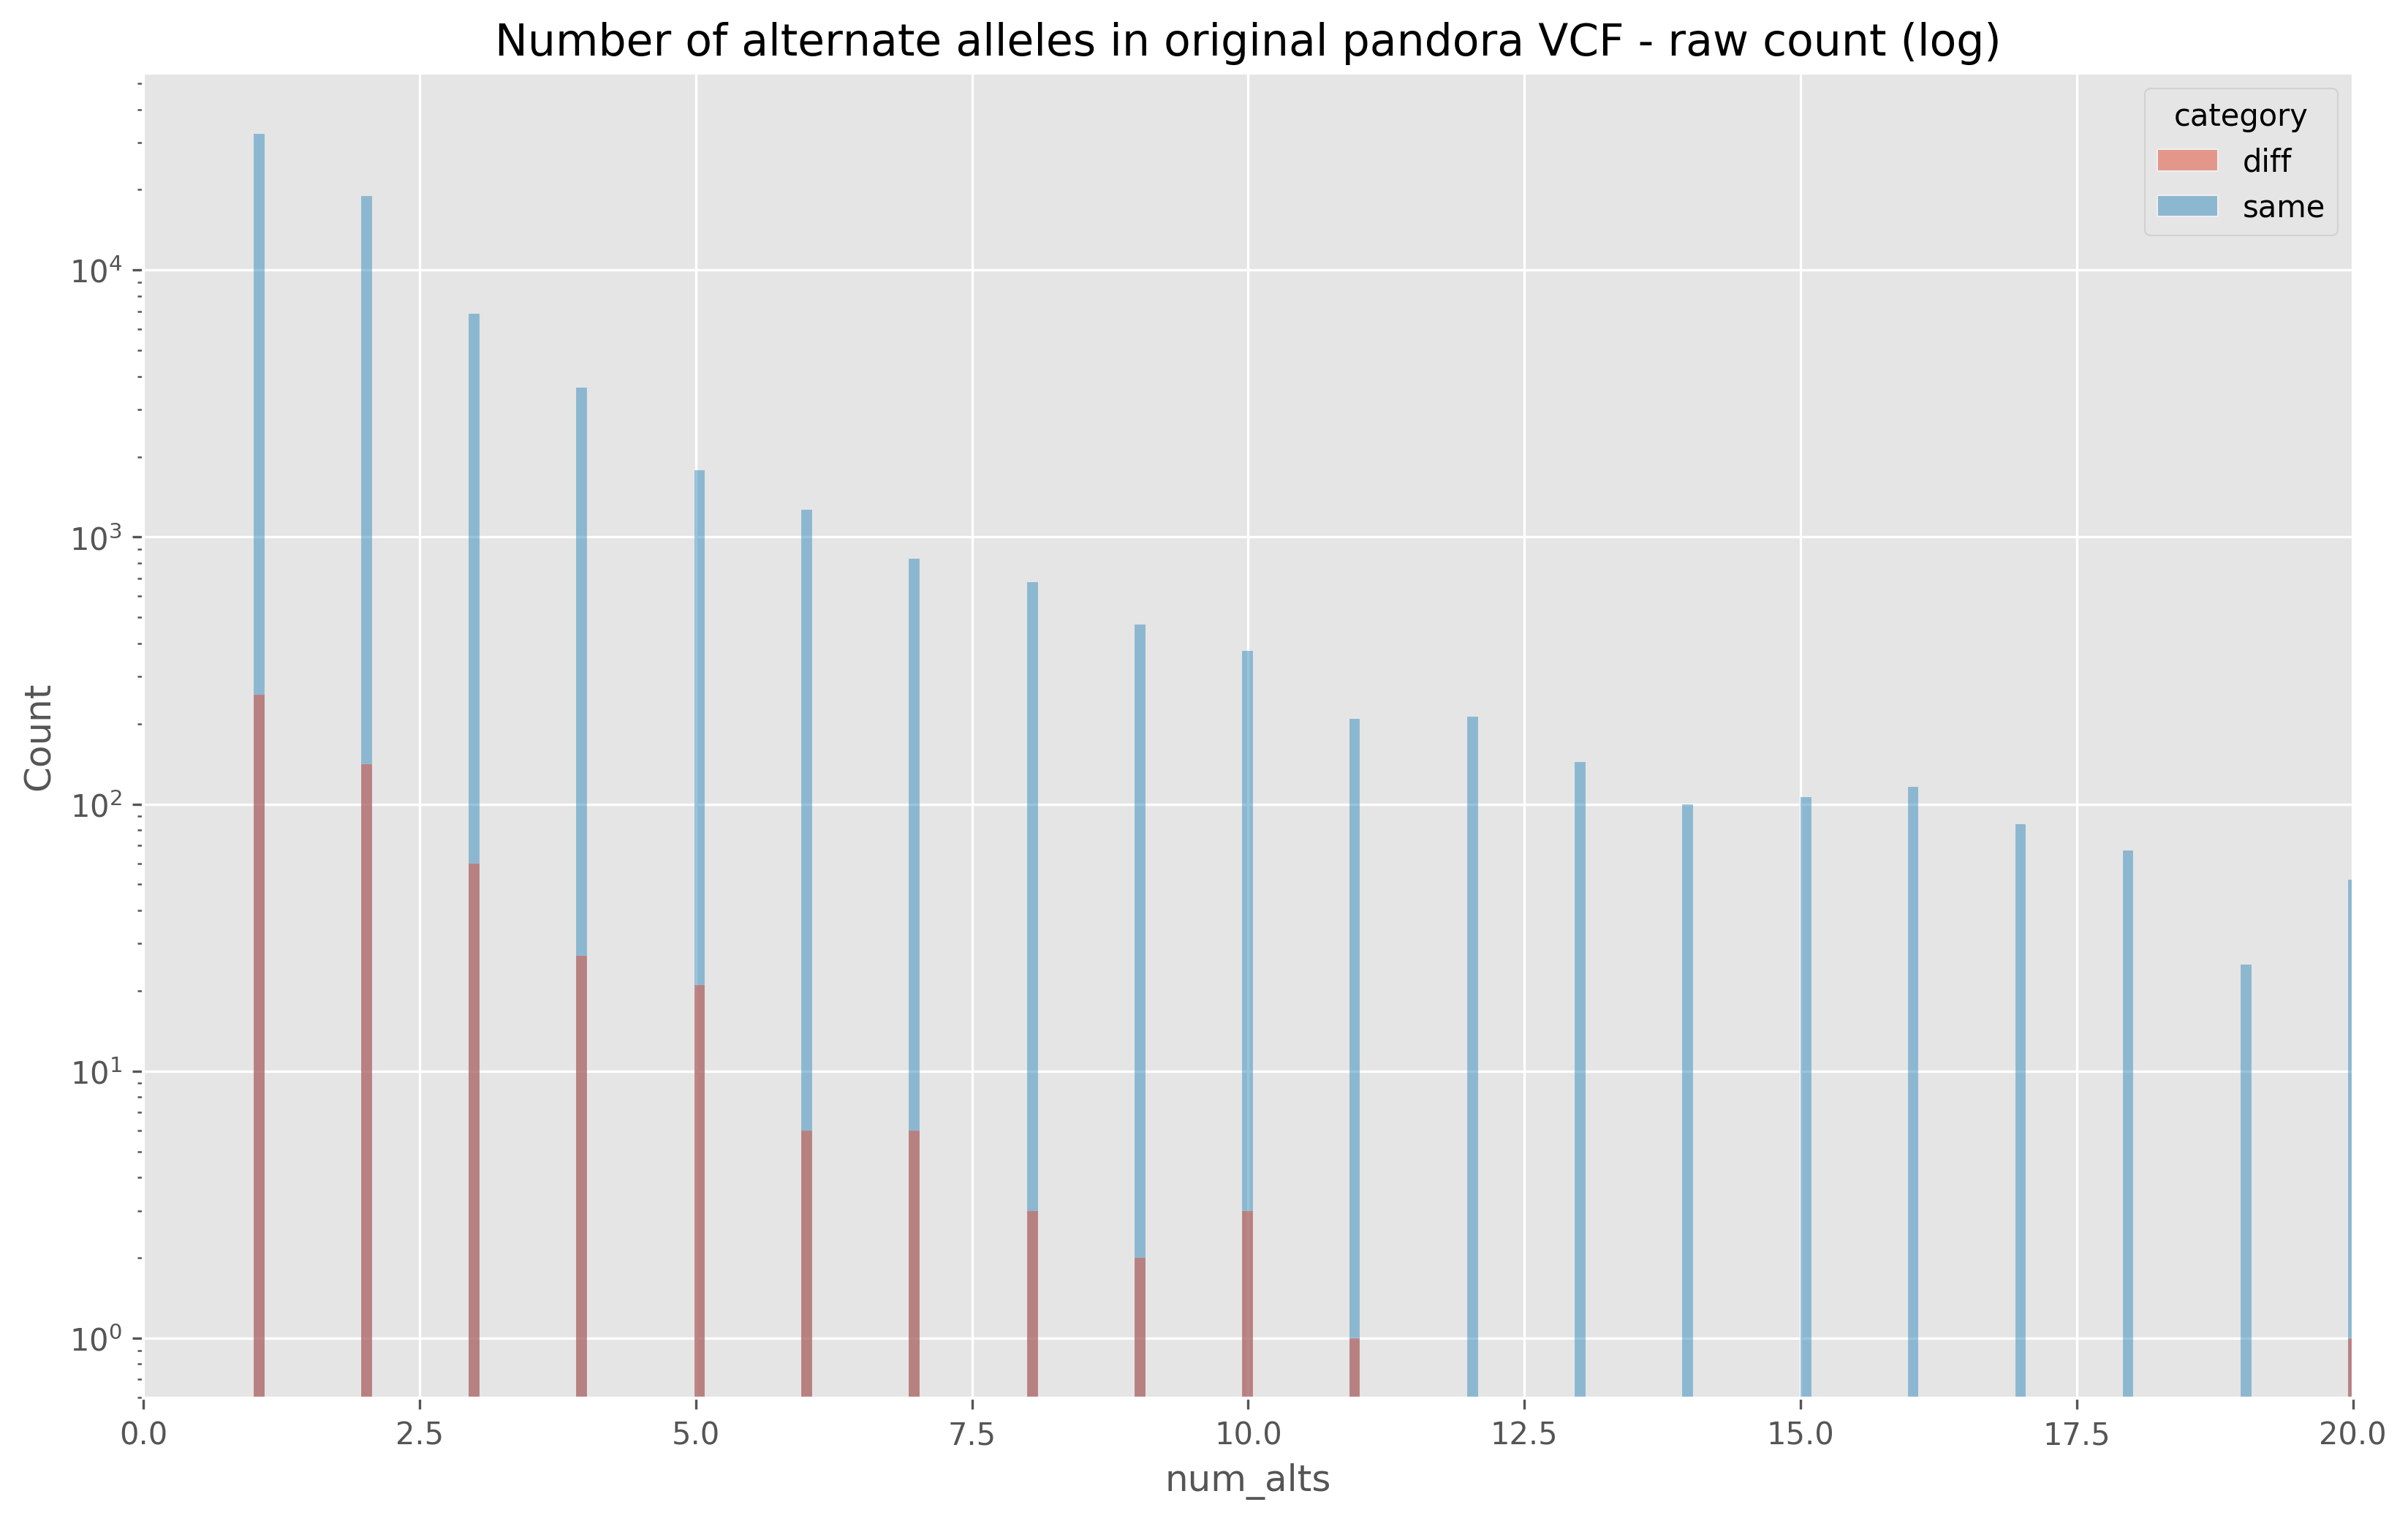

In [67]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x=y, hue="category", ax=ax, log_scale=(False,True))
ax.set_title("Number of alternate alleles in original pandora VCF - raw count (log)")
ax.set_xlim((0, 20))

>     2. Any chance of plotting counts of FPs along the genome (in case we/kerri can spot enrichment in bad regions)
> 
>     3. Could you also show FPs compared with the mask?

In [84]:
loci_info = {}
with open("loci-info.csv") as istream:
    next(istream) # skip header
    for row in map(str.rstrip, istream):
        fields = row.split(",")
        loci_info[fields[-2]] = int(fields[2]) + 1

In [86]:
data = []
for p in fpaths:
    pair, cat = p.name.split(".")[:2]
    for v in VCF(p):
#         var_type = variant_type(v)
#         if var_type != "non-snp":
#             continue
        pos_in_h37rv = loci_info[v.CHROM] + v.POS
        data.append((pair, cat, pos_in_h37rv))

In [87]:
y = "pos_in_h37rv"
df = pd.DataFrame(data, columns=["pair", "category", y])

In [128]:
positions = np.array(df.query("category == 'diff'")[y])
positions.sort()

In [189]:
mask_positions = []
with open("compass-mask.bed") as istream:
    for line in map(str.rstrip, istream):
        fields = line.split("\t")
        start = int(fields[1])
        end = int(fields[2])
        mask_positions.extend(list(range(start, end+1)))

mask_positions = np.array(mask_positions)
mask_positions.sort()

In [215]:
def intervals(start, stop, step, window):
    i = start
    while i < stop:
        yield [i, i+window]
        i += step

In [285]:
data = []
window = 50_000
step = 10_000
gsize = 4411532
for s, e in intervals(1, gsize, step, window):
    num_in_window = len(np.where(np.logical_and(positions>= s, positions<= e))[0])
    data.append([s, num_in_window, "diff"])

In [286]:
for s, e in intervals(1, gsize, step, window):
    num_in_window = len(np.where(np.logical_and(mask_positions>= s, mask_positions<= e))[0])
    data.append([s, num_in_window, "mask"])

In [287]:
df = pd.DataFrame(data, columns=["pos", "count", "category"])

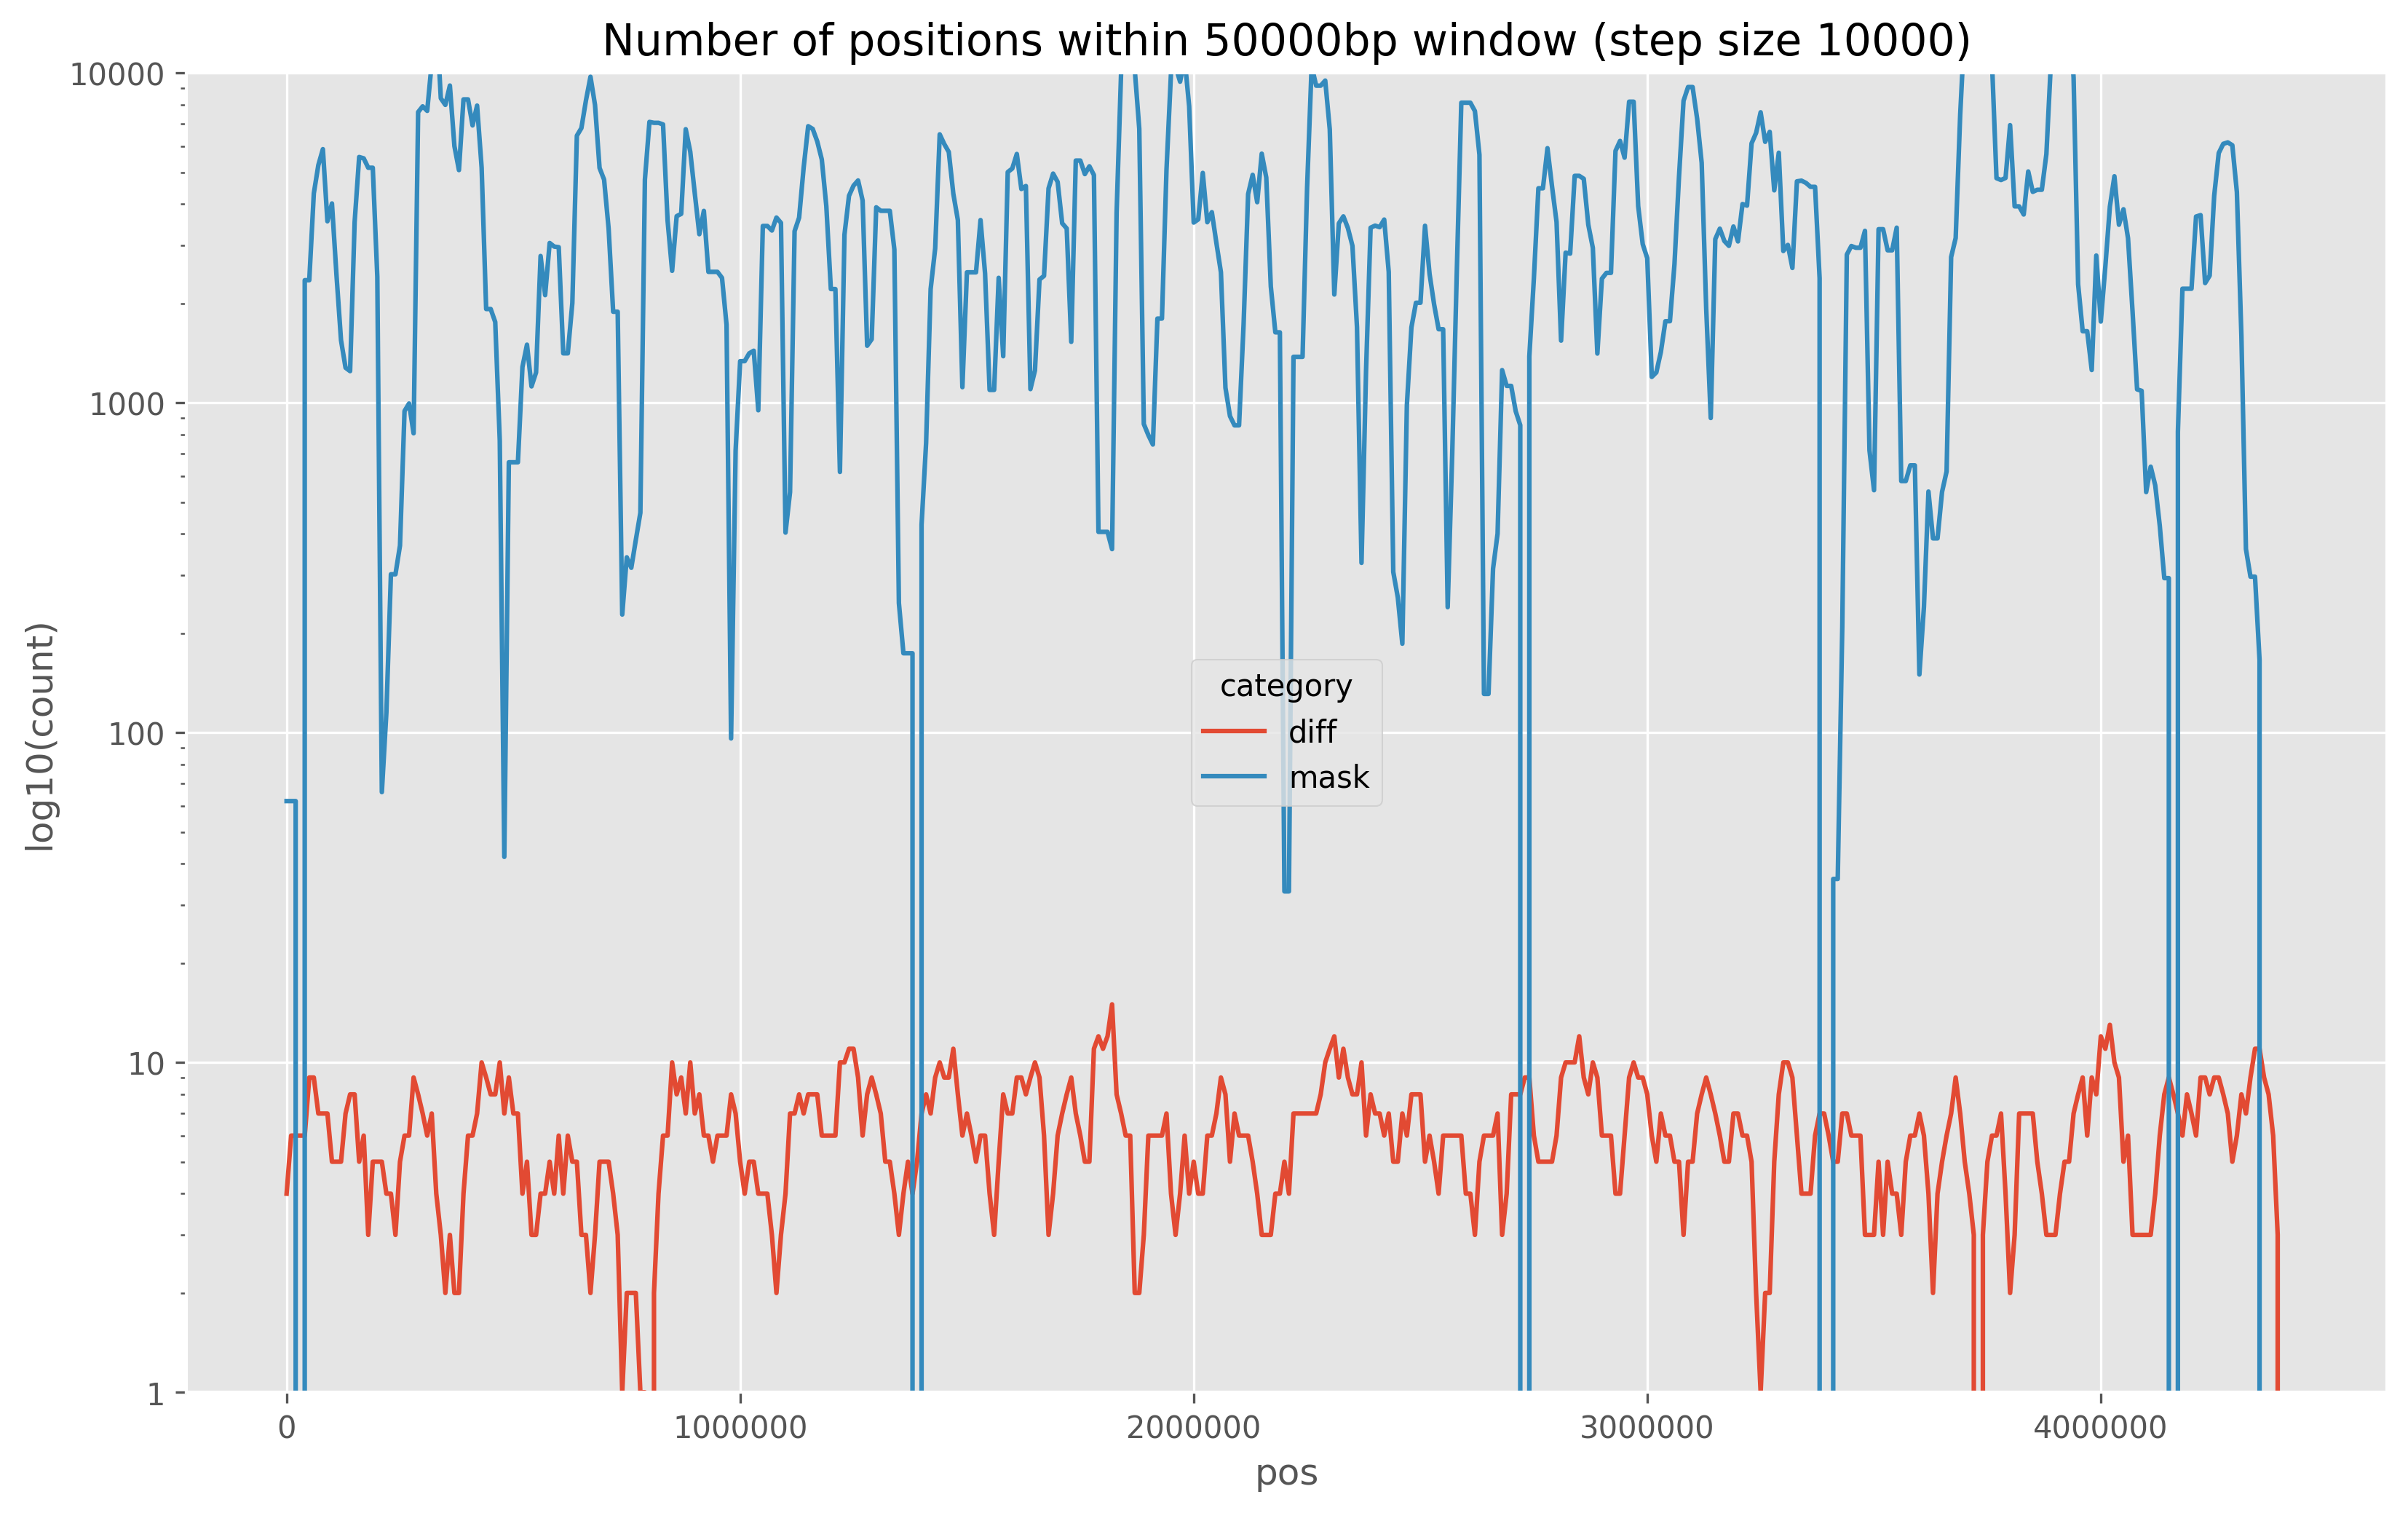

In [288]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.lineplot(data=df, x="pos", y="count", hue="category", ax=ax)
ax.set(title=f"Number of positions within {window}bp window (step size {step})")
ax.set_yscale("log")
ax.set_ylabel("log10(count)")
log_ticks = [1, 10, 100, 1000, 10000]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)